# 1. Data preprocessing

## 1.1 File Consolidation

In [11]:
import os
import re
import glob
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import copy
import random

from pathlib import Path
from dataclasses import dataclass
from typing import List
from statsmodels.tsa.stattools import adfuller
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from scipy.stats import norm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score
)


In [5]:
# Target companies, keep company names in Chinese as requested
companies = ["万科A", "比亚迪", "中国石油", "贵州茅台", "中国石化"]

# Locate all yearly files
BASE_DIR = Path(os.environ.get("DATA_DIR", Path.home())).expanduser().resolve()
DATA_DIR = (BASE_DIR /"Desktop").resolve()
pattern = str(DATA_DIR /"Thesis"/"news data"/"网络新闻量化统计（按自然日）-*.xlsx")

files = sorted(glob.glob(pattern))
if not files:
    raise FileNotFoundError(f"No files matched pattern: {pattern}")

def extract_year(path):
    m = re.search(r"-(\d{4})\.xlsx$", os.path.basename(path))
    return int(m.group(1)) if m else None

# file columns
usecols = [
    "Scode", "Coname", "Date",
    "Newsnum_Title", "Newsnum_Cont",
    "Posnews_All", "Neunews_All", "Negnews_All",
    "Posnews_Ori", "Neunews_Ori", "Negnews_Ori"
]

# Read, clean, filter, and merge across files
dfs = []
for fp in files:
    df = pd.read_excel(fp, usecols=usecols, dtype={"Scode": str})

    # Drop the first "Chinese description/header" row 
    df = df[df["Coname"].notna()]
    df = df[(df["Coname"] != "公司简称") & (df["Scode"] != "股票代码")]

    # Parse date as datetime
    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    df = df[df["Date"].notna()]

    # Filter target companies
    df = df[df["Coname"].isin(companies)].copy()

    # Add year and source filename
    df["Year"] = extract_year(fp)
    df["SourceFile"] = os.path.basename(fp)

    dfs.append(df)

all_df = pd.concat(dfs, ignore_index=True)
all_df = all_df.sort_values(["Coname", "Date"]).reset_index(drop=True)

# Output file
out_path = str(DATA_DIR / "news_data.xlsx")

with pd.ExcelWriter(out_path, engine="openpyxl") as writer:
    all_df.to_excel(writer, index=False, sheet_name="long")

    pivot = all_df.pivot_table(
        index="Date",
        columns="Coname",
        values=[
            "Newsnum_Title", "Newsnum_Cont",
            "Posnews_All", "Neunews_All", "Negnews_All",
            "Posnews_Ori", "Neunews_Ori", "Negnews_Ori"
        ],
        aggfunc="sum"
    )
    pivot.to_excel(writer, sheet_name="wide_pivot")

print(f"Merge completed: {out_path}")
print("Total rows:", len(all_df))
print("Years covered:", sorted(all_df["Year"].dropna().unique().tolist()))


Merge completed: /Users/Zhuanz1/Desktop/news_data.xlsx
Total rows: 17679
Years covered: [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]


In [6]:
THESIS_DIR = BASE_DIR /"Desktop"/"Thesis"
pattern = str(THESIS_DIR / "*price.xlsx")
files = sorted(glob.glob(pattern))
if not files:
    raise FileNotFoundError(f"No price files found in: {pattern}")

# Target stocks
code_to_name = {
    "000002": "万科A",
    "002594": "比亚迪",
    "601857": "中国石油",
    "600519": "贵州茅台",
    "600028": "中国石化",
}
target_codes = set(code_to_name.keys())

dfs = []
for fp in files:
    df = pd.read_excel(fp, sheet_name=0)

    # Keep only rows that look like real dates
    df["TradingDate"] = pd.to_datetime(df["TradingDate"], errors="coerce")
    df = df[df["TradingDate"].notna()].copy()

    # Standardize code to 6-digit string
    df["Symbol"] = df["Symbol"].astype(str).str.extract(r"(\d{6})", expand=False)

    # Filter target companies
    df = df[df["Symbol"].isin(target_codes)].copy()

    # Add company name and year
    df["Coname"] = df["Symbol"].map(code_to_name)
    df["Year"] = df["TradingDate"].dt.year
    df["SourceFile"] = os.path.basename(fp)

    dfs.append(df)

merged = pd.concat(dfs, ignore_index=True)

# Sort by company + year + date
merged = merged.sort_values(["Coname", "Year", "TradingDate"]).reset_index(drop=True)

# Output
out_path = str(THESIS_DIR / "price_data.xlsx")
merged.to_excel(out_path, index=False)

print("Merged rows:", len(merged))
print("Saved to:", out_path)
print("Companies:", merged["Coname"].unique().tolist())
print("Years:", sorted(merged["Year"].unique().tolist()))


/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/var/folders/8_/b_5nx43j4s9dttgkt926cd740000gp/T/ipykernel_4498/3678070485.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["TradingDate"] = pd.to_datetime(df["TradingDate"], errors="coerce")
/var/folders/8_/b_5nx43j4s9dttgkt926cd740000gp/T/ipykernel_4498/3678070485.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["TradingDate"] = pd.to_datetime(df["TradingDate"], errors="coerce")
/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/openpyxl/styles/stylesheet.py:23

Merged rows: 13040
Saved to: /Users/Zhuanz1/Desktop/Thesis/price_data.xlsx
Companies: ['万科A', '中国石化', '中国石油', '比亚迪', '贵州茅台']
Years: [2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]


In [7]:
# Input files
input_files = [
    THESIS_DIR / "price_data.xlsx",
    THESIS_DIR / "news_data.xlsx",
]

# Chinese -> English mapping
name_map = {
    "万科A": "Vanke A",
    "中国石化": "Sinopec",
    "中国石油": "PetroChina",
    "比亚迪": "BYD",
    "贵州茅台": "Kweichow Moutai",
}

# Possible company-name columns
NAME_COL_CANDIDATES = ["Coname", "name", "公司", "公司简称", "证券简称"]

def find_name_cols(columns):
    return [c for c in NAME_COL_CANDIDATES if c in columns]

for fp in input_files:
    xls = pd.ExcelFile(fp)
    out_path = os.path.splitext(fp)[0] + "_EN.xlsx"

    with pd.ExcelWriter(out_path, engine="openpyxl") as writer:
        for sheet in xls.sheet_names:
            df = pd.read_excel(fp, sheet_name=sheet)

            # Detect name columns in this sheet
            name_cols = find_name_cols(df.columns)

            # Replace in all detected name columns
            for col in name_cols:
                df[col] = df[col].astype(str).replace(name_map)

            df.to_excel(writer, sheet_name=sheet, index=False)

    print(f"Done: {out_path}")


Done: /Users/Zhuanz1/Desktop/Thesis/price_data_EN.xlsx
Done: /Users/Zhuanz1/Desktop/Thesis/news_data_EN.xlsx


In [10]:
import pandas as pd

# File paths
price_path = THESIS_DIR / "price_data_EN.xlsx"
news_path  = THESIS_DIR / "news_data_EN.xlsx"
out_path   = THESIS_DIR / "price_news_merged.xlsx"

# Read files
price = pd.read_excel(price_path)
news  = pd.read_excel(news_path)

# Convert Date to datetime
price["Date"] = pd.to_datetime(price["Date"], errors="coerce")
news["Date"]  = pd.to_datetime(news["Date"], errors="coerce")

# Shift news date forward by 1 day so that news on (t-1) matches price on t
news["Date"] = news["Date"] + pd.Timedelta(days=1)

# Merge
merged = pd.merge(price, news, on=["Scode", "Date"], how="left")

# Sort and save
merged = merged.sort_values(["Scode", "Date"])
merged.to_excel(out_path, index=False)

print("Saved to:", out_path)
print("Merged rows:", len(merged))


Saved to: /Users/Zhuanz1/Desktop/Thesis/price_news_merged.xlsx
Merged rows: 13040


## 1.2 Indicator Calculation

### 1.2.1 Technical Indicators

In [11]:
# Read files
THESIS_DIR = Path(THESIS_DIR).expanduser().resolve()

df = pd.read_excel(THESIS_DIR / "data" / "price_news_merged.xlsx")
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df = df.dropna(subset=["Date"]).copy()

s = df["Scode"].astype(str).str.extract(r"(\d+)", expand=False)  
df["Scode"] = s.str.zfill(6)  # Left-pad with zeros to 6 digits
df = df[df["Scode"].str.fullmatch(r"\d{6}", na=False)].copy()

df = df.dropna(subset=["Scode"]).copy()
df = df.sort_values(["Scode", "Date"]).reset_index(drop=True)

# Parameter: (High * Low)^a in PWHLD, a = 0.5 means square root
a = 0.5
# Small constant to avoid division by zero
gamma = 1e-12
# Warm-up: minimum history length per stock (maximum rolling window is 50 for PRM)
min_history = 50

def add_factors(g):
    g = g.sort_values("Date").copy()
    close = g["ClosePrice"].astype(float)
    open_ = g["OpenPrice"].astype(float)
    high  = g["HighPrice"].astype(float)
    low   = g["LowPrice"].astype(float)
    vol   = g["Volume"].astype(float)
    amt   = g["Amount"].astype(float)

    # r_t^(1) = ln(P_{t+1}) - ln(P_t)
    c = close.where(close > 0)
    c1 = close.shift(-1).where(close.shift(-1) > 0)
    c5 = close.shift(-5).where(close.shift(-5) > 0)

    g["Return_1d"] = np.log(c1) - np.log(c)
    g["Return_5d"] = np.log(c5) - np.log(c)

    # Binary label (up = 1, down = 0)
    g["y_up_1d"] = (g["Return_1d"] > 0).astype(int)  # Indicates whether price goes up from t to t+1 (direction)
    g["y_up_5d"] = (g["Return_5d"] > 0).astype(int)  # Direction after buying on day t and holding for 5 trading days

    # VA6DR = ((Close_t - Close_{t-6}) / Close_{t-6}) * Volume_t
    g["VA6DR"] = ((close - close.shift(6)) / (close.shift(6) + gamma)) * vol

    # UMF = (sum_{i=1..20} I(Close_{t-i} > Close_{t-i-1}) / 20) * 100
    up = (close.diff() > 0).astype(float)
    g["UMF"] = up.shift(1).rolling(20, min_periods=20).mean() * 100

    # PRM = (sum_{i=1..50}(High_{t-i}-Open_{t-i}) / sum_{i=1..50}(Open_{t-i}-Low_{t-i})) * 100
    num = (high - open_).shift(1).rolling(50, min_periods=50).sum()
    den = (open_ - low).shift(1).rolling(50, min_periods=50).sum()
    g["PRM"] = (num / (den + gamma)) * 100

    # PWHLD = (High_t * Low_t)^a - Amount_t / Volume_t
    g["PWHLD"] = np.power((high * low).clip(lower=0), a) - (amt / (vol + gamma))

    # 20DAMA = (1/20) * sum_{i=1..20} Amount_{t-i}
    g["20DAMA"] = amt.shift(1).rolling(20, min_periods=20).mean()

    # 5DAMA = (1/5) * sum_{i=1..5} Amount_{t-i}
    g["5DAMA"] = amt.shift(1).rolling(5, min_periods=5).mean()

    # DPA = -1 if (High-Open)(Close-Low) < (Open-Low)(High-Close), else 0
    cond = (high - open_) * (close - low) < (open_ - low) * (high - close)
    g["DPA"] = np.where(cond, -1, 0).astype(int)

    # OR = Open_t / Close_{t-1} - 1
    g["OR"] = open_ / (close.shift(1) + gamma) - 1

    # STCPC = ((1/6) * sum_{i=1..6} Close_{t-i}) / Close_t
    g["STCPC"] = close.shift(1).rolling(6, min_periods=6).mean() / close

    # IPM = (Close_t - Open_t) / (High_t - Low_t + gamma)
    g["IPM"] = (close - open_) / (high - low + gamma)

    # RSI
    delta = close.diff()
    gain = delta.clip(lower=0).ewm(alpha=1/14, adjust=False).mean()
    loss = (-delta.clip(upper=0)).ewm(alpha=1/14, adjust=False).mean()
    rs = gain / (loss + gamma)
    g["RSI"] = 100 - (100 / (1 + rs))

    # MACD
    exp12 = close.ewm(span=12, adjust=False).mean()
    exp26 = close.ewm(span=26, adjust=False).mean()
    g["MACD"] = exp12 - exp26
    g["MACD_Signal"] = g["MACD"].ewm(span=9, adjust=False).mean()
    g["MACD_Hist"] = g["MACD"] - g["MACD_Signal"]

    # ATR
    tr1 = high - low
    tr2 = (high - close.shift(1)).abs()
    tr3 = (low - close.shift(1)).abs()
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    g["ATR"] = tr.rolling(window=14).mean()

    # Bollinger Bands
    ma20 = close.rolling(window=20).mean()
    std20 = close.rolling(window=20).std()
    g["Boll_Upper"] = ma20 + 2 * std20
    g["Boll_Lower"] = ma20 - 2 * std20
    g["Boll_Pos"] = (close - g["Boll_Lower"]) / (g["Boll_Upper"] - g["Boll_Lower"] + gamma)

    # ROC
    g["ROC"] = ((close - close.shift(10)) / (close.shift(10) + gamma)) * 100

    # Warm-up: remove the first min_history-1 rows caused by insufficient history
    if len(g) >= min_history:
        g = g.iloc[min_history - 1:].copy()
    else:
        # Stocks with too short history are dropped
        return g.iloc[0:0].copy()

    return g

out = df.groupby("Scode", group_keys=False, sort=False).apply(add_factors)

# Save
out.to_excel(THESIS_DIR / "price_news_factors.xlsx", index=False)
print("done:", out.shape)


/var/folders/8_/b_5nx43j4s9dttgkt926cd740000gp/T/ipykernel_4498/2181994569.py:117: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  out = df.groupby("Scode", group_keys=False, sort=False).apply(add_factors)


done: (12795, 47)


### 1.2.2 Sentiment Indicators

In [21]:
eps = 1e-12

df = pd.read_excel(THESIS_DIR / "data" / "price_news_factors.xlsx")
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df = df.dropna(subset=["Date"]).copy()

need = ["Posnews_All", "Neunews_All", "Negnews_All", "Newsnum_Cont"]
missing = [c for c in need if c not in df.columns]
if missing:
    raise KeyError(f"Missing columns: {missing}")

# Only when defining “no news / news not captured = 0” is it allowed to fill with 0
for c in need:
    df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0)

df["Newsnum_Cont"] = df["Newsnum_Cont"].clip(lower=0)

P = df["Posnews_All"].clip(lower=0)
U = df["Neunews_All"].clip(lower=0)
N = df["Negnews_All"].clip(lower=0)

T = (P + U + N)

df["sent_SB"]  = (P - N) / (T + eps)
df["sent_NEG"] = N / (T + eps)
df["sent_ATT"] = np.log1p(df["Newsnum_Cont"])
df["sent_HAS"] = (df["Newsnum_Cont"] > 0).astype(int)

out_path = THESIS_DIR / "price_news_sentiment.xlsx"
df.to_excel(out_path, index=False)
print("Saved:", out_path)


Saved: /Users/Zhuanz1/Desktop/Thesis/price_news_sentiment.xlsx


# 2. Data Cleaning

In [12]:
def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    # Determinism tradeoff: keep stable for paper; can be slower
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [13]:
DEFAULT_SEED = 1234
set_seed(DEFAULT_SEED)

In [14]:
# split
TRAIN_END = pd.Timestamp("2020-12-31")
VAL_END = pd.Timestamp("2022-12-31")

# window
LAG = 5

# standardization boundary strategy
MIN_TRAIN_ROWS_PER_CODE = 30
EPS = 1e-8

DATE_COL = "Date"

LOG_TARGETS = ["Volume", "Amount"]
FEATURE_COLS = [
    "OpenPrice", "ClosePrice", "HighPrice", "LowPrice",
    "Volume", "ChangeRatio",
    "VA6DR", "UMF", "PRM", "PWHLD", "20DAMA", "5DAMA", "DPA", "OR", "STCPC", "IPM",
    "RSI", "MACD", "MACD_Signal", "MACD_Hist", "ATR",
    "Boll_Upper", "Boll_Lower", "Boll_Pos", "ROC",
    "sent_SB", "sent_NEG", "sent_ATT", "sent_HAS"
]
SENT_COLS = ["sent_SB", "sent_NEG", "sent_ATT", "sent_HAS"]


In [4]:
# Read file
input_path = THESIS_DIR / "price_news_sentiment.xlsx"
out_path = THESIS_DIR / "price_news_clean.xlsx"

df = pd.read_excel(input_path)

# Date parsing and sorting
if "Date" not in df.columns:
    raise KeyError("Missing required column: Date")
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df = df.dropna(subset=["Date"]).copy()

if "Scode" not in df.columns:
    raise KeyError("Missing required column: Scode")

# Convert to string and strip whitespace
df["Scode"] = df["Scode"].astype(str).str.strip()
df["Scode"] = df["Scode"].replace({"": np.nan, "nan": np.nan, "None": np.nan, "NaN": np.nan})
# Excel may drop leading zeros; pad to 6 digits
s = df["Scode"].astype(str).str.strip()
s = s.str.replace(r"\.0$", "", regex=True)
s = s.str.extract(r"(\d+)", expand=False)          
df["Scode"] = s.str.zfill(6)
df["Scode"] = df["Scode"].where(df["Scode"].str.fullmatch(r"\d{6}", na=False))

# Fill missing Scode based on Coname
if "Coname" in df.columns:
    tmp = df.dropna(subset=["Scode", "Coname"]).copy()
    name_to_code = tmp.groupby("Coname")["Scode"].agg(lambda x: x.value_counts().idxmax()).to_dict()

    missing_before = df["Scode"].isna().sum()
    df["Scode"] = df["Scode"].fillna(df["Coname"].map(name_to_code))
    missing_after = df["Scode"].isna().sum()
    if missing_before != missing_after:
        print(f"Scode repaired using Coname: {missing_before} -> {missing_after}")

# Ensure there are no rows with missing Scode
df = df.dropna(subset=["Scode"]).copy()  # Cannot group if the primary key is missing

# Remove suspended and non-trading rows
mask_valid_trade = pd.Series(True, index=df.index)
if "Volume" in df.columns:
    mask_valid_trade &= pd.to_numeric(df["Volume"], errors="coerce").fillna(0) > 0
if "Amount" in df.columns:
    mask_valid_trade &= pd.to_numeric(df["Amount"], errors="coerce").fillna(0) > 0
if "OpenPrice" in df.columns:
    mask_valid_trade &= df["OpenPrice"].notna()
df = df[mask_valid_trade].copy()

# Label safety checks
if "y_up_1d" not in df.columns:
    raise KeyError("Missing label column: y_up_1d")
if "Return_1d" in df.columns:
    df.loc[
        pd.to_numeric(df["Return_1d"], errors="coerce").isna(),
        "y_up_1d"
    ] = np.nan

df["y_up_1d"] = pd.to_numeric(df["y_up_1d"], errors="coerce")
df = df.dropna(subset=["y_up_1d"]).copy()
df["y_up_1d"] = df["y_up_1d"].astype(int)

missing_cols = [c for c in FEATURE_COLS if c not in df.columns]
if missing_cols:
    raise KeyError(f"Missing columns for features: {missing_cols}")

# Convert numeric feature columns only
for c in FEATURE_COLS:
    df[c] = pd.to_numeric(df[c], errors="coerce")

df[FEATURE_COLS] = df[FEATURE_COLS].replace([np.inf, -np.inf], np.nan)

df = df.sort_values(["Scode", "Date"]).reset_index(drop=True)

df.to_excel(out_path, index=False)
print("Saved (pre-split, pre-impute):", out_path)
print("Base shape:", df.shape)


Saved (pre-split, pre-impute): /Users/Zhuanz1/Desktop/Thesis/price_news_clean.xlsx
Base shape: (11805, 51)


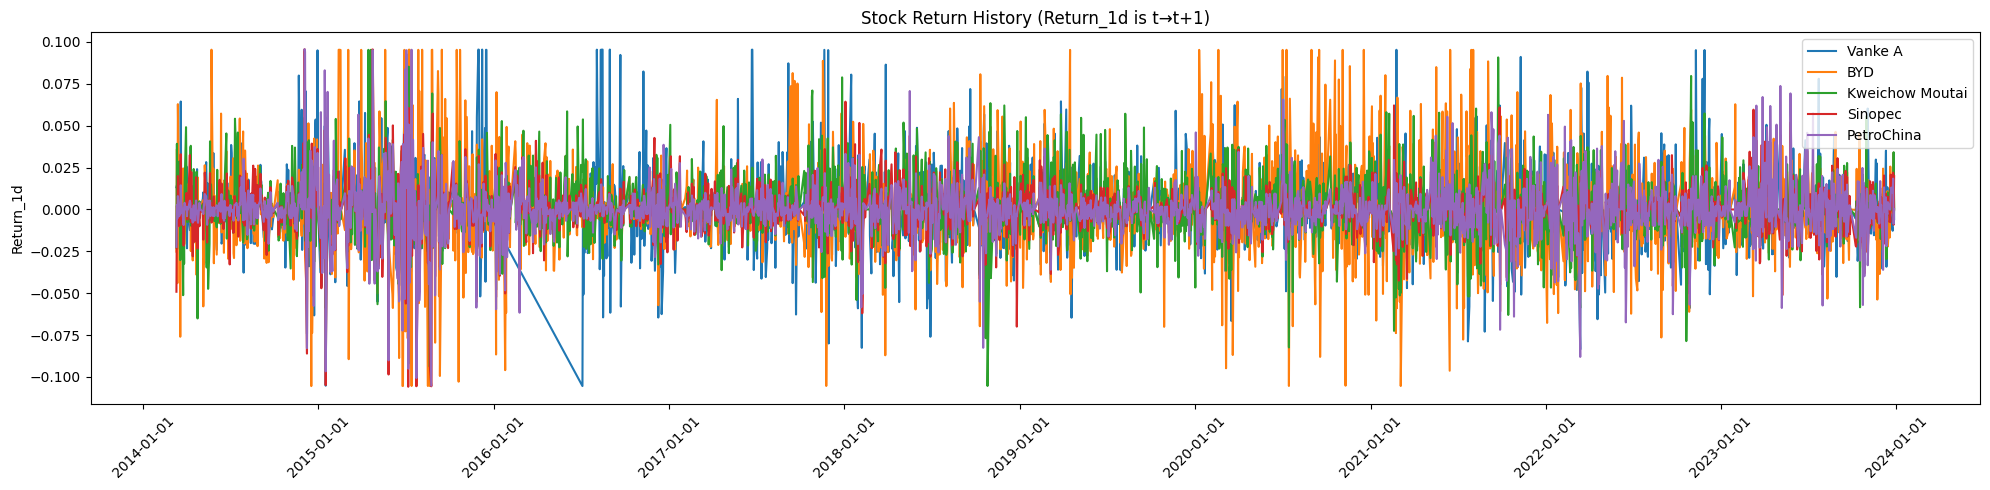

In [15]:
BASE_DIR = Path(os.environ.get("DATA_DIR", Path.home())).expanduser().resolve()
THESIS_DIR = BASE_DIR /"Desktop"/"Thesis"
THESIS_DIR = Path(THESIS_DIR).expanduser().resolve()
df = pd.read_excel(THESIS_DIR/"price_news_clean.xlsx")
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
names = ["Vanke A", "BYD", "Kweichow Moutai","Sinopec","PetroChina"] 

fig, ax = plt.subplots(figsize=(20, 5))
for name in names:
    tmp = (
        df[df["Coname"] == name]
        .dropna(subset=["Date", "Return_1d"])
        .sort_values("Date")
    )
    if tmp.empty:
        print(f"[WARN] No data for {name}")
        continue
    ax.plot(tmp["Date"], tmp["Return_1d"], label=name)


ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=8, maxticks=12))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))

ax.set_title("Stock Return History (Return_1d is t→t+1)")
ax.set_ylabel("Return_1d")
plt.xticks(rotation=45)
ax.legend(loc="upper right")
plt.tight_layout()
plt.show()

In [16]:
# Ensure Date is datetime
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
df = df.dropna(subset=["Coname", "Date"]).copy()

names = ["Vanke A", "BYD", "Kweichow Moutai", "Sinopec", "PetroChina"]

all_tables = []

for name in names:
    tmp = df[df["Coname"] == name].sort_values("Date").copy()
    if tmp.empty:
        print(f"[WARN] No data for {name}")
        continue

    # Compute gaps between consecutive trading dates
    tmp["gap_days"] = tmp["Date"].diff().dt.days
    gap_counts = (
        tmp["gap_days"]
        .dropna()
        .astype(int)
        .value_counts()
        .sort_index()
    )

    print("\n" + "=" * 60)
    print(f"{name} | rows={len(tmp)} | date range: {tmp['Date'].min().date()} ~ {tmp['Date'].max().date()}")
    print("gap_days frequency (distribution of gaps between consecutive dates):")
    print(gap_counts)

    # Aggregate into a single summary table
    t = gap_counts.rename(name).reset_index()
    t.columns = ["gap_days", "count"]
    all_tables.append(t)

# Merge into a comparison table
if all_tables:
    gap_compare = (
        pd.concat(all_tables, axis=0)
        .pivot_table(
            index="gap_days",
            columns=None,
            values="count",
            aggfunc="sum"
        )
    )



Vanke A | rows=2255 | date range: 2014-03-11 ~ 2023-12-28
gap_days frequency (distribution of gaps between consecutive dates):
gap_days
1      1777
2         3
3       413
4        23
5        13
6         6
8         8
9         1
10        7
11        2
199       1
Name: count, dtype: int64

BYD | rows=2380 | date range: 2014-03-11 ~ 2023-12-28
gap_days frequency (distribution of gaps between consecutive dates):
gap_days
1     1877
2        2
3      435
4       25
5       15
6        5
8        8
9        1
10       8
11       2
13       1
Name: count, dtype: int64

Kweichow Moutai | rows=2390 | date range: 2014-03-11 ~ 2023-12-28
gap_days frequency (distribution of gaps between consecutive dates):
gap_days
1     1886
2        2
3      438
4       25
5       14
6        5
8        8
9        1
10       8
11       2
Name: count, dtype: int64

Sinopec | rows=2390 | date range: 2014-03-11 ~ 2023-12-28
gap_days frequency (distribution of gaps between consecutive dates):
gap_days
1     1

In [17]:
# Unified time-based split
def split_by_date_drop_unseen(
    df, train_end, val_end,
    date_col, code_col,
    verbose=True,
    forward_horizon_steps=0,
):
    d = df.copy()
    d[date_col] = pd.to_datetime(d[date_col], errors="coerce")
    train_end = pd.to_datetime(train_end)
    val_end   = pd.to_datetime(val_end)
    
    d = d.dropna(subset=[date_col, code_col]).copy()
    d = d.sort_values([code_col, date_col]).reset_index(drop=True)

    if forward_horizon_steps > 0:
        # Use the “future date” to check whether the label crosses the boundary
        d["_next_date"] = d.groupby(code_col)[date_col].shift(-forward_horizon_steps)

        # train: t <= train_end and next_date <= train_end
        train_df = d[
            (d[date_col] <= train_end)
            & (d["_next_date"].notna())
            & (d["_next_date"] <= train_end)
        ].copy()

        # val: train_end < t <= val_end and next_date <= val_end
        val_df = d[
            (d[date_col] > train_end)
            & (d[date_col] <= val_end)
            & (d["_next_date"].notna())
            & (d["_next_date"] <= val_end)
        ].copy()

        # test: t > val_end and next_date exists
        test_df = d[
            (d[date_col] > val_end)
            & (d["_next_date"].notna())
        ].copy()

        # clean helper col
        train_df = train_df.drop(columns=["_next_date"], errors="ignore")
        val_df   = val_df.drop(columns=["_next_date"], errors="ignore")
        test_df  = test_df.drop(columns=["_next_date"], errors="ignore")
    else:
        train_df = d[d[date_col] <= train_end].copy()
        val_df = d[(d[date_col] > train_end) & (d[date_col] <= val_end)].copy()
        test_df = d[d[date_col] > val_end].copy()

    # Sort
    train_df = train_df.sort_values([code_col, date_col]).reset_index(drop=True)
    val_df = val_df.sort_values([code_col, date_col]).reset_index(drop=True)
    test_df = test_df.sort_values([code_col, date_col]).reset_index(drop=True)

    if verbose:
        print(
            "Split shapes:",
            "train", train_df.shape,
            "val", val_df.shape,
            "test", test_df.shape
        )

    # Drop unseen codes in validation and test sets
    train_codes = set(train_df[code_col].dropna().unique())
    
    def drop_unseen_codes(xdf, name):
        codes = set(xdf[code_col].dropna().unique())
        unseen = codes - train_codes
        if unseen:
            before = len(xdf)
            xdf = xdf[~xdf[code_col].isin(unseen)].copy()
            if verbose:
                print(
                    f"Dropped {name} rows from unseen codes: "
                    f"{len(unseen)} codes, rows {before}->{len(xdf)}"
                )
        return xdf

    val_df  = drop_unseen_codes(val_df, "val")
    test_df = drop_unseen_codes(test_df, "test")

    train_df = train_df.reset_index(drop=True)
    val_df = val_df.reset_index(drop=True)
    test_df = test_df.reset_index(drop=True)
    return train_df, val_df, test_df


## 3. Baseline ARIMA

In [18]:
def adf_test(x, autolag="AIC", alpha=0.05, min_obs=20):
    x = np.asarray(x, dtype=float).reshape(-1)
    x = x[np.isfinite(x)]
    if len(x) < min_obs:
        return {
            "ok": False, "n": int(len(x)), "pvalue": np.nan,
            "stat": np.nan, "crit_1%": np.nan, "crit_5%": np.nan, "crit_10%": np.nan
        }

    try:
        stat, pvalue, usedlag, nobs, crit, icbest = adfuller(x, autolag=autolag)
        return {
            "ok": True,
            "n": int(nobs),
            "usedlag": int(usedlag),
            "stat": float(stat),
            "pvalue": float(pvalue),
            "crit_1%": float(crit.get("1%", np.nan)),
            "crit_5%": float(crit.get("5%", np.nan)),
            "crit_10%": float(crit.get("10%", np.nan)),
            "stationary": bool(pvalue < alpha),
        }
    except Exception:
        return {"ok": False, "n": int(len(x)), "pvalue": np.nan,
                "stat": np.nan, "crit_1%": np.nan, "crit_5%": np.nan, "crit_10%": np.nan}

def select_order_by_aic(train_returns, candidates):
    best_order = None
    best_aic = float("inf")

    for order in candidates:
        try:
            res = ARIMA(train_returns, order=order).fit()
            if res.aic < best_aic:
                best_aic = res.aic
                best_order = order
        except Exception:
            continue

    return best_order, best_aic


In [19]:
@dataclass
class RollingPred:
    dates: List[pd.Timestamp]
    y_true: List[int]
    y_prob: List[float]

def compute_metrics(y_true, y_prob, threshold = 0.5):
    y_true = np.asarray(y_true).reshape(-1)
    y_prob = np.asarray(y_prob, dtype=float).reshape(-1)

    # filter invalid rows (both y_true and y_prob)
    m = np.isfinite(y_true) & np.isfinite(y_prob)
    y_true = y_true[m].astype(int)
    y_prob = y_prob[m]

    if y_true.size == 0:
        cm = np.array([[np.nan, np.nan], [np.nan, np.nan]])
        return {
            "acc": np.nan, "prec": np.nan, "rec": np.nan, "f1": np.nan, "auc": np.nan,
            "cm": cm, "tn": np.nan, "fp": np.nan, "fn": np.nan, "tp": np.nan,
            "threshold": float(threshold)
        }
        
    y_pred = (y_prob >= threshold).astype(int)
    
    acc  = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec  = recall_score(y_true, y_pred, zero_division=0)
    f1   = f1_score(y_true, y_pred, zero_division=0)
    cm   = confusion_matrix(y_true, y_pred, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()
    
    auc = roc_auc_score(y_true, y_prob) if np.unique(y_true).size >= 2 else np.nan
    
    return {
        "acc": acc, "prec": prec, "rec": rec, "f1": f1, "auc": auc,
        "cm": cm, "tn": tn, "fp": fp, "fn": fn, "tp": tp,
        "threshold": float(threshold)
    }

def select_threshold(
    y_true, y_prob,
    metric="balanced_acc",
    min_tnr=0.05,          
    min_tpr=0.05,          
    min_pos_rate=0.01,     
    max_pos_rate=0.99,     
    grid=201,
    eps=1e-6,
):
    y_true = np.asarray(y_true).astype(int).reshape(-1)
    y_prob = np.asarray(y_prob).astype(float).reshape(-1)

    m = np.isfinite(y_true) & np.isfinite(y_prob)
    y_true, y_prob = y_true[m], y_prob[m]

    # edge cases
    if y_true.size == 0:
        return 0.5, {}
    if np.unique(y_true).size < 2:
        return 0.5, {}

    # threshold candidates
    # use a fixed grid to avoid weird ties and to keep behavior stable
    ts = np.linspace(eps, 1.0 - eps, grid)

    best_t = 0.5
    best_score = -np.inf
    best_info = None

    P = (y_true == 1).sum()
    N = (y_true == 0).sum()
    if P == 0 or N == 0:
        return 0.5, {}

    for t in ts:
        y_hat = (y_prob >= t).astype(int)

        tp = int(((y_hat == 1) & (y_true == 1)).sum())
        tn = int(((y_hat == 0) & (y_true == 0)).sum())
        fp = int(((y_hat == 1) & (y_true == 0)).sum())
        fn = int(((y_hat == 0) & (y_true == 1)).sum())

        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0.0   # recall
        tnr = tn / (tn + fp) if (tn + fp) > 0 else 0.0   # specificity
        
        prec = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        f1 = (2 * prec * tpr / (prec + tpr)) if (prec + tpr) > 0 else 0.0

        pos_rate = y_hat.mean()

        # Constraint: prevent all-0 / all-1 cases, and avoid tn = 0 or tp = 0
        if tnr < min_tnr:
            continue
        if tpr < min_tpr:
            continue
        if not (min_pos_rate <= pos_rate <= max_pos_rate):
            continue

        prec = tp / (tp + fp) if (tp + fp) else 0.0
        f1 = (2 * prec * tpr / (prec + tpr)) if (prec + tpr) else 0.0

        # hard constraint: avoid tn=0 degenerate solution
        if tnr < min_tnr:
            continue

        if metric == "f1":
            score = f1
        elif metric == "balanced_acc":
            score = 0.5 * (tpr + tnr)
        elif metric == "youden":
            score = tpr + tnr - 1.0
        else:
            raise ValueError(f"Unknown metric: {metric}")

        # tie-breaker: prefer higher threshold (reduces FP when scores equal)
        if (score > best_score) or (np.isclose(score, best_score) and t > best_t):
            best_score = score
            best_t = float(t)
            best_info = {
                "tp": tp, "tn": tn, "fp": fp, "fn": fn,
                "tpr": tpr, "tnr": tnr, "prec": prec, "f1": f1,
                "pos_rate": float(pos_rate)
            }
    # if all thresholds violate constraint, fall back to unconstrained best balanced_acc
    if best_info is None:
        # relax constraint
        return select_threshold(
            y_true, y_prob, metric=metric,
            min_tnr=0.0, min_tpr=0.0,
            min_pos_rate=0.0, max_pos_rate=1.0,
            grid=grid, eps=eps
        )
    return best_t, best_info


def _make_segments_by_gap(dates, max_gap_days=3):
    dates = pd.to_datetime(dates, errors="coerce").to_numpy(dtype="datetime64[ns]")
    if len(dates) == 0:
        return []
    segs = []
    start = 0
    for i in range(1, len(dates)):
        gap_days = int((dates[i] - dates[i - 1]) / np.timedelta64(1, "D"))
        if gap_days > max_gap_days:
            segs.append((start, i))
            start = i
    segs.append((start, len(dates)))
    return segs

def rolling_forecast_arima_direction(
    g, train_end, val_end,
    order, date_col,
    ret_col="Return_1d",
    max_gap_days=3, min_train_returns=30,
    label_col="y_up_1d",
    eps=EPS,
):
    g = g.sort_values(date_col).copy()
    g[date_col] = pd.to_datetime(g[date_col], errors="coerce")

    if ret_col not in g.columns:
        raise KeyError(f"Missing return column: {ret_col}")
    g[ret_col] = pd.to_numeric(g[ret_col], errors="coerce")
    
    if label_col not in g.columns:
        raise KeyError(f"Missing label column: {label_col}")
    g[label_col] = pd.to_numeric(g[label_col], errors="coerce")

    g = g.dropna(subset=[date_col, ret_col, label_col]).copy()

    out = {
        "train": RollingPred([], [], []),
        "val":   RollingPred([], [], []),
        "test":  RollingPred([], [], []),
    }
    if len(g) < (min_train_returns + 5):
        return out

    dates = g[date_col].to_numpy()
    r_all = g[ret_col].to_numpy(dtype=float)    
    ylab  = g[label_col].to_numpy()  

    # Do not segment; the data already consist of “consecutive trading days”.
    # Segmenting was attempted, but the model ended up producing empty outputs.
    segs = [(0, len(dates))]

    for s, e in segs:
        if e - s < 10:
            continue

        seg_dates = dates[s:e]
        seg_r     = r_all[s:e].copy()
        seg_y     = ylab[s:e].copy()

        train_mask = seg_dates <= np.datetime64(train_end)
        if not train_mask.any():
            continue
        last_train_local = np.where(train_mask)[0].max()

        idx_train = np.where((seg_dates[:-1] <= np.datetime64(train_end)) &
                     (seg_dates[1:]  <= np.datetime64(train_end)))[0]
        if len(idx_train) == 0:
            continue

        train_returns = seg_r[idx_train]
        train_returns = train_returns[np.isfinite(train_returns)]
        if len(train_returns) < min_train_returns:
            continue
        # rolling: start from the last training point
        start_i = int(idx_train.max())

        print("train_returns len =", len(train_returns))

        # Fit ARIMA
        # Disable enforce constraints and increase maxiter during fitting
        try:
            res = ARIMA(
                train_returns,
                order=order,
                enforce_stationarity=False,
                enforce_invertibility=False
            ).fit(method_kwargs={"maxiter": 200})
        except Exception as e:
            print("ARIMA fit failed:", e)
            continue

        # Rolling: at local_i, use history to predict the next period (local_i + 1)
        for local_i in range(start_i, (e - s) - 1):
            next_date = pd.Timestamp(seg_dates[local_i + 1])

            y_true = seg_y[local_i]
            if not np.isfinite(y_true):
                continue
            y_true = int(y_true)

            # Predict the probability that the “next-period return > 0”
            try:
                f = res.get_forecast(steps=1)
                mean = float(np.asarray(f.predicted_mean)[0])
                var = float(np.asarray(f.var_pred_mean)[0])
                se_val = max(np.sqrt(max(var, eps)), eps)
                p_up = float(1.0 - norm.cdf((0.0 - mean) / se_val))
                p_up = min(max(p_up, 0.0), 1.0)
            except Exception:
                p_up = 0.5

            # Assign to bucket based on where next_date (t+1) falls
            if next_date <= train_end:
                bucket = "train"
            elif next_date <= val_end:
                bucket = "val"
            else:
                bucket = "test"

            # Append regardless of which bucket it is
            out[bucket].dates.append(next_date)
            out[bucket].y_true.append(y_true)
            out[bucket].y_prob.append(p_up)

            # Update the model using the realized “next-period return”
            next_r = seg_r[local_i + 1]
            if not np.isfinite(next_r):
                continue
            try:
                res = res.append([float(next_r)], refit=False)
            except Exception:
                continue

    print("n_pred:", {k: len(out[k].dates) for k in ["train", "val", "test"]})
    return out


In [20]:
def arima_predict(
    df_all, scode,
    train_end, val_end,
    order,
    date_col="Date", code_col="Scode",
    ret_col="Return_1d",
    label_col="y_up_1d",
    max_gap_days=3, min_train_returns=30, eps=1e-8,
):
    g = df_all[df_all[code_col].astype(str) == str(scode)].copy()

    out = rolling_forecast_arima_direction(
        g, train_end, val_end,
        order=order,
        date_col=date_col,
        ret_col=ret_col,           
        max_gap_days=max_gap_days,
        min_train_returns=min_train_returns,
        label_col=label_col,       
        eps=eps
    )

    rows = []
    for split in ["train", "val", "test"]:
        rp = out[split]
        for d, y, p in zip(rp.dates, rp.y_true, rp.y_prob):
            rows.append({
                "Scode": str(scode),
                "Date": d,
                "split": split,
                "y_true": int(y),
                "p_up": float(p),
            })

    pred_df = pd.DataFrame(rows)
    if not pred_df.empty:
        pred_df = pred_df.sort_values("Date").reset_index(drop=True)
    return pred_df

def evaluate_pred_df(pred_df, threshold=None, pick_on="val", metric="f1"):
    # base metrics template 
    base = {k: np.nan for k in ["acc", "prec", "rec", "f1", "auc", "tn", "fp", "fn", "tp", "threshold"]}

    # empty input
    if pred_df is None or pred_df.empty:
        return {"threshold": np.nan, "train": base.copy(), "val": base.copy(), "test": base.copy()}

    # pick split for threshold selection
    d_pick = pred_df[pred_df["split"] == pick_on]
    if d_pick.empty:
        raise ValueError(f"No rows for pick_on='{pick_on}'. Available splits: {pred_df['split'].dropna().unique().tolist()}")

    y_pick_true = d_pick["y_true"].to_numpy(dtype=int)
    y_pick_prob = d_pick["p_up"].to_numpy(dtype=float)

    # choose threshold
    if threshold is None:
        # if only one class exists in pick split, threshold search is ill-posed -> fallback
        if np.unique(y_pick_true).size < 2:
            best_t = 0.5
        else:
            best_t, _ = select_threshold(
                y_pick_true, y_pick_prob,
                metric=metric,      # use the function arg
                min_tnr=0.05,
                grid=201
            )
    else:
        best_t = float(threshold)

    # evaluate each split using the same threshold
    metrics_by_split = {}
    for sp in ["train", "val", "test"]:
        d = pred_df[pred_df["split"] == sp]
        if d.empty:
            m = base.copy()
            m["threshold"] = best_t
        else:
            m = compute_metrics(
                d["y_true"].to_numpy(dtype=int),
                d["p_up"].to_numpy(dtype=float),
                threshold=best_t
            )
            # in case compute_metrics doesn't include these fields, keep it safe
            if not isinstance(m, dict):
                raise TypeError(f"compute_metrics must return dict, got {type(m)}: {m}")
            m.setdefault("threshold", best_t)
            
        metrics_by_split[sp] = m

    return {"threshold": best_t, **metrics_by_split}

def arima_predict_with_metrics(
    df_all, scode, train_end, val_end, order,
    date_col="Date", code_col="Scode", ret_col="Return_1d", label_col="y_up_1d",
    min_train_returns=30, eps=EPS,
    threshold=None, pick_on="val"
):
    pred_df = arima_predict(
        df_all=df_all, scode=scode,
        train_end=train_end, val_end=val_end,
        order=order,
        date_col=date_col, code_col=code_col,
        ret_col=ret_col, label_col=label_col,
        min_train_returns=min_train_returns, eps=eps
    )
    metrics = evaluate_pred_df(pred_df, threshold=threshold, pick_on=pick_on)
    return pred_df, metrics

def plot_arima(
    df_all, pred_df,
    train_end, val_end,
    date_col="Date", code_col="Scode",
    ret_col="Return_1d",
    threshold=None,
    title_prefix="ARIMA rolling P(up)"
):
    if pred_df is None or pred_df.empty:
        print("pred_df is empty: no predictions to plot.")
        return

    scode = pred_df["Scode"].iloc[0]
    g = df_all[df_all[code_col].astype(str) == str(scode)].copy()
    g[date_col] = pd.to_datetime(g[date_col], errors="coerce")
    g[ret_col] = pd.to_numeric(g[ret_col], errors="coerce")
    g = g.dropna(subset=[date_col, ret_col]).sort_values(date_col)

    fig, ax1 = plt.subplots(figsize=(12, 5))

    # True Return_1d (left axis)
    ax1.plot(g[date_col], g[ret_col], label=ret_col)
    ax1.set_xlabel("Date")
    ax1.set_ylabel(ret_col)

    # Split lines
    ax1.axvline(pd.Timestamp(train_end), linestyle="--", label="TRAIN_END")
    ax1.axvline(pd.Timestamp(val_end), linestyle="--", label="VAL_END")

    # p_up (right axis)
    ax2 = ax1.twinx()
    ax2.set_ylabel("P(up)")

    for split, marker in [("train", "."), ("val", "o"), ("test", "s")]:
        d = pred_df[pred_df["split"] == split]
        if len(d):
            ax2.plot(
                d["Date"], d["p_up"],
                linestyle="None", marker=marker,
                label=f"p_up ({split})", alpha=0.8
            )

    if threshold is not None:
        ax2.axhline(float(threshold), linestyle=":", label=f"thr={threshold:.2f}")

    # Merge legends
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1 + h2, l1 + l2, loc="upper left")

    ax1.set_title(f"{title_prefix} | Scode={scode}")
    plt.tight_layout()
    plt.show()


ADF pvalue: 0.0 | stationary: True


/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Selected order: (1, 0, 2) AIC: -7055.875225537404
train_returns len = 1528
n_pred: {'train': 1, 'val': 485, 'test': 241}
Best threshold (picked on val): 0.51499997
VAL : {'acc': 0.7216494845360825, 'prec': 0.6448275862068965, 'rec': 0.8538812785388128, 'f1': 0.7347740667976425, 'auc': 0.7946750437738181, 'cm': array([[163, 103],
       [ 32, 187]]), 'tn': np.int64(163), 'fp': np.int64(103), 'fn': np.int64(32), 'tp': np.int64(187), 'threshold': 0.51499997}
TEST: {'acc': 0.6846473029045643, 'prec': 0.5302013422818792, 'rec': 0.9294117647058824, 'f1': 0.6752136752136753, 'auc': 0.846606334841629, 'cm': array([[86, 70],
       [ 6, 79]]), 'tn': np.int64(86), 'fp': np.int64(70), 'fn': np.int64(6), 'tp': np.int64(79), 'threshold': 0.51499997}


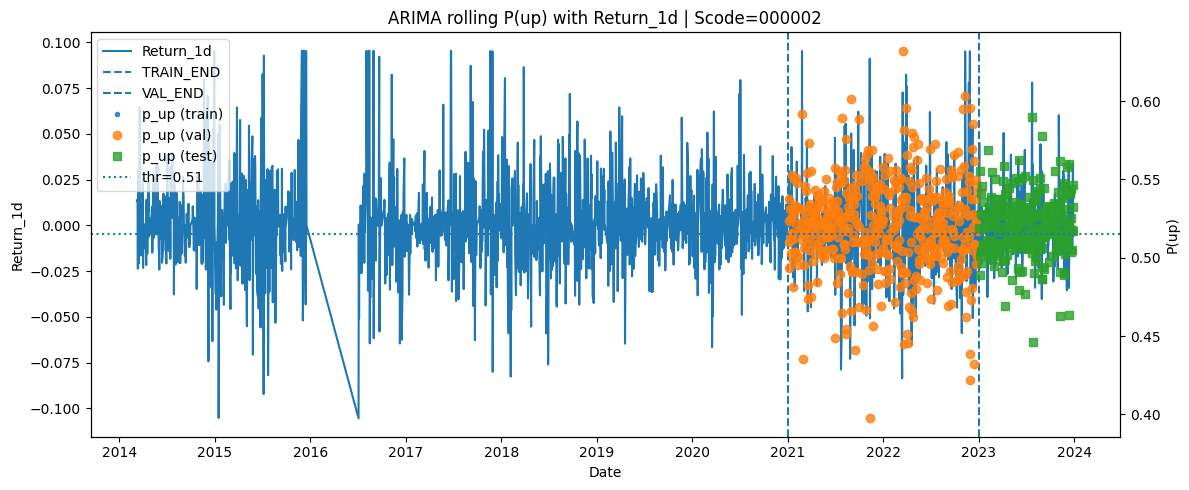

In [21]:
scode = "000002"

df["Scode"] = df["Scode"].astype("string").str.replace(r"\.0$", "", regex=True).str.zfill(6)
g = df[df["Scode"].astype(str) == scode].copy()
g["Date"] = pd.to_datetime(g["Date"], errors="coerce")
g["Return_1d"] = pd.to_numeric(g["Return_1d"], errors="coerce")

train_returns = (
    g[g["Date"] <= TRAIN_END]
    .sort_values("Date")["Return_1d"]
    .dropna()
    .to_numpy()
)

adf_res = adf_test(train_returns)
print("ADF pvalue:", adf_res["pvalue"], "| stationary:", adf_res["stationary"])

if adf_res["stationary"]:
    candidates = [(0,0,0),(1,0,0),(0,0,1),(1,0,1),(2,0,1),(1,0,2)]
else:
    candidates = [(0,1,0),(1,1,0),(0,1,1),(1,1,1),(2,1,1),(1,1,2)]

best_order, best_aic = select_order_by_aic(train_returns, candidates)
print("Selected order:", best_order, "AIC:", best_aic)

pred_df, metrics = arima_predict_with_metrics(
    df_all=df, scode=scode,
    train_end=TRAIN_END, val_end=VAL_END,
    order=best_order,
    date_col="Date", code_col="Scode",
    ret_col="Return_1d", label_col="y_up_1d",
    min_train_returns=30, eps=EPS,
    threshold=None, pick_on="val"
)

print("Best threshold (picked on val):", metrics["threshold"])
print("VAL :", metrics["val"])
print("TEST:", metrics["test"])

plot_arima(
    df_all=df, pred_df=pred_df,
    train_end=TRAIN_END, val_end=VAL_END,
    date_col="Date", code_col="Scode",
    ret_col="Return_1d",
    threshold=metrics["threshold"],
    title_prefix="ARIMA rolling P(up) with Return_1d"
)


ADF pvalue: 4.584704881269822e-22 | stationary: True
Selected order: (2, 0, 1) AIC: -7116.608258620883
train_returns len = 1653
n_pred: {'train': 1, 'val': 485, 'test': 241}
Best threshold (picked on val): 0.51
VAL : {'acc': 0.7690721649484537, 'prec': 0.7346938775510204, 'rec': 0.7929515418502202, 'f1': 0.7627118644067796, 'auc': 0.8271522726496601, 'cm': array([[193,  65],
       [ 47, 180]]), 'tn': np.int64(193), 'fp': np.int64(65), 'fn': np.int64(47), 'tp': np.int64(180), 'threshold': 0.51}
TEST: {'acc': 0.6887966804979253, 'prec': 0.5833333333333334, 'rec': 0.8484848484848485, 'f1': 0.691358024691358, 'auc': 0.777706643903827, 'cm': array([[82, 60],
       [15, 84]]), 'tn': np.int64(82), 'fp': np.int64(60), 'fn': np.int64(15), 'tp': np.int64(84), 'threshold': 0.51}


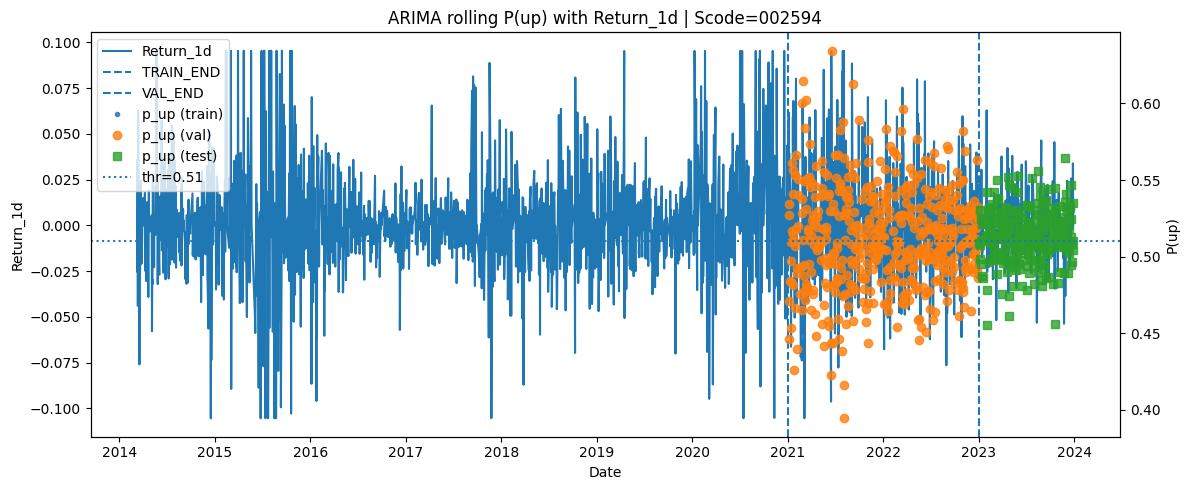

In [14]:
scode = "002594"

df["Scode"] = df["Scode"].astype("string").str.replace(r"\.0$", "", regex=True).str.zfill(6)
g = df[df["Scode"].astype(str) == scode].copy()
g["Date"] = pd.to_datetime(g["Date"], errors="coerce")
g["Return_1d"] = pd.to_numeric(g["Return_1d"], errors="coerce")

train_returns = (
    g[g["Date"] <= TRAIN_END]
    .sort_values("Date")["Return_1d"]
    .dropna()
    .to_numpy()
)

adf_res = adf_test(train_returns)
print("ADF pvalue:", adf_res["pvalue"], "| stationary:", adf_res["stationary"])

if adf_res["stationary"]:
    candidates = [(0,0,0),(1,0,0),(0,0,1),(1,0,1),(2,0,1),(1,0,2)]
else:
    candidates = [(0,1,0),(1,1,0),(0,1,1),(1,1,1),(2,1,1),(1,1,2)]

best_order, best_aic = select_order_by_aic(train_returns, candidates)
print("Selected order:", best_order, "AIC:", best_aic)

pred_df, metrics = arima_predict_with_metrics(
    df_all=df, scode=scode,
    train_end=TRAIN_END, val_end=VAL_END,
    order=best_order,
    date_col="Date", code_col="Scode",
    ret_col="Return_1d", label_col="y_up_1d",
    min_train_returns=30, eps=EPS,
    threshold=None, pick_on="val"
)

print("Best threshold (picked on val):", metrics["threshold"])
print("VAL :", metrics["val"])
print("TEST:", metrics["test"])

plot_arima(
    df_all=df, pred_df=pred_df,
    train_end=TRAIN_END, val_end=VAL_END,
    date_col="Date", code_col="Scode",
    ret_col="Return_1d",
    threshold=metrics["threshold"],
    title_prefix="ARIMA rolling P(up) with Return_1d"
)


ADF pvalue: 0.0 | stationary: True


/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Selected order: (2, 0, 1) AIC: -9056.634511010689
train_returns len = 1663
n_pred: {'train': 1, 'val': 485, 'test': 241}
Best threshold (picked on val): 0.435
VAL : {'acc': 0.4824742268041237, 'prec': 0.46255506607929514, 'rec': 0.967741935483871, 'f1': 0.6259314456035767, 'auc': 0.6168237155237637, 'cm': array([[ 24, 244],
       [  7, 210]]), 'tn': np.int64(24), 'fp': np.int64(244), 'fn': np.int64(7), 'tp': np.int64(210), 'threshold': 0.435}
TEST: {'acc': 0.4896265560165975, 'prec': 0.47555555555555556, 'rec': 0.9553571428571429, 'f1': 0.6350148367952523, 'auc': 0.6209856035437431, 'cm': array([[ 11, 118],
       [  5, 107]]), 'tn': np.int64(11), 'fp': np.int64(118), 'fn': np.int64(5), 'tp': np.int64(107), 'threshold': 0.435}


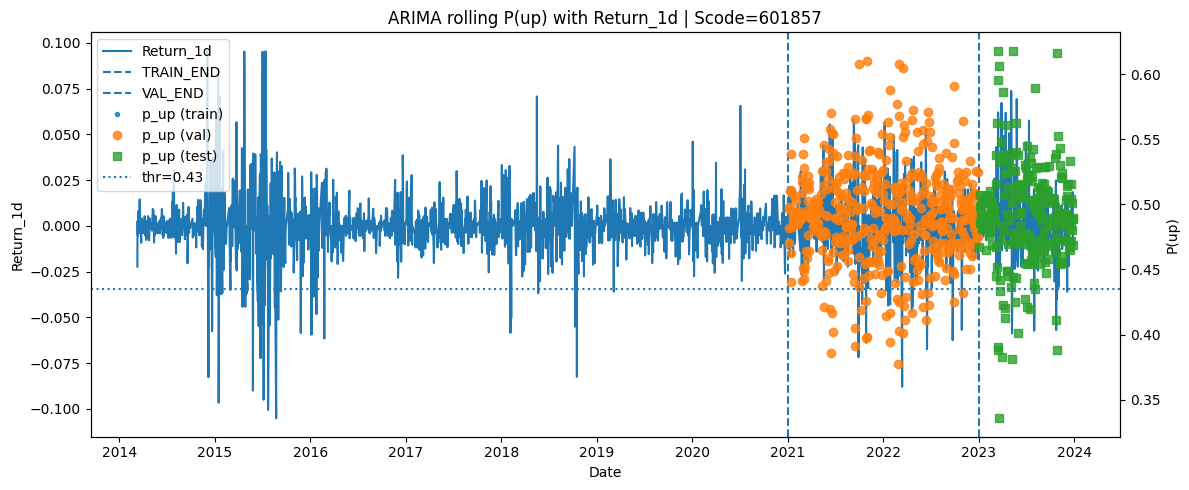

In [15]:
scode = "601857"

df["Scode"] = df["Scode"].astype("string").str.replace(r"\.0$", "", regex=True).str.zfill(6)
g = df[df["Scode"].astype(str) == scode].copy()
g["Date"] = pd.to_datetime(g["Date"], errors="coerce")
g["Return_1d"] = pd.to_numeric(g["Return_1d"], errors="coerce")

train_returns = (
    g[g["Date"] <= TRAIN_END]
    .sort_values("Date")["Return_1d"]
    .dropna()
    .to_numpy()
)

adf_res = adf_test(train_returns)
print("ADF pvalue:", adf_res["pvalue"], "| stationary:", adf_res["stationary"])

if adf_res["stationary"]:
    candidates = [(0,0,0),(1,0,0),(0,0,1),(1,0,1),(2,0,1),(1,0,2)]
else:
    candidates = [(0,1,0),(1,1,0),(0,1,1),(1,1,1),(2,1,1),(1,1,2)]

best_order, best_aic = select_order_by_aic(train_returns, candidates)
print("Selected order:", best_order, "AIC:", best_aic)


pred_df, metrics = arima_predict_with_metrics(
    df_all=df, scode=scode,
    train_end=TRAIN_END, val_end=VAL_END,
    order=best_order,
    date_col="Date", code_col="Scode",
    ret_col="Return_1d", label_col="y_up_1d",
    min_train_returns=30, eps=EPS,
    threshold=None, pick_on="val"
)

print("Best threshold (picked on val):", metrics["threshold"])
print("VAL :", metrics["val"])
print("TEST:", metrics["test"])

plot_arima(
    df_all=df, pred_df=pred_df,
    train_end=TRAIN_END, val_end=VAL_END,
    date_col="Date", code_col="Scode",
    ret_col="Return_1d",
    threshold=metrics["threshold"],
    title_prefix="ARIMA rolling P(up) with Return_1d"
)

ADF pvalue: 0.0 | stationary: True


/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Selected order: (1, 0, 2) AIC: -8446.867203443395
train_returns len = 1663
n_pred: {'train': 1, 'val': 485, 'test': 241}
Best threshold (picked on val): 0.485
VAL : {'acc': 0.4927835051546392, 'prec': 0.4805194805194805, 'rec': 0.9736842105263158, 'f1': 0.6434782608695652, 'auc': 0.5174926616151272, 'cm': array([[ 17, 240],
       [  6, 222]]), 'tn': np.int64(17), 'fp': np.int64(240), 'fn': np.int64(6), 'tp': np.int64(222), 'threshold': 0.485}
TEST: {'acc': 0.4605809128630705, 'prec': 0.4602510460251046, 'rec': 0.990990990990991, 'f1': 0.6285714285714286, 'auc': 0.4911988911988911, 'cm': array([[  1, 129],
       [  1, 110]]), 'tn': np.int64(1), 'fp': np.int64(129), 'fn': np.int64(1), 'tp': np.int64(110), 'threshold': 0.485}


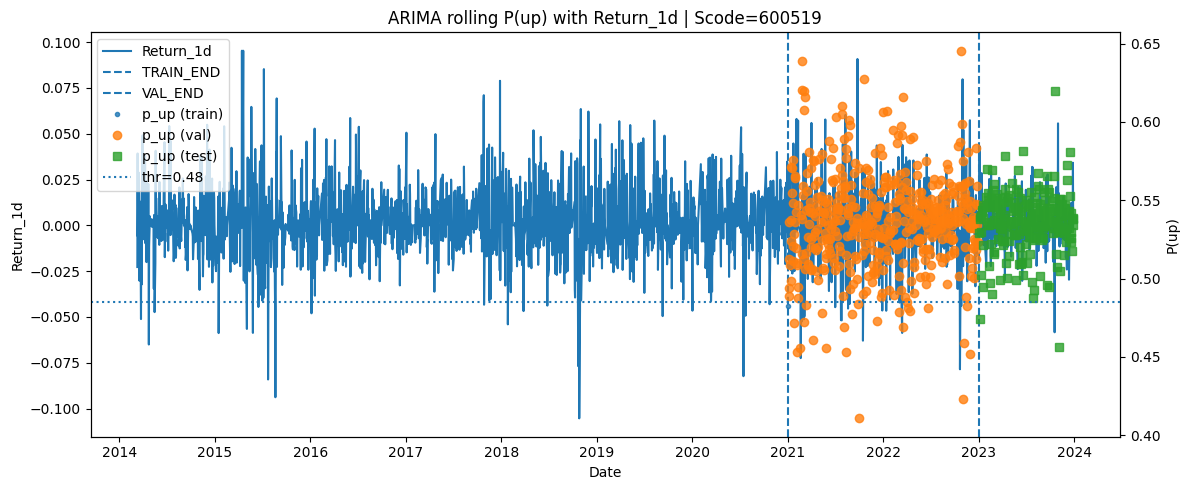

In [16]:
scode = "600519"

df["Scode"] = df["Scode"].astype("string").str.replace(r"\.0$", "", regex=True).str.zfill(6)
g = df[df["Scode"].astype(str) == scode].copy()
g["Date"] = pd.to_datetime(g["Date"], errors="coerce")
g["Return_1d"] = pd.to_numeric(g["Return_1d"], errors="coerce")

train_returns = (
    g[g["Date"] <= TRAIN_END]
    .sort_values("Date")["Return_1d"]
    .dropna()
    .to_numpy()
)

adf_res = adf_test(train_returns)
print("ADF pvalue:", adf_res["pvalue"], "| stationary:", adf_res["stationary"])

if adf_res["stationary"]:
    candidates = [(0,0,0),(1,0,0),(0,0,1),(1,0,1),(2,0,1),(1,0,2)]
else:
    candidates = [(0,1,0),(1,1,0),(0,1,1),(1,1,1),(2,1,1),(1,1,2)]

best_order, best_aic = select_order_by_aic(train_returns, candidates)
print("Selected order:", best_order, "AIC:", best_aic)

pred_df, metrics = arima_predict_with_metrics(
    df_all=df, scode=scode,
    train_end=TRAIN_END, val_end=VAL_END,
    order=best_order,
    date_col="Date", code_col="Scode",
    ret_col="Return_1d", label_col="y_up_1d",
    min_train_returns=30, eps=EPS,
    threshold=None, pick_on="val"
)

print("Best threshold (picked on val):", metrics["threshold"])
print("VAL :", metrics["val"])
print("TEST:", metrics["test"])

plot_arima(
    df_all=df, pred_df=pred_df,
    train_end=TRAIN_END, val_end=VAL_END,
    date_col="Date", code_col="Scode",
    ret_col="Return_1d",
    threshold=metrics["threshold"],
    title_prefix="ARIMA rolling P(up) with Return_1d"
)


ADF pvalue: 2.8312319354007054e-12 | stationary: True
Selected order: (1, 0, 2) AIC: -9012.748187455047
train_returns len = 1663
n_pred: {'train': 1, 'val': 485, 'test': 241}
Best threshold (picked on val): 0.5
VAL : {'acc': 0.6907216494845361, 'prec': 0.6487603305785123, 'rec': 0.7072072072072072, 'f1': 0.6767241379310345, 'auc': 0.7411023190490871, 'cm': array([[178,  85],
       [ 65, 157]]), 'tn': np.int64(178), 'fp': np.int64(85), 'fn': np.int64(65), 'tp': np.int64(157), 'threshold': 0.5}
TEST: {'acc': 0.7136929460580913, 'prec': 0.7068965517241379, 'rec': 0.7008547008547008, 'f1': 0.703862660944206, 'auc': 0.7679211469534051, 'cm': array([[90, 34],
       [35, 82]]), 'tn': np.int64(90), 'fp': np.int64(34), 'fn': np.int64(35), 'tp': np.int64(82), 'threshold': 0.5}


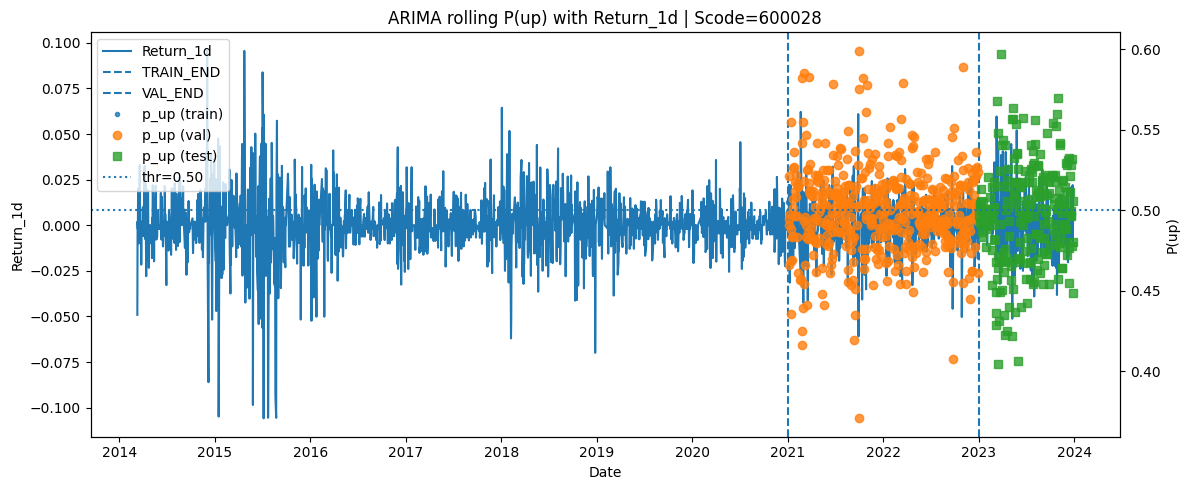

In [17]:
scode = "600028"

df["Scode"] = df["Scode"].astype("string").str.replace(r"\.0$", "", regex=True).str.zfill(6)
g = df[df["Scode"].astype(str) == scode].copy()
g["Date"] = pd.to_datetime(g["Date"], errors="coerce")
g["Return_1d"] = pd.to_numeric(g["Return_1d"], errors="coerce")

train_returns = (
    g[g["Date"] <= TRAIN_END]
    .sort_values("Date")["Return_1d"]
    .dropna()
    .to_numpy()
)

adf_res = adf_test(train_returns)
print("ADF pvalue:", adf_res["pvalue"], "| stationary:", adf_res["stationary"])

if adf_res["stationary"]:
    candidates = [(0,0,0),(1,0,0),(0,0,1),(1,0,1),(2,0,1),(1,0,2)]
else:
    candidates = [(0,1,0),(1,1,0),(0,1,1),(1,1,1),(2,1,1),(1,1,2)]

best_order, best_aic = select_order_by_aic(train_returns, candidates)
print("Selected order:", best_order, "AIC:", best_aic)

pred_df, metrics = arima_predict_with_metrics(
    df_all=df, scode=scode,
    train_end=TRAIN_END, val_end=VAL_END,
    order=best_order,
    date_col="Date", code_col="Scode",
    ret_col="Return_1d", label_col="y_up_1d",
    min_train_returns=30, eps=EPS,
    threshold=None, pick_on="val"
)

print("Best threshold (picked on val):", metrics["threshold"])
print("VAL :", metrics["val"])
print("TEST:", metrics["test"])

plot_arima(
    df_all=df, pred_df=pred_df,
    train_end=TRAIN_END, val_end=VAL_END,
    date_col="Date", code_col="Scode",
    ret_col="Return_1d",
    threshold=metrics["threshold"],
    title_prefix="ARIMA rolling P(up) with Return_1d"
)

In [22]:
def arima_predict_all(
    df_all,
    train_end, val_end,
    order,
    date_col="Date", code_col="Scode",
    ret_col="Return_1d",
    label_col="y_up_1d",
    max_gap_days=3, min_train_returns=30, eps=1e-8,
    codes=None,
    verbose=True
):
    # If codes=None, automatically run for all firms in df_all
    if codes is None:
        codes = (
            df_all[code_col].astype(str)
            .str.extract(r"(\d{6})", expand=False)
            .dropna()
            .unique()
            .tolist()
        )
    else:
        codes = [str(c) for c in codes]
    codes = sorted(codes)

    all_pred = []
    for scode in codes:
        pred_df = arima_predict(
            df_all=df_all, scode=scode,
            train_end=train_end, val_end=val_end,
            order=order,
            date_col=date_col, code_col=code_col,
            ret_col=ret_col, label_col=label_col,
            max_gap_days=max_gap_days, min_train_returns=min_train_returns, eps=eps
        )
        if verbose:
            n = 0 if (pred_df is None) else len(pred_df)
            print(f"[ARIMA] {scode}: n_pred={n}")

        if pred_df is not None and len(pred_df) > 0:
            all_pred.append(pred_df)

    if not all_pred:
        return pd.DataFrame(columns=["Scode", "Date", "split", "y_true", "p_up"])

    pred_df_all = pd.concat(all_pred, ignore_index=True)
    pred_df_all = pred_df_all.sort_values(["Scode", "Date"]).reset_index(drop=True)
    return pred_df_all

def arima_predict_all_with_metrics(
    df_all,
    train_end, val_end,
    order,
    date_col="Date", code_col="Scode",
    ret_col="Return_1d",
    label_col="y_up_1d",
    max_gap_days=3, min_train_returns=30, eps=1e-8,
    codes=None,
    pick_on="val",
    verbose=True
):
    pred_df_all = arima_predict_all(
        df_all=df_all,
        train_end=train_end, val_end=val_end,
        order=order,
        date_col=date_col, code_col=code_col,
        ret_col=ret_col, label_col=label_col,
        max_gap_days=max_gap_days, min_train_returns=min_train_returns, eps=eps,
        codes=codes,
        verbose=verbose
    )

    # Evaluate each firm separately (each firm selects its own threshold)
    metrics_by_code = {}
    for scode, g in pred_df_all.groupby("Scode"):
        metrics_by_code[scode] = evaluate_pred_df(
            g, threshold=None, pick_on=pick_on
        )

    # Global evaluation (all firms jointly select one threshold based on validation set)
    metrics_global = evaluate_pred_df(
        pred_df_all, threshold=None, pick_on=pick_on
    )

    return pred_df_all, metrics_by_code, metrics_global


In [23]:
pred_df_all, metrics_by_code, metrics_global = arima_predict_all_with_metrics(
    df_all=df,
    train_end=TRAIN_END, val_end=VAL_END,
    order=best_order,
    date_col="Date", code_col="Scode",
    ret_col="Return_1d", label_col="y_up_1d",
    min_train_returns=30, eps=EPS,
    codes=None,
    pick_on="val",
    verbose=True
)

print("GLOBAL best threshold:", metrics_global["threshold"])
print("GLOBAL VAL :", metrics_global["val"])
print("GLOBAL TEST:", metrics_global["test"])


train_returns len = 1528
n_pred: {'train': 1, 'val': 485, 'test': 241}
[ARIMA] 000002: n_pred=727
train_returns len = 1653
n_pred: {'train': 1, 'val': 485, 'test': 241}
[ARIMA] 002594: n_pred=727
train_returns len = 1663
n_pred: {'train': 1, 'val': 485, 'test': 241}
[ARIMA] 600028: n_pred=727
train_returns len = 1663
n_pred: {'train': 1, 'val': 485, 'test': 241}
[ARIMA] 600519: n_pred=727
train_returns len = 1663
n_pred: {'train': 1, 'val': 485, 'test': 241}
[ARIMA] 601857: n_pred=727
GLOBAL best threshold: 0.4950000099999999
GLOBAL VAL : {'acc': 0.6004123711340206, 'prec': 0.5421545667447307, 'rec': 0.8319856244384546, 'f1': 0.6565047855370436, 'auc': 0.6846340641640918, 'cm': array([[530, 782],
       [187, 926]]), 'tn': np.int64(530), 'fp': np.int64(782), 'fn': np.int64(187), 'tp': np.int64(926), 'threshold': 0.4950000099999999}
GLOBAL TEST: {'acc': 0.5435684647302904, 'prec': 0.48593073593073594, 'rec': 0.8568702290076335, 'f1': 0.6201657458563536, 'auc': 0.6517918193944693, 'cm': 

## 4. Feature Engineering

In [24]:
train_df, val_df, test_df = split_by_date_drop_unseen(
    df,
    train_end=TRAIN_END,   
    val_end=VAL_END,       
    date_col="Date",
    code_col="Scode",
    forward_horizon_steps=1,  
    verbose=True
)

print("train:", train_df["Date"].min(), "~", train_df["Date"].max())
print("val:",   val_df["Date"].min(),   "~", val_df["Date"].max())
print("test:",  test_df["Date"].min(),  "~", test_df["Date"].max())


Split shapes: train (8170, 48) val (2420, 48) test (1200, 48)
train: 2014-03-11 00:00:00 ~ 2020-12-30 00:00:00
val: 2021-01-04 00:00:00 ~ 2022-12-29 00:00:00
test: 2023-01-03 00:00:00 ~ 2023-12-27 00:00:00


In [25]:
for _df in (train_df, val_df, test_df):
    _df[DATE_COL] = pd.to_datetime(_df[DATE_COL], errors="coerce")
    _df.sort_values(["Scode", DATE_COL], inplace=True)
    _df.reset_index(drop=True, inplace=True)

# Missing-value handling: missing mask -> per-stock forward fill -> train-only imputation
for c in FEATURE_COLS:
    train_df[c + "_miss"] = train_df[c].isna().astype(int)
    val_df[c + "_miss"] = val_df[c].isna().astype(int)
    test_df[c + "_miss"] = test_df[c].isna().astype(int)

# convert to float uniformly
for _df in (train_df, val_df, test_df):
    _df[FEATURE_COLS] = _df[FEATURE_COLS].astype("float64")

price_cols = [c for c in FEATURE_COLS if c not in SENT_COLS]

def ffill_by_code_time(df: pd.DataFrame, cols, code_col="Scode", date_col=DATE_COL):
    df = df.sort_values([code_col, date_col]).copy()
    df[cols] = df.groupby(code_col, sort=False)[cols].ffill()
    return df
    
train_df = ffill_by_code_time(train_df, price_cols)
val_df   = ffill_by_code_time(val_df, price_cols)
test_df  = ffill_by_code_time(test_df, price_cols)

# 情绪/新闻特征缺失填 0
for _df in (train_df, val_df, test_df):
    _df[SENT_COLS] = _df[SENT_COLS].fillna(0)

# Train-only 数值插补，median 只从 train 学
train_median = train_df[price_cols].median(numeric_only=True)
train_df[price_cols] = train_df[price_cols].fillna(train_median)
val_df[price_cols]   = val_df[price_cols].fillna(train_median)
test_df[price_cols]  = test_df[price_cols].fillna(train_median)

def assert_finite(name, df, cols):
    arr = df[cols].to_numpy()
    if not np.isfinite(arr).all():
        bad = np.argwhere(~np.isfinite(arr))
        raise ValueError(
            f"[{name}] Found non-finite values in features. Example index: {bad[:5]}"
        )

assert_finite("train(pre-transform)", train_df, FEATURE_COLS)
assert_finite("val(pre-transform)", val_df, FEATURE_COLS)
assert_finite("test(pre-transform)", test_df, FEATURE_COLS)

# Extreme-value handling: train-only thresholds, then applied to val/test;
# apply log1p first, then clip
for col in LOG_TARGETS:
    if col in FEATURE_COLS:
        train_df[col] = np.log1p(train_df[col].clip(lower=0))
        val_df[col]   = np.log1p(val_df[col].clip(lower=0))
        test_df[col]  = np.log1p(test_df[col].clip(lower=0))

code_thresholds = {}
global_low = train_df[FEATURE_COLS].quantile(0.01)
global_high = train_df[FEATURE_COLS].quantile(0.99)
global_high = np.maximum(global_high, global_low)

for code, g in train_df.groupby("Scode"):
    if len(g) >= MIN_TRAIN_ROWS_PER_CODE:
        low = g[FEATURE_COLS].quantile(0.01).fillna(global_low)
        high = g[FEATURE_COLS].quantile(0.99).fillna(global_high)
    else:
        low, high = global_low, global_high
    high = np.maximum(high, low)
    code_thresholds[code] = (low, high)

def apply_clip(d: pd.DataFrame) -> pd.DataFrame:
    d = d.copy()
    for code, idx in d.groupby("Scode").groups.items():
        low, high = code_thresholds.get(code, (global_low, global_high))
        d.loc[idx, FEATURE_COLS] = d.loc[idx, FEATURE_COLS].clip(
            lower=low, upper=high, axis=1
        )
    return d

train_df = apply_clip(train_df)
val_df   = apply_clip(val_df)
test_df  = apply_clip(test_df)

assert_finite("train(post-clip)", train_df, FEATURE_COLS)
assert_finite("val(post-clip)", val_df, FEATURE_COLS)
assert_finite("test(post-clip)", test_df, FEATURE_COLS)

def apply_log1p(df, cols):
    df = df.copy()
    for col in cols:
        if col in df.columns:
            df[col] = np.log1p(df[col].clip(lower=0))
    return df

# Apply only to columns that are in LOG_TARGETS and also exist in FEATURE_COLS
log_cols = [c for c in LOG_TARGETS if c in FEATURE_COLS]
train_df = apply_log1p(train_df, log_cols)
val_df   = apply_log1p(val_df, log_cols)
test_df  = apply_log1p(test_df, log_cols)

# Clip / Winsorize: explicitly fit on the training set and then apply,
# to prevent information leakage caused by recomputing quantiles for each split
def fit_clip_thresholds(
    train_df: pd.DataFrame,
    feature_cols,
    code_col="Scode",
    q_low=0.01,
    q_high=0.99,
    min_rows_per_code=50,
):
    global_low  = train_df[feature_cols].quantile(q_low)
    global_high = train_df[feature_cols].quantile(q_high)
    global_high = np.maximum(global_high, global_low)

    code_thresholds = {}
    for code, g in train_df.groupby(code_col, sort=False):
        if len(g) >= min_rows_per_code:
            low  = g[feature_cols].quantile(q_low).fillna(global_low)
            high = g[feature_cols].quantile(q_high).fillna(global_high)
        else:
            low, high = global_low, global_high

        high = np.maximum(high, low)
        code_thresholds[code] = (low, high)

    return {
        "global_low": global_low,
        "global_high": global_high,
        "code_thresholds": code_thresholds,
        "feature_cols": list(feature_cols),
        "code_col": code_col,
    }

def apply_clip_thresholds(df: pd.DataFrame, clip_params: dict):
    df = df.copy()
    feature_cols = clip_params["feature_cols"]
    code_col = clip_params["code_col"]
    global_low = clip_params["global_low"]
    global_high = clip_params["global_high"]
    code_thresholds = clip_params["code_thresholds"]

    for code, idx in df.groupby(code_col, sort=False).groups.items():
        low, high = code_thresholds.get(code, (global_low, global_high))
        df.loc[idx, feature_cols] = df.loc[idx, feature_cols].clip(
            lower=low, upper=high, axis=1
        )
    return df

clip_params = fit_clip_thresholds(
    train_df,
    FEATURE_COLS,
    code_col="Scode",
    q_low=0.01,
    q_high=0.99,
    min_rows_per_code=MIN_TRAIN_ROWS_PER_CODE,
)

train_df = apply_clip_thresholds(train_df, clip_params)
val_df   = apply_clip_thresholds(val_df, clip_params)
test_df  = apply_clip_thresholds(test_df, clip_params)

assert_finite("train(post-clip)", train_df, FEATURE_COLS)
assert_finite("val(post-clip)", val_df, FEATURE_COLS)
assert_finite("test(post-clip)", test_df, FEATURE_COLS)

# Standardization: per-company scaler trained on train only, fallback to global
global_scaler = StandardScaler()
global_scaler.fit(train_df[FEATURE_COLS].values)

stats = {"ok": 0, "fallback_global_small_n": 0, "fallback_global_low_var": 0}
scalers = {}

for code, g in train_df.groupby("Scode", sort=False):
    idx_train = g.index
    train_data = train_df.loc[idx_train, FEATURE_COLS].to_numpy()

    # The sample size is too small, so a global approach is used
    if train_data.shape[0] < MIN_TRAIN_ROWS_PER_CODE:
        train_df.loc[idx_train, FEATURE_COLS] = global_scaler.transform(train_data)

        for _df in (val_df, test_df):
            idx = _df.index[_df["Scode"] == code]
            if len(idx) > 0:
                _df.loc[idx, FEATURE_COLS] = global_scaler.transform(
                    _df.loc[idx, FEATURE_COLS].to_numpy()
                )

        stats["fallback_global_small_n"] += 1
        continue

    # Variance too small: use global statistics and synchronize them to the validation and test sets
    if np.min(np.std(train_data, axis=0)) < EPS:
        train_df.loc[idx_train, FEATURE_COLS] = global_scaler.transform(train_data)

        for _df in (val_df, test_df):
            idx = _df.index[_df["Scode"] == code]
            if len(idx) > 0:
                _df.loc[idx, FEATURE_COLS] = global_scaler.transform(
                    _df.loc[idx, FEATURE_COLS].to_numpy()
                )

        stats["fallback_global_low_var"] += 1
        continue

    # per-code scaler
    sc = StandardScaler()
    sc.fit(train_data)
    scalers[code] = sc
    stats["ok"] += 1

    train_df.loc[idx_train, FEATURE_COLS] = sc.transform(train_data)

    for _df in (val_df, test_df):
        idx = _df.index[_df["Scode"] == code]
        if len(idx) > 0:
            _df.loc[idx, FEATURE_COLS] = sc.transform(
                _df.loc[idx, FEATURE_COLS].to_numpy()
            )

print("scaler summary:", stats)

assert_finite("train(post-scale)", train_df, FEATURE_COLS)
assert_finite("val(post-scale)", val_df, FEATURE_COLS)
assert_finite("test(post-scale)", test_df, FEATURE_COLS)

print("Ready for model training (features standardized, train-fit preprocessing).")    


scaler summary: {'ok': 2, 'fallback_global_small_n': 0, 'fallback_global_low_var': 3}
Ready for model training (features standardized, train-fit preprocessing).


In [26]:
# build windows 
def make_windows(
    df_part,
    feature_cols,
    lag,
    code_col="Scode",
    date_col="Date",
    label_col="y_up_1d",
    forward_horizon_steps=0,         # label at end + horizon
    code2id=None,                    # if None: build from df_part (use for train)
    drop_unseen_codes=True,          # for val/test when code2id provided
    enforce_binary_label=False,      # optional: check labels are 0/1
):
    X_list, y_list, scode_list, date_list = [], [], [], []

    # ensure datetime once
    d = df_part.copy()
    d[date_col] = pd.to_datetime(d[date_col], errors="coerce")
    d = d.dropna(subset=[code_col, date_col, label_col])

    # iterate per stock
    for scode, g in d.groupby(code_col, sort=False):
        g = g.sort_values(date_col).reset_index(drop=True)

        # need enough rows for (lag window) + (horizon label)
        min_len = lag + forward_horizon_steps
        if len(g) < min_len:
            continue
            
        Xg = g[feature_cols].to_numpy(dtype=np.float32)        # (T, F)
        yg = g[label_col].to_numpy(dtype=np.int64)             # (T,)
        dg = g[date_col].to_numpy(dtype="datetime64[ns]")      # (T,)

        # windows end at 'end', label at 'end + horizon'
        last_end = len(g) - forward_horizon_steps - 1
        for end in range(lag - 1, last_end + 1):
            start = end - lag + 1
            label_idx = end + forward_horizon_steps

            # defensive alignment check
            if forward_horizon_steps > 0:
                if not (dg[label_idx] > dg[end]):
                    raise AssertionError(
                        f"Label date not after window end date for code={scode}. "
                        f"end={dg[end]}, label={dg[label_idx]}, horizon={forward_horizon_steps}"
                    )

            y_val = yg[label_idx]
            if enforce_binary_label and (y_val not in (0, 1)):
                raise AssertionError(
                    f"Non-binary label found for code={scode} at {dg[label_idx]}: {y_val}"
                )
                
            X_list.append(Xg[start:end + 1])   # (lag, F) ending at end
            y_list.append(y_val)              # label at end+horizon
            scode_list.append(str(scode))
            date_list.append(dg[end])         # window end date

    # empty case
    if len(X_list) == 0:
        X = torch.empty((0, lag, len(feature_cols)), dtype=torch.float32)
        y = torch.empty((0,), dtype=torch.long)
        sc = torch.empty((0,), dtype=torch.long)
        dt = torch.empty((0,), dtype=torch.long)
        return TensorDataset(X, y, sc, dt), (code2id or {}), {v: k for k, v in (code2id or {}).items()}

    # build or reuse code mapping
    built_here = False
    if code2id is None:
        uniq_codes = sorted(set(scode_list))
        code2id = {c: i for i, c in enumerate(uniq_codes)}
        built_here = True

    # handle unseen codes if mapping provided 
    if (not built_here) and drop_unseen_codes:
        keep_idx = [i for i, c in enumerate(scode_list) if c in code2id]
        if len(keep_idx) < len(scode_list):
            X_list = [X_list[i] for i in keep_idx]
            y_list = [y_list[i] for i in keep_idx]
            scode_list = [scode_list[i] for i in keep_idx]
            date_list = [date_list[i] for i in keep_idx]

    # if still any unseen remain, fail loudly 
    if any(c not in code2id for c in scode_list):
        unseen = sorted({c for c in scode_list if c not in code2id})
        raise ValueError(f"Found unseen codes not in code2id: {unseen[:10]} (showing up to 10)")

    id2code = {i: c for c, i in code2id.items()}

    scode_id = np.array([code2id[c] for c in scode_list], dtype=np.int64)
    date_ns  = np.array(date_list, dtype="datetime64[ns]").astype("int64")

    X = torch.from_numpy(np.stack(X_list)).float()
    y = torch.from_numpy(np.array(y_list, dtype=np.int64)).long()
    sc = torch.from_numpy(scode_id).long()
    dt = torch.from_numpy(date_ns).long()

    return TensorDataset(X, y, sc, dt), code2id, id2code

# build datasets
train_set, code2id, id2code = make_windows(
    train_df, FEATURE_COLS, LAG,
    code_col="Scode", date_col="Date", label_col="y_up_1d",
    forward_horizon_steps=0,         # y_up_1d already represents the label for t corresponding to t+1, so it is kept as 0
    code2id=None
)

val_set, _, _ = make_windows(
    val_df, FEATURE_COLS, LAG,
    code_col="Scode", date_col="Date", label_col="y_up_1d",
    forward_horizon_steps=0,
    code2id=code2id,                 # Reuse the training-set mapping to avoid introducing new IDs in the validation/test sets
    drop_unseen_codes=True
)

test_set, _, _ = make_windows(
    test_df, FEATURE_COLS, LAG,
    code_col="Scode", date_col="Date", label_col="y_up_1d",
    forward_horizon_steps=0,
    code2id=code2id,
    drop_unseen_codes=True
)

print("Train/Val/Test windows:", len(train_set), len(val_set), len(test_set))
if len(train_set) > 0:
    print("One sample:", train_set[0][0].shape, train_set[0][1].shape)
else:
    print("train_set is empty")

Train/Val/Test windows: 8150 2400 1180
One sample: torch.Size([5, 29]) torch.Size([])


In [27]:
batch_size = 64
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_set,   batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_set,  batch_size=batch_size, shuffle=False)

# 3. Intra-modal feature extraction

## 3.1 Price modality: the LSTM encoder extracts temporal features

In [28]:
n_price = len(price_cols)
n_news  = len(SENT_COLS)

class PriceLSTMEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim=32, num_layers=1, dropout=0.0):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            batch_first=True,
            num_layers=num_layers,
            dropout=(dropout if num_layers > 1 else 0.0), 
        )

    def forward(self, x_price):
        """
        x_price: (B, L, D_price)
        return:  (B, hidden_dim)
        """
        out, (h_n, c_n) = self.lstm(x_price)
        h_price = h_n[-1]   # (B, hidden_dim)
        return h_price


## 3.2 News modality: the MLP encoder extracts a nonlinear sentiment representation

In [29]:
class NewsCNNEncoder(nn.Module):
    """
    x_news: (B, L, D_news)
    Output: (B, out_dim)
    """
    def __init__(
        self,
        input_dim,
        out_dim=32,
        channels=64,
        kernel_size=3,
        dropout=0.5,
        pooling="avg"  
    ):
        super().__init__()
        assert kernel_size % 2 == 1, "Use odd kernel_size to keep length with padding"

        self.pooling = pooling

        # Conv1d (B, C_in, L)
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels=input_dim, out_channels=channels, kernel_size=kernel_size,
                      padding=kernel_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Conv1d(in_channels=channels, out_channels=channels, kernel_size=kernel_size,
                      padding=kernel_size // 2),
            nn.ReLU(),
        )

        self.proj = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(channels, out_dim),
            nn.ReLU()
        )

    def forward(self, x_news):
        # x_news: (B, L, D_news) -> (B, D_news, L)
        x = x_news.transpose(1, 2).contiguous()
        h = self.conv(x)  # (B, channels, L)

        if self.pooling == "max":
            h = h.max(dim=-1).values  # (B, channels)
        else:
            h = h.mean(dim=-1)        # (B, channels) 
        h_news = self.proj(h)         # (B, out_dim)
        return h_news           


# 4.Early Fusion Predictor

In [30]:
class EarlyFusionPredictor(nn.Module):
    """
    Gated Early Fusion:
    g = sigmoid(W_g [h_price; h_news])
    h = g * h_price + (1 - g) * h_news
    """
    def __init__(self, n_price, n_news, price_hidden_dim=32, news_hidden_dim=32, fusion_dim=32, dropout=0.5):
        super().__init__()
        self.n_price = n_price
        self.n_news  = n_news

        self.price_encoder = PriceLSTMEncoder(input_dim=n_price,hidden_dim=price_hidden_dim)
        self.news_encoder = NewsCNNEncoder(input_dim=n_news,out_dim=news_hidden_dim,dropout=dropout)

        # Project to same fusion_dim
        self.price_proj = nn.Linear(price_hidden_dim, fusion_dim)
        self.news_proj  = nn.Linear(news_hidden_dim,  fusion_dim)

        # Gating network 
        self.gate = nn.Sequential(
            nn.Linear(2 * fusion_dim, fusion_dim),
            nn.Sigmoid()
        )

        self.norm = nn.LayerNorm(fusion_dim)

        # Prediction head 
        self.head = nn.Sequential(
            nn.Linear(fusion_dim, fusion_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(fusion_dim, 2)
        )


    def forward(self, X):
        # X: (B, L, n_price+n_news)
        x_price = X[..., :self.n_price]           # (B, L, n_price)
        x_news  = X[..., self.n_price:self.n_price+self.n_news]  # (B, L, n_news)

        h_price = self.price_encoder(x_price)     # (B, price_hidden_dim)
        h_news  = self.news_encoder(x_news)       # (B, news_out_dim)

        # Project to fusion_dim
        p = self.price_proj(h_price)            # (B, fusion_dim)
        n = self.news_proj(h_news)              # (B, fusion_dim)

        # Gate + fuse
        g = self.gate(torch.cat([p, n], dim=-1))   
        h = g * p + (1.0 - g) * n                  # (B, fusion_dim)

        h = self.norm(h)
        return self.head(h)                       # (B, out_dim)


In [31]:
class NewsCNNSeqEncoder(nn.Module):
    """
    CNN that outputs per-time-step features for attention.
    Input:  x_news (B,L,D_news)
    Output: hn_seq (B,L,d_model)
    """
    def __init__(self, input_dim, d_model=32, channels=64, kernel_size=3, dropout=0.5):
        super().__init__()
        assert kernel_size % 2 == 1

        self.conv = nn.Sequential(
            nn.Conv1d(input_dim, channels, kernel_size, padding=kernel_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Conv1d(channels, d_model, kernel_size, padding=kernel_size // 2),
            nn.ReLU(),
        )

    def forward(self, x_news):
        # (B,L,Dn) -> (B,Dn,L)
        x = x_news.transpose(1, 2).contiguous()
        h = self.conv(x)               # (B,d_model,L)
        return h.transpose(1, 2).contiguous()  # (B,L,d_model)


class MidFusionPredictor(nn.Module):
    """
    price -> LSTM -> hp_seq (B,L,Hp) -> proj -> q (B,L,d_model)
    news  -> CNN  -> hn_seq (B,L,d_model) -> k/v
    cross-attn(q,k,v) -> mean pool -> head -> logits (B,2)
    """
    def __init__(
        self, n_price, n_news,
        price_hidden_dim=32,
        d_model=32, num_heads=4,
        dropout=0.5,
        news_cnn_channels=64,
        news_kernel_size=3,
    ):
        super().__init__()
        assert d_model % num_heads == 0
        self.n_price = n_price
        self.n_news  = n_news

        self.price_seq = nn.LSTM(n_price, price_hidden_dim, batch_first=True)
        self.price_proj = nn.Linear(price_hidden_dim, d_model)

        self.news_seq = NewsCNNSeqEncoder(
            input_dim=n_news,
            d_model=d_model,
            channels=news_cnn_channels,
            kernel_size=news_kernel_size,
            dropout=dropout,
        )

        self.cross_attn = nn.MultiheadAttention(
            embed_dim=d_model, num_heads=num_heads, dropout=dropout, batch_first=True
        )
        self.attn_drop = nn.Dropout(dropout)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

        self.head = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, 2)
        )

    def forward(self, X):
        x_price = X[..., :self.n_price]  # (B,L,n_price)
        x_news  = X[..., self.n_price:self.n_price + self.n_news]  # (B,L,n_news)

        hp_seq, _ = self.price_seq(x_price)      # (B,L,Hp)
        q = self.price_proj(hp_seq)              # (B,L,d_model)

        hn_seq = self.news_seq(x_news)           # (B,L,d_model)
        k = hn_seq
        v = hn_seq

        attn_out, _ = self.cross_attn(q, k, v)   # (B,L,d_model)
        h = self.norm1(q + self.attn_drop(attn_out))

        z = h.mean(dim=1)                        # (B,d_model)
        z = self.norm2(z)
        return self.head(z)                      # (B,2)


In [32]:
# Price branch: use only price features to output price_logit
class PriceOnlyPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim=32, dropout=0.5):
        super().__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, batch_first=True)
        self.head = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, 2)
        )

    def forward(self, x_price):
        # x_price: (B,L,Dp)
        _, (h_n, _) = self.lstm(x_price)
        h = h_n[-1]                # (B,hidden_dim)
        return self.head(h)        # (B,2) price_logit


# News branch: use only news features to output news_logit 
class NewsOnlyPredictor(nn.Module):
    def __init__(
        self, input_dim, cnn_out_dim=32,
        cnn_channels=64, kernel_size=3, dropout=0.5, pooling="avg",
    ):
        super().__init__()
        self.encoder = NewsCNNEncoder(
            input_dim=input_dim,
            out_dim=cnn_out_dim,
            channels=cnn_channels,
            kernel_size=kernel_size,
            dropout=dropout,
            pooling=pooling,
        )
        self.head = nn.Sequential(
            nn.Linear(cnn_out_dim, cnn_out_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(cnn_out_dim, 2)
        )
        
    def forward(self, x_news):
        # x_news: (B,L,Dn)
        h = self.encoder(x_news)   # (B,out_dim)
        return self.head(h)        # (B,2)

# Late fusion: fuse the two branches' "prediction outputs" 
class LateFusionPredictor(nn.Module):
    """
    Weighted late fusion on logits:
    final_logits = w0 * price_logits + w1 * news_logits + b
    where w = softmax([w0_raw, w1_raw]).
    """
    def __init__(
        self, n_price, n_news, price_hidden=32, 
        news_cnn_out=32, news_cnn_channels=64, news_kernel_size=3,
        dropout=0.5,
    ):
        super().__init__()
        self.n_price = n_price
        self.n_news = n_news

        self.price_model = PriceOnlyPredictor(input_dim=n_price, hidden_dim=price_hidden, dropout=dropout)
        self.news_model  = NewsOnlyPredictor(
            input_dim=n_news, 
            cnn_out_dim=news_cnn_out, 
            cnn_channels=news_cnn_channels, 
            kernel_size=news_kernel_size,
            dropout=dropout
        )

        # Modality weights (raw); transformed by softmax during training to be positive and sum to 1
        self.w = nn.Parameter(torch.tensor([0.0, 0.0], dtype=torch.float32))  # initial softmax is [0.5, 0.5]
        # One bias per class
        self.bias = nn.Parameter(torch.zeros(2, dtype=torch.float32))

    def forward(self, X):
        # X: (B,L,Dtotal)
        x_price = X[..., :self.n_price]
        x_news  = X[..., self.n_price:self.n_price+self.n_news]

        price_logit = self.price_model(x_price)  
        news_logit  = self.news_model(x_news)     

        w = torch.softmax(self.w, dim=0)         
        final_logits = w[0] * price_logit + w[1] * news_logit + self.bias  
        return final_logits


In [33]:
def Loss_function(train_set, device, max_pos_w=10.0, verbose=True):
    """
    Build CrossEntropyLoss with class weights from TRAIN only
    """
    y = train_set.tensors[1]
    y = y.detach().cpu().numpy().reshape(-1)

    # keep only valid 0/1 labels
    m = (y == 0) | (y == 1)
    y = y[m].astype(int)

    pos = int((y == 1).sum())
    neg = int((y == 0).sum())

    if verbose:
        print(f"[Loss] train labels: pos={pos}, neg={neg}")

    if pos > 0 and neg > 0:
        pos_w = min(neg / max(pos, 1), float(max_pos_w))
        w = torch.tensor([1.0, pos_w], dtype=torch.float32, device=device)
        if verbose:
            print(f"[Loss] class weight = [1.0, {pos_w:.4f}] (cap={max_pos_w})")
        return nn.CrossEntropyLoss(weight=w)

    if verbose:
        print("[Loss] WARNING: only one class in train; using unweighted CE.")
    return nn.CrossEntropyLoss()
    
def train_one_epoch(model, loader, optimizer, criterion, device, clip_norm=1.0):
    model.train()
    total_loss, total_n = 0.0, 0
    
    for batch in loader:
        X = batch[0].to(device)
        y = batch[1].to(device).long()

        optimizer.zero_grad(set_to_none=True)
        logits = model(X)              
        loss = criterion(logits, y)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=clip_norm)
        optimizer.step()

        bs = y.size(0)
        total_loss += float(loss.item()) * bs
        total_n += bs
        
    return total_loss / total_n

@torch.no_grad()
def eval_loss(model, loader, criterion, device):
    model.eval()
    total_loss, total_n = 0.0, 0
    
    for batch in loader:
        X = batch[0].to(device)              # (B,L,F)
        y = batch[1].to(device).long() 
        
        logits = model(X)              # (B,2)
        loss = criterion(logits, y)
        
        bs = y.size(0)
        total_loss += float(loss.item()) * bs
        total_n += bs
    return total_loss / total_n
    

In [34]:
@torch.no_grad()
def collect_probs(model, loader, device):
    model.eval()
    y_true_list, y_prob_list = [], []
    
    for batch in loader:
        X = batch[0].to(device)
        y = batch[1].to(device).long()

        logits = model(X)                          
        probs = torch.softmax(logits, dim=1)[:, 1] 
        
        y_true_list.append(y.detach().cpu().numpy().astype(int))
        y_prob_list.append(probs.detach().cpu().numpy().astype(float))

    if len(y_true_list) == 0:
        return np.array([], dtype=int), np.array([], dtype=float)
        
    y_true = np.concatenate(y_true_list).astype(int)
    y_prob = np.concatenate(y_prob_list).astype(float)
    return y_true, y_prob

def train_select(
    model_name,
    model,
    train_set,
    train_loader, val_loader, test_loader,
    epochs=100, lr=1e-4, threshold=None,
    clip_norm=1.0, patience=15, device=None,
    thr_metric="f1", min_tnr=0.05, grid=201
):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)

    criterion = Loss_function(train_set, device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-2) 

    best_val_loss = float("inf")
    best_state = None
    history = []

    # Early Stopping Variables
    patience_counter = 0
    for epoch in range(1, epochs + 1):
        tr_loss = train_one_epoch(model, train_loader, optimizer, criterion, device, clip_norm=clip_norm)
        va_loss = eval_loss(model, val_loader, criterion, device)

        # Check for improvement
        if np.isfinite(va_loss) and (va_loss < best_val_loss):
            best_val_loss = va_loss
            best_state = copy.deepcopy(model.state_dict())
            patience_counter = 0  # Reset counter if improvement found
        else:
            patience_counter += 1 # Increment counter if no improvement

        history.append({"epoch": epoch, "train_loss": tr_loss, "val_loss": va_loss})
        print(f"[{model_name}] Epoch {epoch:02d} | Train {tr_loss:.4f} | Val {va_loss:.4f} | BestVal {best_val_loss:.4f}")

        # Check Early Stopping condition
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch}!")
            break
            
    if best_state is not None:
        model.load_state_dict(best_state)

    # best val loss
    yv_true, yv_prob = collect_probs(model, val_loader, device)
    yt_true, yt_prob = collect_probs(model, test_loader, device)

    # choose threshold 
    if threshold is None:
        if yv_true.size == 0 or np.unique(yv_true).size < 2:
            best_t = 0.5
        else:
            best_t, _ = select_threshold(
                yv_true, yv_prob,
                metric=thr_metric,
                min_tnr=min_tnr,
                grid=grid
            )
    else:
        best_t = float(threshold)
    
    val_metrics = compute_metrics(yv_true, yv_prob, threshold=best_t)
    test_metrics = compute_metrics(yt_true, yt_prob, threshold=best_t)

    val_metrics["threshold"] = best_t
    test_metrics["threshold"] = best_t

    return model, pd.DataFrame(history), best_val_loss, val_metrics, test_metrics


In [35]:
def run_models(
    n_price, n_news,
    train_set, train_loader, val_loader, test_loader,
    epochs=100, lr=1e-4, threshold=None, patience=15, device=None,
    thr_metric="f1", min_tnr=0.05, grid=201,    
):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    models = {
        "Early": EarlyFusionPredictor(
            n_price, n_news, 
            price_hidden_dim=32, 
            news_hidden_dim=32, 
            fusion_dim=32, 
            dropout=0.5
        ),
        "Mid": MidFusionPredictor(
            n_price=n_price, n_news=n_news, 
            price_hidden_dim=32, 
            d_model=32, num_heads=4, 
            dropout=0.5
        ),
        "Late": LateFusionPredictor(
            n_price=n_price, n_news=n_news, 
            price_hidden=32,  
            dropout=0.5
        ),
    }

    results = []
    trained_models = {}
    histories = {}

    for name, model in models.items():
        print("\n" + "="*60)
        print(f"Training {name} (select best by min val loss)")
        print("="*60)

        trained_model, hist_df, best_val_loss, val_m, test_m = train_select(
            model_name=name,
            model=model,
            train_set=train_set,
            train_loader=train_loader,
            val_loader=val_loader,
            test_loader=test_loader,
            epochs=epochs,
            lr=lr,
            threshold=threshold,
            patience=patience,
            device=device,
            thr_metric=thr_metric,
            min_tnr=min_tnr,
            grid=grid,
        )

        trained_models[name] = trained_model
        histories[name] = hist_df

        results.append({
            "model": name,
            "best_val_loss": best_val_loss,
            "val": val_m,
            "test": test_m
        })

    # Build summary table
    rows = []
    split_order = {"val": 0, "test": 1}

    for r in results:
        for split in ["val", "test"]:
            m = r.get(split, {})

            # If the threshold does not exist, use the default value passed in
            used_thr = m.get("threshold", np.nan)
            cm = m.get("cm", None)
            if isinstance(cm, np.ndarray) and cm.shape == (2, 2) and np.isfinite(cm).all():
                tn, fp = int(cm[0, 0]), int(cm[0, 1])
                fn, tp = int(cm[1, 0]), int(cm[1, 1])
            else:
                tn = fp = fn = tp = np.nan
                
            rows.append({
                "model": r["model"],
                "split": split,
                "split_rank": split_order.get(split, 99),
                "best_val_loss": r["best_val_loss"],
                "threshold": used_thr,
                "acc": m.get("acc", np.nan),
                "prec": m.get("prec", np.nan),
                "rec": m.get("rec", np.nan),
                "f1": m.get("f1", np.nan),
                "auc": m.get("auc", np.nan),
                "tn": tn, "fp": fp, "fn": fn, "tp": tp
            })
            
    summary_df = pd.DataFrame(rows)
    summary_df = summary_df.sort_values(["split_rank", "f1"], ascending=[True, False]).reset_index(drop=True)
    summary_df = summary_df.drop(columns=["split_rank"])

    test_df = summary_df[summary_df["split"] == "test"].sort_values("f1", ascending=False).reset_index(drop=True)
    
    return results, summary_df, test_df, trained_models, histories


In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

results, df_results, df_test, trained_models, histories = run_models(
    n_price=n_price,
    n_news=n_news,
    train_set=train_set,
    train_loader=train_loader,
    val_loader=val_loader,
    test_loader=test_loader,
    epochs=100,
    lr=1e-4,
    threshold=None,
    patience=15,
    device=device,
    thr_metric="f1",
    min_tnr=0.05,
    grid=201
)



Training Early (select best by min val loss)
[Loss] train labels: pos=3814, neg=4336
[Loss] class weight = [1.0, 1.1369] (cap=10.0)
[Early] Epoch 01 | Train 0.7016 | Val 0.6956 | BestVal 0.6956
[Early] Epoch 02 | Train 0.6956 | Val 0.6943 | BestVal 0.6943
[Early] Epoch 03 | Train 0.6952 | Val 0.6937 | BestVal 0.6937
[Early] Epoch 04 | Train 0.6937 | Val 0.6932 | BestVal 0.6932
[Early] Epoch 05 | Train 0.6933 | Val 0.6931 | BestVal 0.6931
[Early] Epoch 06 | Train 0.6930 | Val 0.6928 | BestVal 0.6928
[Early] Epoch 07 | Train 0.6931 | Val 0.6927 | BestVal 0.6927
[Early] Epoch 08 | Train 0.6919 | Val 0.6924 | BestVal 0.6924
[Early] Epoch 09 | Train 0.6922 | Val 0.6927 | BestVal 0.6924
[Early] Epoch 10 | Train 0.6922 | Val 0.6925 | BestVal 0.6924
[Early] Epoch 11 | Train 0.6917 | Val 0.6923 | BestVal 0.6923
[Early] Epoch 12 | Train 0.6918 | Val 0.6923 | BestVal 0.6923
[Early] Epoch 13 | Train 0.6920 | Val 0.6922 | BestVal 0.6922
[Early] Epoch 14 | Train 0.6923 | Val 0.6924 | BestVal 0.6922

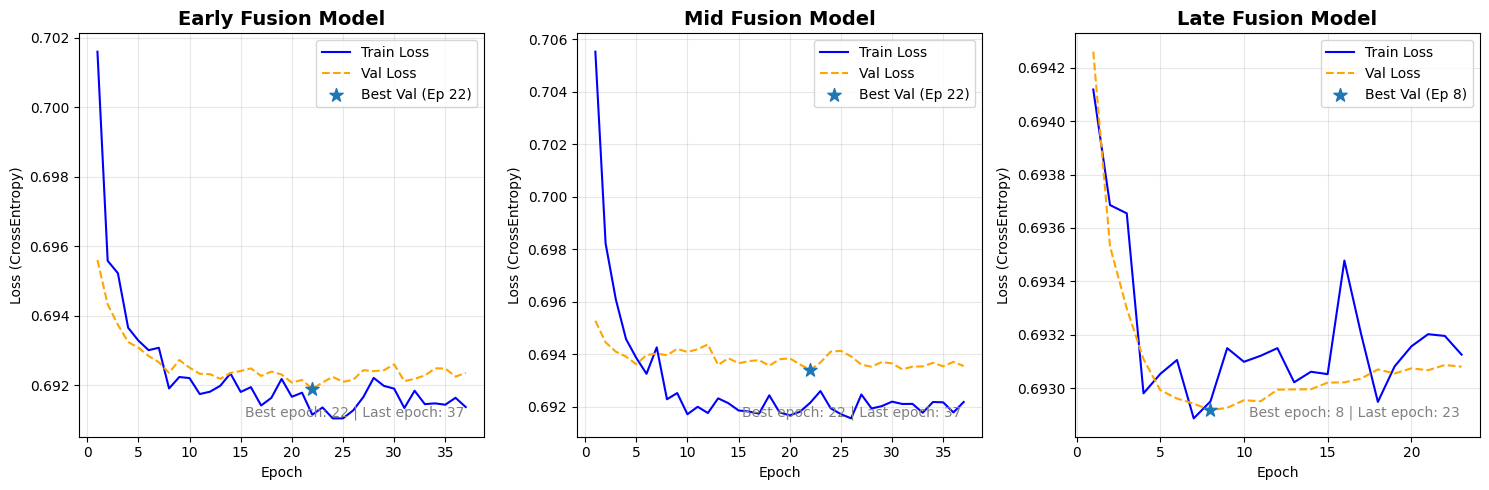

In [37]:
def plot_loss_curves(histories):
    n_models = len(histories)
    cols = n_models
    rows = 1

    fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 5), sharey=False)

    if n_models == 1:
        axes = [axes]

    for ax, (name, hist_df) in zip(axes, histories.items()):
        if hist_df is None or hist_df.empty:
            ax.set_title(f"{name} Fusion Model (no history)")
            ax.axis("off")
            continue

        hist_df = hist_df.sort_values("epoch")
            
        ax.plot(
            hist_df["epoch"], hist_df["train_loss"],
            label="Train Loss", color="blue", linestyle="-"
        )
        ax.plot(
            hist_df["epoch"], hist_df["val_loss"],
            label="Val Loss", color="orange", linestyle="--"
        )

        # Mark the best point
        if hist_df["val_loss"].notna().any():
            best_idx = hist_df["val_loss"].idxmin()
            best_row = hist_df.loc[best_idx]
            best_epoch = int(best_row["epoch"])
            best_val = float(best_row["val_loss"])

            ax.scatter(
                best_epoch, best_val,
                s=100, marker="*", zorder=5,
                label=f"Best Val (Ep {best_epoch})"
            )

        # Annotate early stopping information
        final_epoch = int(hist_df["epoch"].iloc[-1])

        # Plot styling
        ax.set_title(f"{name} Fusion Model", fontsize=14, fontweight="bold")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss (CrossEntropy)")
        ax.legend()
        ax.grid(True, alpha=0.3)

        ax.text(
            0.95, 0.05,
             f"Best epoch: {best_epoch} | Last epoch: {final_epoch}",
            transform=ax.transAxes,
            ha="right",
            fontsize=10,
            color="gray"
        )

    plt.tight_layout()
    plt.show()

plot_loss_curves(histories)


In [38]:
df_results

,model,split,best_val_loss,threshold,acc,prec,rec,f1,auc,tn,fp,fn,tp
0,Late,val,0.692917,0.495,0.466250,0.459531,0.946266,0.618636,0.521131,80,1222,59,1039
1,Mid,val,0.693400,0.475,0.467083,0.459362,0.931694,0.615338,0.504222,98,1204,75,1023
2,Early,val,0.691893,0.475,0.465000,0.457957,0.922587,0.612085,0.528669,103,1199,85,1013
3,Early,test,0.691893,0.475,0.457627,0.444543,0.972816,0.610231,0.539426,39,626,14,501
4,Late,test,0.692917,0.495,0.444915,0.438918,0.976699,0.605659,0.535473,22,643,12,503
5,Mid,test,0.693400,0.475,0.442373,0.436444,0.953398,0.598780,0.533741,31,634,24,491


In [42]:
@torch.no_grad()
def collect_pred(model, loader, device, split_name, id2code):
    model.eval()
    rows = []
    
    for X, y, scode_id, date_ns in loader:
        X = X.to(device)
        y = y.to(device)
        
        logits = model(X)
        p_up = torch.softmax(logits, dim=1)[:, 1].detach().cpu().numpy()

        y = y.detach().cpu().numpy().astype(int)
        scode_id = scode_id.detach().cpu().numpy().astype(int)
        date = pd.to_datetime(date_ns.detach().cpu().numpy().astype("int64"))

        for sid, d, yt, p in zip(scode_id, date, y, p_up):
            rows.append({
                "Scode": id2code[int(sid)],
                "window_end_date": d,
                "split": split_name,
                "y_true": int(yt),
                "p_up": float(p),
            })


    if not rows:
        print(f"[collect_pred] Warning: no samples for split={split_name}")
        return pd.DataFrame(
            columns=["Scode", "window_end_date", "split", "y_true", "p_up"]
        )

    pred_df = pd.DataFrame(rows)
    pred_df = pred_df.sort_values(["Scode", "window_end_date"]).reset_index(drop=True)
    return pred_df


In [43]:
pred_all_by_model = {}

for name, model in trained_models.items():
    pred_train = collect_pred(model, train_loader, device, "train", id2code)
    pred_val   = collect_pred(model, val_loader,   device, "val",   id2code)
    pred_test  = collect_pred(model, test_loader,  device, "test",  id2code)
    pred_all_by_model[name] = pd.concat([pred_train, pred_val, pred_test], ignore_index=True)


In [59]:
def plot_fusion_single_company(
    df_all, pred_all, scode,
    train_end, val_end,
    price_date_col="Date", code_col="Scode", ret_col="Return_1d",
    threshold=None,
    title_prefix="Fusion model P(up)",
    pred_date_col=None,
    show_splits=("val", "test"),
):
    # pick prediction date column
    if pred_date_col is None:
        if "window_end_date" in pred_all.columns:
            pred_date_col = "window_end_date"
        elif "Date" in pred_all.columns:
            pred_date_col = "Date"
        else:
            raise KeyError("pred_all must contain 'window_end_date' or 'Date'")

    # Extract predictions for a single company
    d = pred_all[pred_all[code_col].astype(str) == str(scode)].copy()
    if d.empty:
        print("No prediction rows for scode:", scode)
        return

    d[pred_date_col] = pd.to_datetime(d[pred_date_col], errors="coerce")
    d = d.dropna(subset=[pred_date_col]).sort_values(pred_date_col)

    # Extract true returns for the company
    g = df_all[df_all[code_col].astype(str) == str(scode)].copy()
    g[price_date_col] = pd.to_datetime(g[price_date_col], errors="coerce")
    g[ret_col] = pd.to_numeric(g[ret_col], errors="coerce")
    g = g.dropna(subset=[price_date_col, ret_col]).sort_values(price_date_col)

    fig, ax1 = plt.subplots(figsize=(12, 5))

    # Left axis: Return_1d
    ax1.plot(g[price_date_col], g[ret_col], label=ret_col)
    ax1.set_xlabel("Date")
    ax1.set_ylabel(ret_col)

    # Split lines
    ax1.axvline(pd.Timestamp(train_end), linestyle="--", label="TRAIN_END")
    ax1.axvline(pd.Timestamp(val_end), linestyle="--", label="VAL_END")

    # Right axis: P(up)
    ax2 = ax1.twinx()
    ax2.set_ylabel("P(up)")

    # Plot predictions
    markers = {"train": ".", "val": "o", "test": "s"}
    for split in show_splits:
        dd = d[d["split"] == split]
        if len(dd):
            ax2.plot(
                dd[pred_date_col], dd["p_up"],   
                linestyle="None", marker=markers.get(split, "o"),
                label=f"p_up ({split})", alpha=0.8
            )

    if threshold is not None:
        ax2.axhline(float(threshold), linestyle=":", label=f"thr={threshold:.2f}")

    # Merge legends
    h1, l1 = ax1.get_legend_handles_labels()
    h2, l2 = ax2.get_legend_handles_labels()
    ax1.legend(h1 + h2, l1 + l2, loc="upper left")

    ax1.set_title(f"{title_prefix} | Scode={scode}")
    plt.tight_layout()
    plt.show()


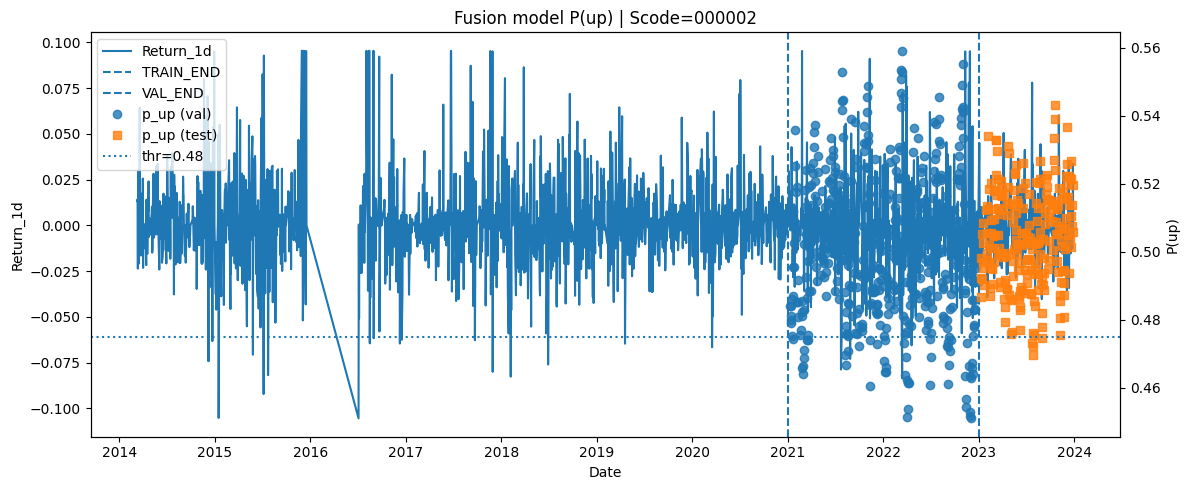

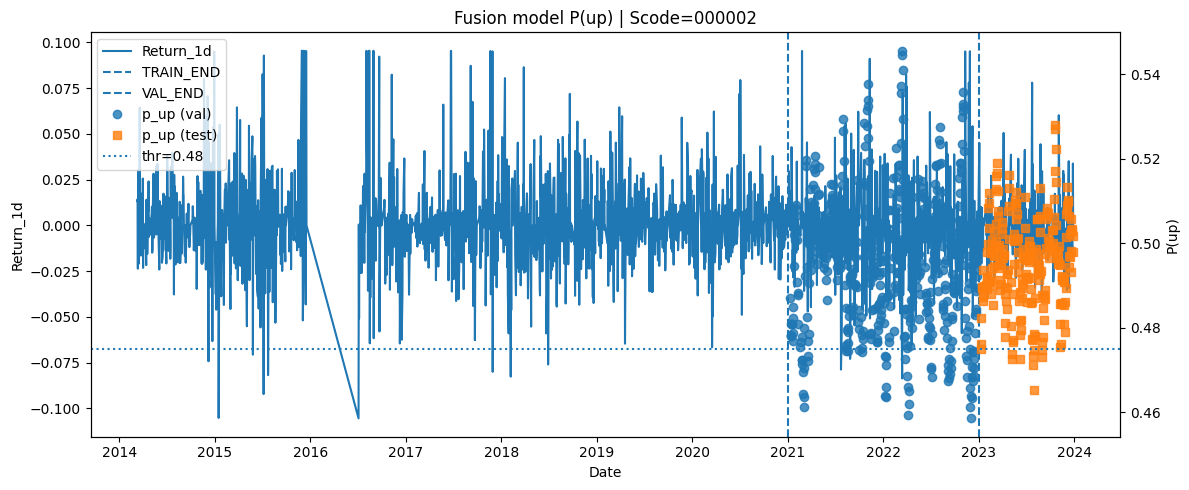

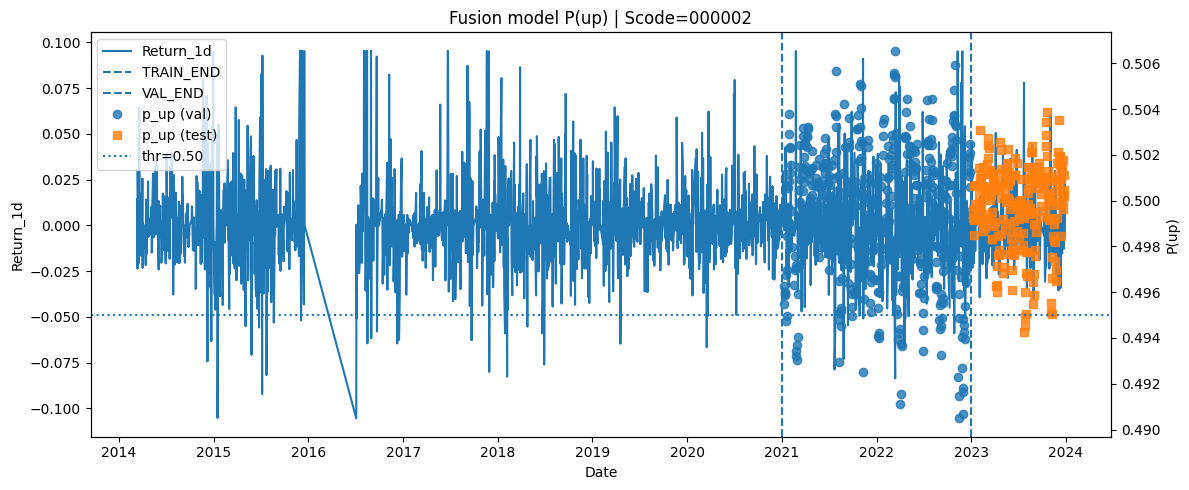

In [60]:
scode = "000002"

for name in ["Early", "Mid", "Late"]:
    pred_all = pred_all_by_model[name]

    thr = df_results.loc[
        (df_results["model"] == name) & (df_results["split"] == "test"),
        "threshold"
    ].iloc[0]

    plot_fusion_single_company(
        df_all=df,
        pred_all=pred_all,
        scode=scode,
        train_end=TRAIN_END,
        val_end=VAL_END,
        price_date_col="Date",
        pred_date_col="window_end_date",
        code_col="Scode",
        ret_col="Return_1d",
        threshold=thr,
    )



In [ ]:
scode = "002594"

for name in ["Early", "Mid", "Late"]:
    pred_all = pred_all_by_model[name]

    thr = df_results.loc[
        (df_results["model"] == name) & (df_results["split"] == "test"),
        "threshold"
    ].iloc[0]

    plot_fusion_single_company(
        df_all=df,
        pred_all=pred_all,
        scode=scode,
        train_end=TRAIN_END,
        val_end=VAL_END,
        date_col="Date", code_col="Scode", ret_col="Return_1d",
        threshold=thr,
        title_prefix=f"{name} Fusion P(up)"
    )


In [ ]:
scode = "601857"

for name in ["Early", "Mid", "Late"]:
    pred_all = pred_all_by_model[name]

    thr = df_results.loc[
        (df_results["model"] == name) & (df_results["split"] == "test"),
        "threshold"
    ].iloc[0]

    plot_fusion_single_company(
        df_all=df,
        pred_all=pred_all,
        scode=scode,
        train_end=TRAIN_END,
        val_end=VAL_END,
        date_col="Date", code_col="Scode", ret_col="Return_1d",
        threshold=thr,
        title_prefix=f"{name} Fusion P(up)"
    )


In [ ]:
scode = "600519"

for name in ["Early", "Mid", "Late"]:
    pred_all = pred_all_by_model[name]

    thr = df_results.loc[
        (df_results["model"] == name) & (df_results["split"] == "test"),
        "threshold"
    ].iloc[0]

    plot_fusion_single_company(
        df_all=df,
        pred_all=pred_all,
        scode=scode,
        train_end=TRAIN_END,
        val_end=VAL_END,
        date_col="Date", code_col="Scode", ret_col="Return_1d",
        threshold=thr,
        title_prefix=f"{name} Fusion P(up)"
    )


In [ ]:
scode = "600028"

for name in ["Early", "Mid", "Late"]:
    pred_all = pred_all_by_model[name]

    thr = df_results.loc[
        (df_results["model"] == name) & (df_results["split"] == "test"),
        "threshold"
    ].iloc[0]

    plot_fusion_single_company(
        df_all=df,
        pred_all=pred_all,
        scode=scode,
        train_end=TRAIN_END,
        val_end=VAL_END,
        date_col="Date", code_col="Scode", ret_col="Return_1d",
        threshold=thr,
        title_prefix=f"{name} Fusion P(up)"
    )


## 5. Sensitivity analysis

In [61]:
# Loader builder 
def build_loaders_for_lag(
    train_df, val_df, test_df,
    feature_cols, lag,
    batch_size=64,
    shuffle_train=True,          
    forward_horizon_steps=0,
    drop_unseen_codes=True,
    drop_last_train=True,
    num_workers=0,
    pin_memory=True,
):
    # train builds code2id
    train_set, code2id, id2code = make_windows(
        train_df, feature_cols, lag,
        forward_horizon_steps=forward_horizon_steps,
        code2id=None
    )

    # val/test reuse mapping
    val_set, _, _ = make_windows(
        val_df, feature_cols, lag,
        forward_horizon_steps=forward_horizon_steps,
        code2id=code2id,
        drop_unseen_codes=drop_unseen_codes
    )
    test_set, _, _ = make_windows(
        test_df, feature_cols, lag,
        forward_horizon_steps=forward_horizon_steps,
        code2id=code2id,
        drop_unseen_codes=drop_unseen_codes
    )

    train_loader = DataLoader(
        train_set,
        batch_size=batch_size,
        shuffle=shuffle_train,
        drop_last=drop_last_train,
        num_workers=num_workers,
        pin_memory=pin_memory,
    )
    val_loader = DataLoader(
        val_set,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False,
        num_workers=num_workers,
        pin_memory=pin_memory,
    )
    test_loader = DataLoader(
        test_set,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False,
        num_workers=num_workers,
        pin_memory=pin_memory,
    )

    return train_set, val_set, test_set, train_loader, val_loader, test_loader, code2id, id2code

def make_param_grid_with_lag(
    lags=(5, 10, 20),
    lrs=(1e-4, 3e-4),
    dropouts=(0.2, 0.5),
    price_hidden_dims=(16, 32),
    d_models=(16, 32),
    num_heads_list=(2, 4),
    seeds=(1, 2, 3),          
    batch_size=64,
):
    grid = []
    for lag in lags:
        for lr in lrs:
            for dropout in dropouts:
                for price_hidden_dim in price_hidden_dims:
                    for d_model in d_models:
                        for num_heads in num_heads_list:
                            if d_model % num_heads != 0:
                                continue
                            for seed in seeds:
                                grid.append({
                                    "lag": int(lag),
                                    "batch_size": int(batch_size),
                                    "lr": float(lr),
                                    "dropout": float(dropout),
                                    "price_hidden_dim": int(price_hidden_dim),
                                    "d_model": int(d_model),
                                    "num_heads": int(num_heads),
                                    "seed": int(seed),
                                })
    return grid


In [64]:
def run_models_cfg(
    n_price, n_news,
    train_set, train_loader, val_loader, test_loader,
    epochs=50, lr=1e-4,
    threshold=None,               
    patience=10, device=None,

    dropout=0.5,
    price_hidden_dim=32,
    d_model=32,
    num_heads=4,

    # threshold selection controls
    thr_metric="f1",
    min_tnr=0.05,
    grid=201,
):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # build models 
    models = {
        "Early": EarlyFusionPredictor(
            n_price, n_news, 
            price_hidden_dim=32, 
            news_hidden_dim=32, 
            fusion_dim=32, 
            dropout=0.5
        ),
        "Mid": MidFusionPredictor(
            n_price=n_price, n_news=n_news, 
            price_hidden_dim=32, 
            d_model=32, num_heads=4, 
            dropout=0.5
        ),
        "Late": LateFusionPredictor(
            n_price=n_price, n_news=n_news, 
            price_hidden=32,  
            dropout=0.5
        ),
    }

    results = []
    trained_models = {}
    histories = {}

    for name, model in models.items():
        trained_model, hist_df, best_val_loss, val_m, test_m = train_select(
            model_name=name,
            model=model,
            train_set=train_set,
            train_loader=train_loader,
            val_loader=val_loader,
            test_loader=test_loader,
            epochs=epochs,
            lr=lr,
            threshold=threshold,    
            patience=patience,
            device=device,
            thr_metric=thr_metric,
            min_tnr=min_tnr,
            grid=grid,
        )
        trained_models[name] = trained_model
        histories[name] = hist_df

        results.append({
            "model": name,
            "best_val_loss": float(best_val_loss),
            "val": val_m,
            "test": test_m,
        })

    # summary table
    rows = []
    for r in results:
        for split in ["val", "test"]:
            m = r.get(split, {}) or {}
            cm = m.get("cm", None)
            if isinstance(cm, np.ndarray) and cm.shape == (2, 2):
                tn, fp = int(cm[0, 0]), int(cm[0, 1])
                fn, tp = int(cm[1, 0]), int(cm[1, 1])
            else:
                tn = fp = fn = tp = np.nan

            rows.append({
                "model": r["model"],
                "split": split,
                "best_val_loss": r["best_val_loss"],
                "threshold": float(m.get("threshold", np.nan)),
                "acc": float(m.get("acc", np.nan)),
                "prec": float(m.get("prec", np.nan)),
                "rec": float(m.get("rec", np.nan)),
                "f1": float(m.get("f1", np.nan)),
                "auc": float(m.get("auc", np.nan)),
                "tn": tn, "fp": fp, "fn": fn, "tp": tp,
            })

    summary_df = pd.DataFrame(rows)
    test_df = summary_df[summary_df["split"] == "test"].sort_values("f1", ascending=False).reset_index(drop=True)
    return results, summary_df, test_df, trained_models, histories


# Sensitivity runner
def run_sensitivity_with_lag(
    param_grid,
    n_price, n_news,
    train_df, val_df, test_df,
    feature_cols,
    epochs=30, patience=10,
    device=None,
    tag="sens_v2",

    # window/data options
    forward_horizon_steps=0,
    shuffle_train=True,
    drop_unseen_codes=True,
    drop_last_train=True,

    # threshold selection options
    thr_metric="f1",
    min_tnr=0.05,
    grid=201,
):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    all_rows = []

    for i, cfg in enumerate(param_grid, 1):
        set_seed(int(cfg["seed"]))

        lag = int(cfg["lag"])
        bs  = int(cfg.get("batch_size", 64))

        print("\n" + "#" * 90)
        print(f"[{tag}] Run {i}/{len(param_grid)} | cfg={cfg}")
        print("#" * 90)

        # rebuild loaders
        train_set, val_set, test_set, train_loader, val_loader, test_loader, code2id, id2code = \
            build_loaders_for_lag(
                train_df, val_df, test_df,
                feature_cols, lag,
                batch_size=bs,
                shuffle_train=shuffle_train,
                forward_horizon_steps=forward_horizon_steps,
                drop_unseen_codes=drop_unseen_codes,
                drop_last_train=drop_last_train,
            )

        if len(train_set) == 0 or len(val_set) == 0 or len(test_set) == 0:
            print("Skip: empty windows.")
            continue

        # train (threshold=None -> choose on val)
        _, df_results, _, _, _ = run_models_cfg(
            n_price=n_price, n_news=n_news,
            train_set=train_set,
            train_loader=train_loader,
            val_loader=val_loader,
            test_loader=test_loader,
            epochs=epochs,
            lr=float(cfg["lr"]),
            threshold=None,               
            patience=patience,
            device=device,
            dropout=float(cfg["dropout"]),
            price_hidden_dim=int(cfg["price_hidden_dim"]),
            d_model=int(cfg["d_model"]),
            num_heads=int(cfg["num_heads"]),
            thr_metric=thr_metric,
            min_tnr=min_tnr,
            grid=grid,
        )

        # attach cfg + dataset sizes
        for _, r in df_results.iterrows():
            row = r.to_dict()
            row["tag"] = tag
            for k, v in cfg.items():
                row[f"cfg_{k}"] = v

            row["n_train_win"] = int(len(train_set))
            row["n_val_win"]   = int(len(val_set))
            row["n_test_win"]  = int(len(test_set))
            row["n_codes"]     = int(len(code2id))

            all_rows.append(row)

    return pd.DataFrame(all_rows)


# Paper-style summary: mean ± 95% CI 
def summarize_param_sensitivity_ci(
    sens_df,
    model="Mid",
    split="test",
    metric="f1",
    param="cfg_lag",
):
    d = sens_df[(sens_df["model"] == model) & (sens_df["split"] == split)].copy()
    if d.empty:
        return None

    g = d.groupby(param)[metric].agg(["mean", "std", "count"]).reset_index()
    g["sem"] = g["std"] / np.sqrt(g["count"].clip(lower=1))
    # normal approx CI (ok when count is moderate); for very small count, you can use t-dist
    g["ci95"] = 1.96 * g["sem"]
    g = g.sort_values("mean", ascending=False).reset_index(drop=True)
    return g


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

param_grid = make_param_grid_with_lag(
    lags=(5, 10, 20),
    lrs=(1e-4, 3e-4),
    dropouts=(0.2, 0.5),
    price_hidden_dims=(16, 32),
    d_models=(16, 32),
    num_heads_list=(2, 4),
    seeds=(1, 2, 3),       
    batch_size=64
)

sens_df = run_sensitivity_with_lag(
    param_grid=param_grid,
    n_price=n_price, n_news=n_news,
    train_df=train_df, val_df=val_df, test_df=test_df,
    feature_cols=FEATURE_COLS,
    epochs=30, patience=10,
    device=device,
    tag="fusion_sens_v2",
    shuffle_train=True,        
    thr_metric="f1",
    min_tnr=0.05,
    grid=201
)

best_test = (
    sens_df[sens_df["split"] == "test"]
    .sort_values(["f1", "auc"], ascending=False)
    .head(15)
)

# Sensitivity table with CI 
tbl = summarize_param_sensitivity_ci(sens_df, model="Early", split="test", metric="f1", param="cfg_lag")
display(tbl)



##########################################################################################
[fusion_sens_v2] Run 1/288 | cfg={'lag': 5, 'batch_size': 64, 'lr': 0.0001, 'dropout': 0.2, 'price_hidden_dim': 16, 'd_model': 16, 'num_heads': 2, 'seed': 1}
##########################################################################################
[Loss] train labels: pos=3814, neg=4336
[Loss] class weight = [1.0, 1.1369] (cap=10.0)


/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Early] Epoch 01 | Train 0.7047 | Val 0.6947 | BestVal 0.6947
[Early] Epoch 02 | Train 0.6969 | Val 0.6937 | BestVal 0.6937
[Early] Epoch 03 | Train 0.6981 | Val 0.6928 | BestVal 0.6928
[Early] Epoch 04 | Train 0.6941 | Val 0.6925 | BestVal 0.6925
[Early] Epoch 05 | Train 0.6927 | Val 0.6921 | BestVal 0.6921
[Early] Epoch 06 | Train 0.6940 | Val 0.6922 | BestVal 0.6921
[Early] Epoch 07 | Train 0.6931 | Val 0.6925 | BestVal 0.6921
[Early] Epoch 08 | Train 0.6908 | Val 0.6927 | BestVal 0.6921
[Early] Epoch 09 | Train 0.6919 | Val 0.6924 | BestVal 0.6921
[Early] Epoch 10 | Train 0.6917 | Val 0.6925 | BestVal 0.6921
[Early] Epoch 11 | Train 0.6911 | Val 0.6923 | BestVal 0.6921
[Early] Epoch 12 | Train 0.6923 | Val 0.6920 | BestVal 0.6920
[Early] Epoch 13 | Train 0.6920 | Val 0.6922 | BestVal 0.6920
[Early] Epoch 14 | Train 0.6906 | Val 0.6925 | BestVal 0.6920
[Early] Epoch 15 | Train 0.6915 | Val 0.6922 | BestVal 0.6920
[Early] Epoch 16 | Train 0.6915 | Val 0.6922 | BestVal 0.6920
[Early] 

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Mid] Epoch 01 | Train 0.7061 | Val 0.6950 | BestVal 0.6950
[Mid] Epoch 02 | Train 0.6968 | Val 0.6950 | BestVal 0.6950
[Mid] Epoch 03 | Train 0.6948 | Val 0.6943 | BestVal 0.6943
[Mid] Epoch 04 | Train 0.6967 | Val 0.6940 | BestVal 0.6940
[Mid] Epoch 05 | Train 0.6943 | Val 0.6940 | BestVal 0.6940
[Mid] Epoch 06 | Train 0.6926 | Val 0.6938 | BestVal 0.6938
[Mid] Epoch 07 | Train 0.6931 | Val 0.6940 | BestVal 0.6938
[Mid] Epoch 08 | Train 0.6934 | Val 0.6943 | BestVal 0.6938
[Mid] Epoch 09 | Train 0.6931 | Val 0.6941 | BestVal 0.6938
[Mid] Epoch 10 | Train 0.6928 | Val 0.6941 | BestVal 0.6938
[Mid] Epoch 11 | Train 0.6932 | Val 0.6936 | BestVal 0.6936
[Mid] Epoch 12 | Train 0.6925 | Val 0.6934 | BestVal 0.6934
[Mid] Epoch 13 | Train 0.6927 | Val 0.6936 | BestVal 0.6934
[Mid] Epoch 14 | Train 0.6927 | Val 0.6937 | BestVal 0.6934
[Mid] Epoch 15 | Train 0.6924 | Val 0.6937 | BestVal 0.6934
[Mid] Epoch 16 | Train 0.6923 | Val 0.6937 | BestVal 0.6934
[Mid] Epoch 17 | Train 0.6923 | Val 0.69

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Late] Epoch 01 | Train 0.6933 | Val 0.6935 | BestVal 0.6935
[Late] Epoch 02 | Train 0.6932 | Val 0.6933 | BestVal 0.6933
[Late] Epoch 03 | Train 0.6932 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 04 | Train 0.6932 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 05 | Train 0.6929 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 06 | Train 0.6932 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 07 | Train 0.6929 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 08 | Train 0.6930 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 09 | Train 0.6932 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 10 | Train 0.6932 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 11 | Train 0.6931 | Val 0.6932 | BestVal 0.6931
[Late] Epoch 12 | Train 0.6932 | Val 0.6932 | BestVal 0.6931
[Late] Epoch 13 | Train 0.6930 | Val 0.6932 | BestVal 0.6931
[Late] Epoch 14 | Train 0.6931 | Val 0.6932 | BestVal 0.6931
[Late] Epoch 15 | Train 0.6931 | Val 0.6932 | BestVal 0.6931
[Late] Epoch 16 | Train 0.6932 | Val 0.6932 | BestVal 0.6931
[Late] Epoch 17 | Train 

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Early] Epoch 01 | Train 0.7047 | Val 0.6926 | BestVal 0.6926
[Early] Epoch 02 | Train 0.6965 | Val 0.6927 | BestVal 0.6926
[Early] Epoch 03 | Train 0.6947 | Val 0.6925 | BestVal 0.6925
[Early] Epoch 04 | Train 0.6924 | Val 0.6923 | BestVal 0.6923
[Early] Epoch 05 | Train 0.6926 | Val 0.6924 | BestVal 0.6923
[Early] Epoch 06 | Train 0.6931 | Val 0.6922 | BestVal 0.6922
[Early] Epoch 07 | Train 0.6926 | Val 0.6922 | BestVal 0.6922
[Early] Epoch 08 | Train 0.6921 | Val 0.6919 | BestVal 0.6919
[Early] Epoch 09 | Train 0.6918 | Val 0.6925 | BestVal 0.6919
[Early] Epoch 10 | Train 0.6917 | Val 0.6924 | BestVal 0.6919
[Early] Epoch 11 | Train 0.6919 | Val 0.6923 | BestVal 0.6919
[Early] Epoch 12 | Train 0.6915 | Val 0.6922 | BestVal 0.6919
[Early] Epoch 13 | Train 0.6916 | Val 0.6924 | BestVal 0.6919
[Early] Epoch 14 | Train 0.6921 | Val 0.6926 | BestVal 0.6919
[Early] Epoch 15 | Train 0.6913 | Val 0.6926 | BestVal 0.6919
[Early] Epoch 16 | Train 0.6918 | Val 0.6924 | BestVal 0.6919
[Early] 

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Mid] Epoch 01 | Train 0.6968 | Val 0.6944 | BestVal 0.6944
[Mid] Epoch 02 | Train 0.6941 | Val 0.6938 | BestVal 0.6938
[Mid] Epoch 03 | Train 0.6936 | Val 0.6935 | BestVal 0.6935
[Mid] Epoch 04 | Train 0.6934 | Val 0.6934 | BestVal 0.6934
[Mid] Epoch 05 | Train 0.6929 | Val 0.6933 | BestVal 0.6933
[Mid] Epoch 06 | Train 0.6925 | Val 0.6932 | BestVal 0.6932
[Mid] Epoch 07 | Train 0.6928 | Val 0.6934 | BestVal 0.6932
[Mid] Epoch 08 | Train 0.6925 | Val 0.6932 | BestVal 0.6932
[Mid] Epoch 09 | Train 0.6924 | Val 0.6933 | BestVal 0.6932
[Mid] Epoch 10 | Train 0.6929 | Val 0.6933 | BestVal 0.6932
[Mid] Epoch 11 | Train 0.6923 | Val 0.6933 | BestVal 0.6932
[Mid] Epoch 12 | Train 0.6924 | Val 0.6933 | BestVal 0.6932
[Mid] Epoch 13 | Train 0.6923 | Val 0.6933 | BestVal 0.6932
[Mid] Epoch 14 | Train 0.6924 | Val 0.6934 | BestVal 0.6932
[Mid] Epoch 15 | Train 0.6924 | Val 0.6933 | BestVal 0.6932
[Mid] Epoch 16 | Train 0.6924 | Val 0.6933 | BestVal 0.6932
Early stopping triggered at epoch 16!
[L

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Late] Epoch 01 | Train 0.6935 | Val 0.6934 | BestVal 0.6934
[Late] Epoch 02 | Train 0.6934 | Val 0.6934 | BestVal 0.6934
[Late] Epoch 03 | Train 0.6931 | Val 0.6933 | BestVal 0.6933
[Late] Epoch 04 | Train 0.6931 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 05 | Train 0.6931 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 06 | Train 0.6930 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 07 | Train 0.6930 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 08 | Train 0.6931 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 09 | Train 0.6931 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 10 | Train 0.6931 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 11 | Train 0.6933 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 12 | Train 0.6932 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 13 | Train 0.6932 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 14 | Train 0.6932 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 15 | Train 0.6933 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 16 | Train 0.6931 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 17 | Train 

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Early] Epoch 01 | Train 0.7035 | Val 0.6929 | BestVal 0.6929
[Early] Epoch 02 | Train 0.6977 | Val 0.6925 | BestVal 0.6925
[Early] Epoch 03 | Train 0.6975 | Val 0.6927 | BestVal 0.6925
[Early] Epoch 04 | Train 0.6948 | Val 0.6924 | BestVal 0.6924
[Early] Epoch 05 | Train 0.6948 | Val 0.6924 | BestVal 0.6924
[Early] Epoch 06 | Train 0.6932 | Val 0.6923 | BestVal 0.6923
[Early] Epoch 07 | Train 0.6928 | Val 0.6923 | BestVal 0.6923
[Early] Epoch 08 | Train 0.6927 | Val 0.6924 | BestVal 0.6923
[Early] Epoch 09 | Train 0.6920 | Val 0.6923 | BestVal 0.6923
[Early] Epoch 10 | Train 0.6912 | Val 0.6923 | BestVal 0.6923
[Early] Epoch 11 | Train 0.6920 | Val 0.6924 | BestVal 0.6923
[Early] Epoch 12 | Train 0.6921 | Val 0.6921 | BestVal 0.6921
[Early] Epoch 13 | Train 0.6911 | Val 0.6923 | BestVal 0.6921
[Early] Epoch 14 | Train 0.6913 | Val 0.6922 | BestVal 0.6921
[Early] Epoch 15 | Train 0.6918 | Val 0.6922 | BestVal 0.6921
[Early] Epoch 16 | Train 0.6912 | Val 0.6924 | BestVal 0.6921
[Early] 

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Mid] Epoch 01 | Train 0.7051 | Val 0.6944 | BestVal 0.6944
[Mid] Epoch 02 | Train 0.6972 | Val 0.6942 | BestVal 0.6942
[Mid] Epoch 03 | Train 0.6952 | Val 0.6940 | BestVal 0.6940
[Mid] Epoch 04 | Train 0.6938 | Val 0.6939 | BestVal 0.6939
[Mid] Epoch 05 | Train 0.6933 | Val 0.6937 | BestVal 0.6937
[Mid] Epoch 06 | Train 0.6940 | Val 0.6938 | BestVal 0.6937
[Mid] Epoch 07 | Train 0.6923 | Val 0.6937 | BestVal 0.6937
[Mid] Epoch 08 | Train 0.6932 | Val 0.6936 | BestVal 0.6936
[Mid] Epoch 09 | Train 0.6927 | Val 0.6937 | BestVal 0.6936
[Mid] Epoch 10 | Train 0.6923 | Val 0.6934 | BestVal 0.6934
[Mid] Epoch 11 | Train 0.6924 | Val 0.6934 | BestVal 0.6934
[Mid] Epoch 12 | Train 0.6924 | Val 0.6934 | BestVal 0.6934
[Mid] Epoch 13 | Train 0.6924 | Val 0.6935 | BestVal 0.6934
[Mid] Epoch 14 | Train 0.6917 | Val 0.6934 | BestVal 0.6934
[Mid] Epoch 15 | Train 0.6921 | Val 0.6936 | BestVal 0.6934
[Mid] Epoch 16 | Train 0.6922 | Val 0.6936 | BestVal 0.6934
[Mid] Epoch 17 | Train 0.6921 | Val 0.69

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Late] Epoch 01 | Train 0.6950 | Val 0.6955 | BestVal 0.6955
[Late] Epoch 02 | Train 0.6941 | Val 0.6946 | BestVal 0.6946
[Late] Epoch 03 | Train 0.6937 | Val 0.6941 | BestVal 0.6941
[Late] Epoch 04 | Train 0.6931 | Val 0.6938 | BestVal 0.6938
[Late] Epoch 05 | Train 0.6931 | Val 0.6936 | BestVal 0.6936
[Late] Epoch 06 | Train 0.6931 | Val 0.6935 | BestVal 0.6935
[Late] Epoch 07 | Train 0.6932 | Val 0.6934 | BestVal 0.6934
[Late] Epoch 08 | Train 0.6934 | Val 0.6933 | BestVal 0.6933
[Late] Epoch 09 | Train 0.6933 | Val 0.6933 | BestVal 0.6933
[Late] Epoch 10 | Train 0.6932 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 11 | Train 0.6932 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 12 | Train 0.6931 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 13 | Train 0.6932 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 14 | Train 0.6930 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 15 | Train 0.6933 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 16 | Train 0.6933 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 17 | Train 

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Early] Epoch 01 | Train 0.7047 | Val 0.6947 | BestVal 0.6947
[Early] Epoch 02 | Train 0.6969 | Val 0.6937 | BestVal 0.6937
[Early] Epoch 03 | Train 0.6981 | Val 0.6928 | BestVal 0.6928
[Early] Epoch 04 | Train 0.6941 | Val 0.6925 | BestVal 0.6925
[Early] Epoch 05 | Train 0.6927 | Val 0.6921 | BestVal 0.6921
[Early] Epoch 06 | Train 0.6940 | Val 0.6922 | BestVal 0.6921
[Early] Epoch 07 | Train 0.6931 | Val 0.6925 | BestVal 0.6921
[Early] Epoch 08 | Train 0.6908 | Val 0.6927 | BestVal 0.6921
[Early] Epoch 09 | Train 0.6919 | Val 0.6924 | BestVal 0.6921
[Early] Epoch 10 | Train 0.6917 | Val 0.6925 | BestVal 0.6921
[Early] Epoch 11 | Train 0.6911 | Val 0.6923 | BestVal 0.6921
[Early] Epoch 12 | Train 0.6923 | Val 0.6920 | BestVal 0.6920
[Early] Epoch 13 | Train 0.6920 | Val 0.6922 | BestVal 0.6920
[Early] Epoch 14 | Train 0.6906 | Val 0.6925 | BestVal 0.6920
[Early] Epoch 15 | Train 0.6915 | Val 0.6922 | BestVal 0.6920
[Early] Epoch 16 | Train 0.6915 | Val 0.6922 | BestVal 0.6920
[Early] 

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Mid] Epoch 01 | Train 0.7061 | Val 0.6950 | BestVal 0.6950
[Mid] Epoch 02 | Train 0.6968 | Val 0.6950 | BestVal 0.6950
[Mid] Epoch 03 | Train 0.6948 | Val 0.6943 | BestVal 0.6943
[Mid] Epoch 04 | Train 0.6967 | Val 0.6940 | BestVal 0.6940
[Mid] Epoch 05 | Train 0.6943 | Val 0.6940 | BestVal 0.6940
[Mid] Epoch 06 | Train 0.6926 | Val 0.6938 | BestVal 0.6938
[Mid] Epoch 07 | Train 0.6931 | Val 0.6940 | BestVal 0.6938
[Mid] Epoch 08 | Train 0.6934 | Val 0.6943 | BestVal 0.6938
[Mid] Epoch 09 | Train 0.6931 | Val 0.6941 | BestVal 0.6938
[Mid] Epoch 10 | Train 0.6928 | Val 0.6941 | BestVal 0.6938
[Mid] Epoch 11 | Train 0.6932 | Val 0.6936 | BestVal 0.6936
[Mid] Epoch 12 | Train 0.6925 | Val 0.6934 | BestVal 0.6934
[Mid] Epoch 13 | Train 0.6927 | Val 0.6936 | BestVal 0.6934
[Mid] Epoch 14 | Train 0.6927 | Val 0.6937 | BestVal 0.6934
[Mid] Epoch 15 | Train 0.6924 | Val 0.6937 | BestVal 0.6934
[Mid] Epoch 16 | Train 0.6923 | Val 0.6937 | BestVal 0.6934
[Mid] Epoch 17 | Train 0.6923 | Val 0.69

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Late] Epoch 01 | Train 0.6933 | Val 0.6935 | BestVal 0.6935
[Late] Epoch 02 | Train 0.6932 | Val 0.6933 | BestVal 0.6933
[Late] Epoch 03 | Train 0.6932 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 04 | Train 0.6932 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 05 | Train 0.6929 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 06 | Train 0.6932 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 07 | Train 0.6929 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 08 | Train 0.6930 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 09 | Train 0.6932 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 10 | Train 0.6932 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 11 | Train 0.6931 | Val 0.6932 | BestVal 0.6931
[Late] Epoch 12 | Train 0.6932 | Val 0.6932 | BestVal 0.6931
[Late] Epoch 13 | Train 0.6930 | Val 0.6932 | BestVal 0.6931
[Late] Epoch 14 | Train 0.6931 | Val 0.6932 | BestVal 0.6931
[Late] Epoch 15 | Train 0.6931 | Val 0.6932 | BestVal 0.6931
[Late] Epoch 16 | Train 0.6932 | Val 0.6932 | BestVal 0.6931
[Late] Epoch 17 | Train 

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Early] Epoch 01 | Train 0.7047 | Val 0.6926 | BestVal 0.6926
[Early] Epoch 02 | Train 0.6965 | Val 0.6927 | BestVal 0.6926
[Early] Epoch 03 | Train 0.6947 | Val 0.6925 | BestVal 0.6925
[Early] Epoch 04 | Train 0.6924 | Val 0.6923 | BestVal 0.6923
[Early] Epoch 05 | Train 0.6926 | Val 0.6924 | BestVal 0.6923
[Early] Epoch 06 | Train 0.6931 | Val 0.6922 | BestVal 0.6922
[Early] Epoch 07 | Train 0.6926 | Val 0.6922 | BestVal 0.6922
[Early] Epoch 08 | Train 0.6921 | Val 0.6919 | BestVal 0.6919
[Early] Epoch 09 | Train 0.6918 | Val 0.6925 | BestVal 0.6919
[Early] Epoch 10 | Train 0.6917 | Val 0.6924 | BestVal 0.6919
[Early] Epoch 11 | Train 0.6919 | Val 0.6923 | BestVal 0.6919
[Early] Epoch 12 | Train 0.6915 | Val 0.6922 | BestVal 0.6919
[Early] Epoch 13 | Train 0.6916 | Val 0.6924 | BestVal 0.6919
[Early] Epoch 14 | Train 0.6921 | Val 0.6926 | BestVal 0.6919
[Early] Epoch 15 | Train 0.6913 | Val 0.6926 | BestVal 0.6919
[Early] Epoch 16 | Train 0.6918 | Val 0.6924 | BestVal 0.6919
[Early] 

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Mid] Epoch 01 | Train 0.6968 | Val 0.6944 | BestVal 0.6944
[Mid] Epoch 02 | Train 0.6941 | Val 0.6938 | BestVal 0.6938
[Mid] Epoch 03 | Train 0.6936 | Val 0.6935 | BestVal 0.6935
[Mid] Epoch 04 | Train 0.6934 | Val 0.6934 | BestVal 0.6934
[Mid] Epoch 05 | Train 0.6929 | Val 0.6933 | BestVal 0.6933
[Mid] Epoch 06 | Train 0.6925 | Val 0.6932 | BestVal 0.6932
[Mid] Epoch 07 | Train 0.6928 | Val 0.6934 | BestVal 0.6932
[Mid] Epoch 08 | Train 0.6925 | Val 0.6932 | BestVal 0.6932
[Mid] Epoch 09 | Train 0.6924 | Val 0.6933 | BestVal 0.6932
[Mid] Epoch 10 | Train 0.6929 | Val 0.6933 | BestVal 0.6932
[Mid] Epoch 11 | Train 0.6923 | Val 0.6933 | BestVal 0.6932
[Mid] Epoch 12 | Train 0.6924 | Val 0.6933 | BestVal 0.6932
[Mid] Epoch 13 | Train 0.6923 | Val 0.6933 | BestVal 0.6932
[Mid] Epoch 14 | Train 0.6924 | Val 0.6934 | BestVal 0.6932
[Mid] Epoch 15 | Train 0.6924 | Val 0.6933 | BestVal 0.6932
[Mid] Epoch 16 | Train 0.6924 | Val 0.6933 | BestVal 0.6932
Early stopping triggered at epoch 16!
[L

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Late] Epoch 01 | Train 0.6935 | Val 0.6934 | BestVal 0.6934
[Late] Epoch 02 | Train 0.6934 | Val 0.6934 | BestVal 0.6934
[Late] Epoch 03 | Train 0.6931 | Val 0.6933 | BestVal 0.6933
[Late] Epoch 04 | Train 0.6931 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 05 | Train 0.6931 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 06 | Train 0.6930 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 07 | Train 0.6930 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 08 | Train 0.6931 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 09 | Train 0.6931 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 10 | Train 0.6931 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 11 | Train 0.6933 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 12 | Train 0.6932 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 13 | Train 0.6932 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 14 | Train 0.6932 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 15 | Train 0.6933 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 16 | Train 0.6931 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 17 | Train 

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Early] Epoch 01 | Train 0.7035 | Val 0.6929 | BestVal 0.6929
[Early] Epoch 02 | Train 0.6977 | Val 0.6925 | BestVal 0.6925
[Early] Epoch 03 | Train 0.6975 | Val 0.6927 | BestVal 0.6925
[Early] Epoch 04 | Train 0.6948 | Val 0.6924 | BestVal 0.6924
[Early] Epoch 05 | Train 0.6948 | Val 0.6924 | BestVal 0.6924
[Early] Epoch 06 | Train 0.6932 | Val 0.6923 | BestVal 0.6923
[Early] Epoch 07 | Train 0.6928 | Val 0.6923 | BestVal 0.6923
[Early] Epoch 08 | Train 0.6927 | Val 0.6924 | BestVal 0.6923
[Early] Epoch 09 | Train 0.6920 | Val 0.6923 | BestVal 0.6923
[Early] Epoch 10 | Train 0.6912 | Val 0.6923 | BestVal 0.6923
[Early] Epoch 11 | Train 0.6920 | Val 0.6924 | BestVal 0.6923
[Early] Epoch 12 | Train 0.6921 | Val 0.6921 | BestVal 0.6921
[Early] Epoch 13 | Train 0.6911 | Val 0.6923 | BestVal 0.6921
[Early] Epoch 14 | Train 0.6913 | Val 0.6922 | BestVal 0.6921
[Early] Epoch 15 | Train 0.6918 | Val 0.6922 | BestVal 0.6921
[Early] Epoch 16 | Train 0.6912 | Val 0.6924 | BestVal 0.6921
[Early] 

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Mid] Epoch 01 | Train 0.7051 | Val 0.6944 | BestVal 0.6944
[Mid] Epoch 02 | Train 0.6972 | Val 0.6942 | BestVal 0.6942
[Mid] Epoch 03 | Train 0.6952 | Val 0.6940 | BestVal 0.6940
[Mid] Epoch 04 | Train 0.6938 | Val 0.6939 | BestVal 0.6939
[Mid] Epoch 05 | Train 0.6933 | Val 0.6937 | BestVal 0.6937
[Mid] Epoch 06 | Train 0.6940 | Val 0.6938 | BestVal 0.6937
[Mid] Epoch 07 | Train 0.6923 | Val 0.6937 | BestVal 0.6937
[Mid] Epoch 08 | Train 0.6932 | Val 0.6936 | BestVal 0.6936
[Mid] Epoch 09 | Train 0.6927 | Val 0.6937 | BestVal 0.6936
[Mid] Epoch 10 | Train 0.6923 | Val 0.6934 | BestVal 0.6934
[Mid] Epoch 11 | Train 0.6924 | Val 0.6934 | BestVal 0.6934
[Mid] Epoch 12 | Train 0.6924 | Val 0.6934 | BestVal 0.6934
[Mid] Epoch 13 | Train 0.6924 | Val 0.6935 | BestVal 0.6934
[Mid] Epoch 14 | Train 0.6917 | Val 0.6934 | BestVal 0.6934
[Mid] Epoch 15 | Train 0.6921 | Val 0.6936 | BestVal 0.6934
[Mid] Epoch 16 | Train 0.6922 | Val 0.6936 | BestVal 0.6934
[Mid] Epoch 17 | Train 0.6921 | Val 0.69

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Late] Epoch 01 | Train 0.6950 | Val 0.6955 | BestVal 0.6955
[Late] Epoch 02 | Train 0.6941 | Val 0.6946 | BestVal 0.6946
[Late] Epoch 03 | Train 0.6937 | Val 0.6941 | BestVal 0.6941
[Late] Epoch 04 | Train 0.6931 | Val 0.6938 | BestVal 0.6938
[Late] Epoch 05 | Train 0.6931 | Val 0.6936 | BestVal 0.6936
[Late] Epoch 06 | Train 0.6931 | Val 0.6935 | BestVal 0.6935
[Late] Epoch 07 | Train 0.6932 | Val 0.6934 | BestVal 0.6934
[Late] Epoch 08 | Train 0.6934 | Val 0.6933 | BestVal 0.6933
[Late] Epoch 09 | Train 0.6933 | Val 0.6933 | BestVal 0.6933
[Late] Epoch 10 | Train 0.6932 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 11 | Train 0.6932 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 12 | Train 0.6931 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 13 | Train 0.6932 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 14 | Train 0.6930 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 15 | Train 0.6933 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 16 | Train 0.6933 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 17 | Train 

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Early] Epoch 01 | Train 0.7047 | Val 0.6947 | BestVal 0.6947
[Early] Epoch 02 | Train 0.6969 | Val 0.6937 | BestVal 0.6937
[Early] Epoch 03 | Train 0.6981 | Val 0.6928 | BestVal 0.6928
[Early] Epoch 04 | Train 0.6941 | Val 0.6925 | BestVal 0.6925
[Early] Epoch 05 | Train 0.6927 | Val 0.6921 | BestVal 0.6921
[Early] Epoch 06 | Train 0.6940 | Val 0.6922 | BestVal 0.6921
[Early] Epoch 07 | Train 0.6931 | Val 0.6925 | BestVal 0.6921
[Early] Epoch 08 | Train 0.6908 | Val 0.6927 | BestVal 0.6921
[Early] Epoch 09 | Train 0.6919 | Val 0.6924 | BestVal 0.6921
[Early] Epoch 10 | Train 0.6917 | Val 0.6925 | BestVal 0.6921
[Early] Epoch 11 | Train 0.6911 | Val 0.6923 | BestVal 0.6921
[Early] Epoch 12 | Train 0.6923 | Val 0.6920 | BestVal 0.6920
[Early] Epoch 13 | Train 0.6920 | Val 0.6922 | BestVal 0.6920
[Early] Epoch 14 | Train 0.6906 | Val 0.6925 | BestVal 0.6920
[Early] Epoch 15 | Train 0.6915 | Val 0.6922 | BestVal 0.6920
[Early] Epoch 16 | Train 0.6915 | Val 0.6922 | BestVal 0.6920
[Early] 

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Mid] Epoch 01 | Train 0.7061 | Val 0.6950 | BestVal 0.6950
[Mid] Epoch 02 | Train 0.6968 | Val 0.6950 | BestVal 0.6950
[Mid] Epoch 03 | Train 0.6948 | Val 0.6943 | BestVal 0.6943
[Mid] Epoch 04 | Train 0.6967 | Val 0.6940 | BestVal 0.6940
[Mid] Epoch 05 | Train 0.6943 | Val 0.6940 | BestVal 0.6940
[Mid] Epoch 06 | Train 0.6926 | Val 0.6938 | BestVal 0.6938
[Mid] Epoch 07 | Train 0.6931 | Val 0.6940 | BestVal 0.6938
[Mid] Epoch 08 | Train 0.6934 | Val 0.6943 | BestVal 0.6938
[Mid] Epoch 09 | Train 0.6931 | Val 0.6941 | BestVal 0.6938
[Mid] Epoch 10 | Train 0.6928 | Val 0.6941 | BestVal 0.6938
[Mid] Epoch 11 | Train 0.6932 | Val 0.6936 | BestVal 0.6936
[Mid] Epoch 12 | Train 0.6925 | Val 0.6934 | BestVal 0.6934
[Mid] Epoch 13 | Train 0.6927 | Val 0.6936 | BestVal 0.6934
[Mid] Epoch 14 | Train 0.6927 | Val 0.6937 | BestVal 0.6934
[Mid] Epoch 15 | Train 0.6924 | Val 0.6937 | BestVal 0.6934
[Mid] Epoch 16 | Train 0.6923 | Val 0.6937 | BestVal 0.6934
[Mid] Epoch 17 | Train 0.6923 | Val 0.69

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Late] Epoch 01 | Train 0.6933 | Val 0.6935 | BestVal 0.6935
[Late] Epoch 02 | Train 0.6932 | Val 0.6933 | BestVal 0.6933
[Late] Epoch 03 | Train 0.6932 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 04 | Train 0.6932 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 05 | Train 0.6929 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 06 | Train 0.6932 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 07 | Train 0.6929 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 08 | Train 0.6930 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 09 | Train 0.6932 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 10 | Train 0.6932 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 11 | Train 0.6931 | Val 0.6932 | BestVal 0.6931
[Late] Epoch 12 | Train 0.6932 | Val 0.6932 | BestVal 0.6931
[Late] Epoch 13 | Train 0.6930 | Val 0.6932 | BestVal 0.6931
[Late] Epoch 14 | Train 0.6931 | Val 0.6932 | BestVal 0.6931
[Late] Epoch 15 | Train 0.6931 | Val 0.6932 | BestVal 0.6931
[Late] Epoch 16 | Train 0.6932 | Val 0.6932 | BestVal 0.6931
[Late] Epoch 17 | Train 

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Early] Epoch 01 | Train 0.7047 | Val 0.6926 | BestVal 0.6926
[Early] Epoch 02 | Train 0.6965 | Val 0.6927 | BestVal 0.6926
[Early] Epoch 03 | Train 0.6947 | Val 0.6925 | BestVal 0.6925
[Early] Epoch 04 | Train 0.6924 | Val 0.6923 | BestVal 0.6923
[Early] Epoch 05 | Train 0.6926 | Val 0.6924 | BestVal 0.6923
[Early] Epoch 06 | Train 0.6931 | Val 0.6922 | BestVal 0.6922
[Early] Epoch 07 | Train 0.6926 | Val 0.6922 | BestVal 0.6922
[Early] Epoch 08 | Train 0.6921 | Val 0.6919 | BestVal 0.6919
[Early] Epoch 09 | Train 0.6918 | Val 0.6925 | BestVal 0.6919
[Early] Epoch 10 | Train 0.6917 | Val 0.6924 | BestVal 0.6919
[Early] Epoch 11 | Train 0.6919 | Val 0.6923 | BestVal 0.6919
[Early] Epoch 12 | Train 0.6915 | Val 0.6922 | BestVal 0.6919
[Early] Epoch 13 | Train 0.6916 | Val 0.6924 | BestVal 0.6919
[Early] Epoch 14 | Train 0.6921 | Val 0.6926 | BestVal 0.6919
[Early] Epoch 15 | Train 0.6913 | Val 0.6926 | BestVal 0.6919
[Early] Epoch 16 | Train 0.6918 | Val 0.6924 | BestVal 0.6919
[Early] 

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Mid] Epoch 01 | Train 0.6968 | Val 0.6944 | BestVal 0.6944
[Mid] Epoch 02 | Train 0.6941 | Val 0.6938 | BestVal 0.6938
[Mid] Epoch 03 | Train 0.6936 | Val 0.6935 | BestVal 0.6935
[Mid] Epoch 04 | Train 0.6934 | Val 0.6934 | BestVal 0.6934
[Mid] Epoch 05 | Train 0.6929 | Val 0.6933 | BestVal 0.6933
[Mid] Epoch 06 | Train 0.6925 | Val 0.6932 | BestVal 0.6932
[Mid] Epoch 07 | Train 0.6928 | Val 0.6934 | BestVal 0.6932
[Mid] Epoch 08 | Train 0.6925 | Val 0.6932 | BestVal 0.6932
[Mid] Epoch 09 | Train 0.6924 | Val 0.6933 | BestVal 0.6932
[Mid] Epoch 10 | Train 0.6929 | Val 0.6933 | BestVal 0.6932
[Mid] Epoch 11 | Train 0.6923 | Val 0.6933 | BestVal 0.6932
[Mid] Epoch 12 | Train 0.6924 | Val 0.6933 | BestVal 0.6932
[Mid] Epoch 13 | Train 0.6923 | Val 0.6933 | BestVal 0.6932
[Mid] Epoch 14 | Train 0.6924 | Val 0.6934 | BestVal 0.6932
[Mid] Epoch 15 | Train 0.6924 | Val 0.6933 | BestVal 0.6932
[Mid] Epoch 16 | Train 0.6924 | Val 0.6933 | BestVal 0.6932
Early stopping triggered at epoch 16!
[L

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Late] Epoch 01 | Train 0.6935 | Val 0.6934 | BestVal 0.6934
[Late] Epoch 02 | Train 0.6934 | Val 0.6934 | BestVal 0.6934
[Late] Epoch 03 | Train 0.6931 | Val 0.6933 | BestVal 0.6933
[Late] Epoch 04 | Train 0.6931 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 05 | Train 0.6931 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 06 | Train 0.6930 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 07 | Train 0.6930 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 08 | Train 0.6931 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 09 | Train 0.6931 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 10 | Train 0.6931 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 11 | Train 0.6933 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 12 | Train 0.6932 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 13 | Train 0.6932 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 14 | Train 0.6932 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 15 | Train 0.6933 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 16 | Train 0.6931 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 17 | Train 

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Early] Epoch 01 | Train 0.7035 | Val 0.6929 | BestVal 0.6929
[Early] Epoch 02 | Train 0.6977 | Val 0.6925 | BestVal 0.6925
[Early] Epoch 03 | Train 0.6975 | Val 0.6927 | BestVal 0.6925
[Early] Epoch 04 | Train 0.6948 | Val 0.6924 | BestVal 0.6924
[Early] Epoch 05 | Train 0.6948 | Val 0.6924 | BestVal 0.6924
[Early] Epoch 06 | Train 0.6932 | Val 0.6923 | BestVal 0.6923
[Early] Epoch 07 | Train 0.6928 | Val 0.6923 | BestVal 0.6923
[Early] Epoch 08 | Train 0.6927 | Val 0.6924 | BestVal 0.6923
[Early] Epoch 09 | Train 0.6920 | Val 0.6923 | BestVal 0.6923
[Early] Epoch 10 | Train 0.6912 | Val 0.6923 | BestVal 0.6923
[Early] Epoch 11 | Train 0.6920 | Val 0.6924 | BestVal 0.6923
[Early] Epoch 12 | Train 0.6921 | Val 0.6921 | BestVal 0.6921
[Early] Epoch 13 | Train 0.6911 | Val 0.6923 | BestVal 0.6921
[Early] Epoch 14 | Train 0.6913 | Val 0.6922 | BestVal 0.6921
[Early] Epoch 15 | Train 0.6918 | Val 0.6922 | BestVal 0.6921
[Early] Epoch 16 | Train 0.6912 | Val 0.6924 | BestVal 0.6921
[Early] 

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Mid] Epoch 01 | Train 0.7051 | Val 0.6944 | BestVal 0.6944
[Mid] Epoch 02 | Train 0.6972 | Val 0.6942 | BestVal 0.6942
[Mid] Epoch 03 | Train 0.6952 | Val 0.6940 | BestVal 0.6940
[Mid] Epoch 04 | Train 0.6938 | Val 0.6939 | BestVal 0.6939
[Mid] Epoch 05 | Train 0.6933 | Val 0.6937 | BestVal 0.6937
[Mid] Epoch 06 | Train 0.6940 | Val 0.6938 | BestVal 0.6937
[Mid] Epoch 07 | Train 0.6923 | Val 0.6937 | BestVal 0.6937
[Mid] Epoch 08 | Train 0.6932 | Val 0.6936 | BestVal 0.6936
[Mid] Epoch 09 | Train 0.6927 | Val 0.6937 | BestVal 0.6936
[Mid] Epoch 10 | Train 0.6923 | Val 0.6934 | BestVal 0.6934
[Mid] Epoch 11 | Train 0.6924 | Val 0.6934 | BestVal 0.6934
[Mid] Epoch 12 | Train 0.6924 | Val 0.6934 | BestVal 0.6934
[Mid] Epoch 13 | Train 0.6924 | Val 0.6935 | BestVal 0.6934
[Mid] Epoch 14 | Train 0.6917 | Val 0.6934 | BestVal 0.6934
[Mid] Epoch 15 | Train 0.6921 | Val 0.6936 | BestVal 0.6934
[Mid] Epoch 16 | Train 0.6922 | Val 0.6936 | BestVal 0.6934
[Mid] Epoch 17 | Train 0.6921 | Val 0.69

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Late] Epoch 01 | Train 0.6950 | Val 0.6955 | BestVal 0.6955
[Late] Epoch 02 | Train 0.6941 | Val 0.6946 | BestVal 0.6946
[Late] Epoch 03 | Train 0.6937 | Val 0.6941 | BestVal 0.6941
[Late] Epoch 04 | Train 0.6931 | Val 0.6938 | BestVal 0.6938
[Late] Epoch 05 | Train 0.6931 | Val 0.6936 | BestVal 0.6936
[Late] Epoch 06 | Train 0.6931 | Val 0.6935 | BestVal 0.6935
[Late] Epoch 07 | Train 0.6932 | Val 0.6934 | BestVal 0.6934
[Late] Epoch 08 | Train 0.6934 | Val 0.6933 | BestVal 0.6933
[Late] Epoch 09 | Train 0.6933 | Val 0.6933 | BestVal 0.6933
[Late] Epoch 10 | Train 0.6932 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 11 | Train 0.6932 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 12 | Train 0.6931 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 13 | Train 0.6932 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 14 | Train 0.6930 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 15 | Train 0.6933 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 16 | Train 0.6933 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 17 | Train 

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Early] Epoch 01 | Train 0.7047 | Val 0.6947 | BestVal 0.6947
[Early] Epoch 02 | Train 0.6969 | Val 0.6937 | BestVal 0.6937
[Early] Epoch 03 | Train 0.6981 | Val 0.6928 | BestVal 0.6928
[Early] Epoch 04 | Train 0.6941 | Val 0.6925 | BestVal 0.6925
[Early] Epoch 05 | Train 0.6927 | Val 0.6921 | BestVal 0.6921
[Early] Epoch 06 | Train 0.6940 | Val 0.6922 | BestVal 0.6921
[Early] Epoch 07 | Train 0.6931 | Val 0.6925 | BestVal 0.6921
[Early] Epoch 08 | Train 0.6908 | Val 0.6927 | BestVal 0.6921
[Early] Epoch 09 | Train 0.6919 | Val 0.6924 | BestVal 0.6921
[Early] Epoch 10 | Train 0.6917 | Val 0.6925 | BestVal 0.6921
[Early] Epoch 11 | Train 0.6911 | Val 0.6923 | BestVal 0.6921
[Early] Epoch 12 | Train 0.6923 | Val 0.6920 | BestVal 0.6920
[Early] Epoch 13 | Train 0.6920 | Val 0.6922 | BestVal 0.6920
[Early] Epoch 14 | Train 0.6906 | Val 0.6925 | BestVal 0.6920
[Early] Epoch 15 | Train 0.6915 | Val 0.6922 | BestVal 0.6920
[Early] Epoch 16 | Train 0.6915 | Val 0.6922 | BestVal 0.6920
[Early] 

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Mid] Epoch 01 | Train 0.7061 | Val 0.6950 | BestVal 0.6950
[Mid] Epoch 02 | Train 0.6968 | Val 0.6950 | BestVal 0.6950
[Mid] Epoch 03 | Train 0.6948 | Val 0.6943 | BestVal 0.6943
[Mid] Epoch 04 | Train 0.6967 | Val 0.6940 | BestVal 0.6940
[Mid] Epoch 05 | Train 0.6943 | Val 0.6940 | BestVal 0.6940
[Mid] Epoch 06 | Train 0.6926 | Val 0.6938 | BestVal 0.6938
[Mid] Epoch 07 | Train 0.6931 | Val 0.6940 | BestVal 0.6938
[Mid] Epoch 08 | Train 0.6934 | Val 0.6943 | BestVal 0.6938
[Mid] Epoch 09 | Train 0.6931 | Val 0.6941 | BestVal 0.6938
[Mid] Epoch 10 | Train 0.6928 | Val 0.6941 | BestVal 0.6938
[Mid] Epoch 11 | Train 0.6932 | Val 0.6936 | BestVal 0.6936
[Mid] Epoch 12 | Train 0.6925 | Val 0.6934 | BestVal 0.6934
[Mid] Epoch 13 | Train 0.6927 | Val 0.6936 | BestVal 0.6934
[Mid] Epoch 14 | Train 0.6927 | Val 0.6937 | BestVal 0.6934
[Mid] Epoch 15 | Train 0.6924 | Val 0.6937 | BestVal 0.6934
[Mid] Epoch 16 | Train 0.6923 | Val 0.6937 | BestVal 0.6934
[Mid] Epoch 17 | Train 0.6923 | Val 0.69

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Late] Epoch 01 | Train 0.6933 | Val 0.6935 | BestVal 0.6935
[Late] Epoch 02 | Train 0.6932 | Val 0.6933 | BestVal 0.6933
[Late] Epoch 03 | Train 0.6932 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 04 | Train 0.6932 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 05 | Train 0.6929 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 06 | Train 0.6932 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 07 | Train 0.6929 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 08 | Train 0.6930 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 09 | Train 0.6932 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 10 | Train 0.6932 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 11 | Train 0.6931 | Val 0.6932 | BestVal 0.6931
[Late] Epoch 12 | Train 0.6932 | Val 0.6932 | BestVal 0.6931
[Late] Epoch 13 | Train 0.6930 | Val 0.6932 | BestVal 0.6931
[Late] Epoch 14 | Train 0.6931 | Val 0.6932 | BestVal 0.6931
[Late] Epoch 15 | Train 0.6931 | Val 0.6932 | BestVal 0.6931
[Late] Epoch 16 | Train 0.6932 | Val 0.6932 | BestVal 0.6931
[Late] Epoch 17 | Train 

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Early] Epoch 01 | Train 0.7047 | Val 0.6926 | BestVal 0.6926
[Early] Epoch 02 | Train 0.6965 | Val 0.6927 | BestVal 0.6926
[Early] Epoch 03 | Train 0.6947 | Val 0.6925 | BestVal 0.6925
[Early] Epoch 04 | Train 0.6924 | Val 0.6923 | BestVal 0.6923
[Early] Epoch 05 | Train 0.6926 | Val 0.6924 | BestVal 0.6923
[Early] Epoch 06 | Train 0.6931 | Val 0.6922 | BestVal 0.6922
[Early] Epoch 07 | Train 0.6926 | Val 0.6922 | BestVal 0.6922
[Early] Epoch 08 | Train 0.6921 | Val 0.6919 | BestVal 0.6919
[Early] Epoch 09 | Train 0.6918 | Val 0.6925 | BestVal 0.6919
[Early] Epoch 10 | Train 0.6917 | Val 0.6924 | BestVal 0.6919
[Early] Epoch 11 | Train 0.6919 | Val 0.6923 | BestVal 0.6919
[Early] Epoch 12 | Train 0.6915 | Val 0.6922 | BestVal 0.6919
[Early] Epoch 13 | Train 0.6916 | Val 0.6924 | BestVal 0.6919
[Early] Epoch 14 | Train 0.6921 | Val 0.6926 | BestVal 0.6919
[Early] Epoch 15 | Train 0.6913 | Val 0.6926 | BestVal 0.6919
[Early] Epoch 16 | Train 0.6918 | Val 0.6924 | BestVal 0.6919
[Early] 

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Mid] Epoch 01 | Train 0.6968 | Val 0.6944 | BestVal 0.6944
[Mid] Epoch 02 | Train 0.6941 | Val 0.6938 | BestVal 0.6938
[Mid] Epoch 03 | Train 0.6936 | Val 0.6935 | BestVal 0.6935
[Mid] Epoch 04 | Train 0.6934 | Val 0.6934 | BestVal 0.6934
[Mid] Epoch 05 | Train 0.6929 | Val 0.6933 | BestVal 0.6933
[Mid] Epoch 06 | Train 0.6925 | Val 0.6932 | BestVal 0.6932
[Mid] Epoch 07 | Train 0.6928 | Val 0.6934 | BestVal 0.6932
[Mid] Epoch 08 | Train 0.6925 | Val 0.6932 | BestVal 0.6932
[Mid] Epoch 09 | Train 0.6924 | Val 0.6933 | BestVal 0.6932
[Mid] Epoch 10 | Train 0.6929 | Val 0.6933 | BestVal 0.6932
[Mid] Epoch 11 | Train 0.6923 | Val 0.6933 | BestVal 0.6932
[Mid] Epoch 12 | Train 0.6924 | Val 0.6933 | BestVal 0.6932
[Mid] Epoch 13 | Train 0.6923 | Val 0.6933 | BestVal 0.6932
[Mid] Epoch 14 | Train 0.6924 | Val 0.6934 | BestVal 0.6932
[Mid] Epoch 15 | Train 0.6924 | Val 0.6933 | BestVal 0.6932
[Mid] Epoch 16 | Train 0.6924 | Val 0.6933 | BestVal 0.6932
Early stopping triggered at epoch 16!
[L

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Late] Epoch 01 | Train 0.6935 | Val 0.6934 | BestVal 0.6934
[Late] Epoch 02 | Train 0.6934 | Val 0.6934 | BestVal 0.6934
[Late] Epoch 03 | Train 0.6931 | Val 0.6933 | BestVal 0.6933
[Late] Epoch 04 | Train 0.6931 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 05 | Train 0.6931 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 06 | Train 0.6930 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 07 | Train 0.6930 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 08 | Train 0.6931 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 09 | Train 0.6931 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 10 | Train 0.6931 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 11 | Train 0.6933 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 12 | Train 0.6932 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 13 | Train 0.6932 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 14 | Train 0.6932 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 15 | Train 0.6933 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 16 | Train 0.6931 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 17 | Train 

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Early] Epoch 01 | Train 0.7035 | Val 0.6929 | BestVal 0.6929
[Early] Epoch 02 | Train 0.6977 | Val 0.6925 | BestVal 0.6925
[Early] Epoch 03 | Train 0.6975 | Val 0.6927 | BestVal 0.6925
[Early] Epoch 04 | Train 0.6948 | Val 0.6924 | BestVal 0.6924
[Early] Epoch 05 | Train 0.6948 | Val 0.6924 | BestVal 0.6924
[Early] Epoch 06 | Train 0.6932 | Val 0.6923 | BestVal 0.6923
[Early] Epoch 07 | Train 0.6928 | Val 0.6923 | BestVal 0.6923
[Early] Epoch 08 | Train 0.6927 | Val 0.6924 | BestVal 0.6923
[Early] Epoch 09 | Train 0.6920 | Val 0.6923 | BestVal 0.6923
[Early] Epoch 10 | Train 0.6912 | Val 0.6923 | BestVal 0.6923
[Early] Epoch 11 | Train 0.6920 | Val 0.6924 | BestVal 0.6923
[Early] Epoch 12 | Train 0.6921 | Val 0.6921 | BestVal 0.6921
[Early] Epoch 13 | Train 0.6911 | Val 0.6923 | BestVal 0.6921
[Early] Epoch 14 | Train 0.6913 | Val 0.6922 | BestVal 0.6921
[Early] Epoch 15 | Train 0.6918 | Val 0.6922 | BestVal 0.6921
[Early] Epoch 16 | Train 0.6912 | Val 0.6924 | BestVal 0.6921
[Early] 

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Mid] Epoch 01 | Train 0.7051 | Val 0.6944 | BestVal 0.6944
[Mid] Epoch 02 | Train 0.6972 | Val 0.6942 | BestVal 0.6942
[Mid] Epoch 03 | Train 0.6952 | Val 0.6940 | BestVal 0.6940
[Mid] Epoch 04 | Train 0.6938 | Val 0.6939 | BestVal 0.6939
[Mid] Epoch 05 | Train 0.6933 | Val 0.6937 | BestVal 0.6937
[Mid] Epoch 06 | Train 0.6940 | Val 0.6938 | BestVal 0.6937
[Mid] Epoch 07 | Train 0.6923 | Val 0.6937 | BestVal 0.6937
[Mid] Epoch 08 | Train 0.6932 | Val 0.6936 | BestVal 0.6936
[Mid] Epoch 09 | Train 0.6927 | Val 0.6937 | BestVal 0.6936
[Mid] Epoch 10 | Train 0.6923 | Val 0.6934 | BestVal 0.6934
[Mid] Epoch 11 | Train 0.6924 | Val 0.6934 | BestVal 0.6934
[Mid] Epoch 12 | Train 0.6924 | Val 0.6934 | BestVal 0.6934
[Mid] Epoch 13 | Train 0.6924 | Val 0.6935 | BestVal 0.6934
[Mid] Epoch 14 | Train 0.6917 | Val 0.6934 | BestVal 0.6934
[Mid] Epoch 15 | Train 0.6921 | Val 0.6936 | BestVal 0.6934
[Mid] Epoch 16 | Train 0.6922 | Val 0.6936 | BestVal 0.6934
[Mid] Epoch 17 | Train 0.6921 | Val 0.69

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Late] Epoch 01 | Train 0.6950 | Val 0.6955 | BestVal 0.6955
[Late] Epoch 02 | Train 0.6941 | Val 0.6946 | BestVal 0.6946
[Late] Epoch 03 | Train 0.6937 | Val 0.6941 | BestVal 0.6941
[Late] Epoch 04 | Train 0.6931 | Val 0.6938 | BestVal 0.6938
[Late] Epoch 05 | Train 0.6931 | Val 0.6936 | BestVal 0.6936
[Late] Epoch 06 | Train 0.6931 | Val 0.6935 | BestVal 0.6935
[Late] Epoch 07 | Train 0.6932 | Val 0.6934 | BestVal 0.6934
[Late] Epoch 08 | Train 0.6934 | Val 0.6933 | BestVal 0.6933
[Late] Epoch 09 | Train 0.6933 | Val 0.6933 | BestVal 0.6933
[Late] Epoch 10 | Train 0.6932 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 11 | Train 0.6932 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 12 | Train 0.6931 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 13 | Train 0.6932 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 14 | Train 0.6930 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 15 | Train 0.6933 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 16 | Train 0.6933 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 17 | Train 

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Early] Epoch 01 | Train 0.7047 | Val 0.6947 | BestVal 0.6947
[Early] Epoch 02 | Train 0.6969 | Val 0.6937 | BestVal 0.6937
[Early] Epoch 03 | Train 0.6981 | Val 0.6928 | BestVal 0.6928
[Early] Epoch 04 | Train 0.6941 | Val 0.6925 | BestVal 0.6925
[Early] Epoch 05 | Train 0.6927 | Val 0.6921 | BestVal 0.6921
[Early] Epoch 06 | Train 0.6940 | Val 0.6922 | BestVal 0.6921
[Early] Epoch 07 | Train 0.6931 | Val 0.6925 | BestVal 0.6921
[Early] Epoch 08 | Train 0.6908 | Val 0.6927 | BestVal 0.6921
[Early] Epoch 09 | Train 0.6919 | Val 0.6924 | BestVal 0.6921
[Early] Epoch 10 | Train 0.6917 | Val 0.6925 | BestVal 0.6921
[Early] Epoch 11 | Train 0.6911 | Val 0.6923 | BestVal 0.6921
[Early] Epoch 12 | Train 0.6923 | Val 0.6920 | BestVal 0.6920
[Early] Epoch 13 | Train 0.6920 | Val 0.6922 | BestVal 0.6920
[Early] Epoch 14 | Train 0.6906 | Val 0.6925 | BestVal 0.6920
[Early] Epoch 15 | Train 0.6915 | Val 0.6922 | BestVal 0.6920
[Early] Epoch 16 | Train 0.6915 | Val 0.6922 | BestVal 0.6920
[Early] 

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Mid] Epoch 01 | Train 0.7061 | Val 0.6950 | BestVal 0.6950
[Mid] Epoch 02 | Train 0.6968 | Val 0.6950 | BestVal 0.6950
[Mid] Epoch 03 | Train 0.6948 | Val 0.6943 | BestVal 0.6943
[Mid] Epoch 04 | Train 0.6967 | Val 0.6940 | BestVal 0.6940
[Mid] Epoch 05 | Train 0.6943 | Val 0.6940 | BestVal 0.6940
[Mid] Epoch 06 | Train 0.6926 | Val 0.6938 | BestVal 0.6938
[Mid] Epoch 07 | Train 0.6931 | Val 0.6940 | BestVal 0.6938
[Mid] Epoch 08 | Train 0.6934 | Val 0.6943 | BestVal 0.6938
[Mid] Epoch 09 | Train 0.6931 | Val 0.6941 | BestVal 0.6938
[Mid] Epoch 10 | Train 0.6928 | Val 0.6941 | BestVal 0.6938
[Mid] Epoch 11 | Train 0.6932 | Val 0.6936 | BestVal 0.6936
[Mid] Epoch 12 | Train 0.6925 | Val 0.6934 | BestVal 0.6934
[Mid] Epoch 13 | Train 0.6927 | Val 0.6936 | BestVal 0.6934
[Mid] Epoch 14 | Train 0.6927 | Val 0.6937 | BestVal 0.6934
[Mid] Epoch 15 | Train 0.6924 | Val 0.6937 | BestVal 0.6934
[Mid] Epoch 16 | Train 0.6923 | Val 0.6937 | BestVal 0.6934
[Mid] Epoch 17 | Train 0.6923 | Val 0.69

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Late] Epoch 01 | Train 0.6933 | Val 0.6935 | BestVal 0.6935
[Late] Epoch 02 | Train 0.6932 | Val 0.6933 | BestVal 0.6933
[Late] Epoch 03 | Train 0.6932 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 04 | Train 0.6932 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 05 | Train 0.6929 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 06 | Train 0.6932 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 07 | Train 0.6929 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 08 | Train 0.6930 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 09 | Train 0.6932 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 10 | Train 0.6932 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 11 | Train 0.6931 | Val 0.6932 | BestVal 0.6931
[Late] Epoch 12 | Train 0.6932 | Val 0.6932 | BestVal 0.6931
[Late] Epoch 13 | Train 0.6930 | Val 0.6932 | BestVal 0.6931
[Late] Epoch 14 | Train 0.6931 | Val 0.6932 | BestVal 0.6931
[Late] Epoch 15 | Train 0.6931 | Val 0.6932 | BestVal 0.6931
[Late] Epoch 16 | Train 0.6932 | Val 0.6932 | BestVal 0.6931
[Late] Epoch 17 | Train 

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Early] Epoch 01 | Train 0.7047 | Val 0.6926 | BestVal 0.6926
[Early] Epoch 02 | Train 0.6965 | Val 0.6927 | BestVal 0.6926
[Early] Epoch 03 | Train 0.6947 | Val 0.6925 | BestVal 0.6925
[Early] Epoch 04 | Train 0.6924 | Val 0.6923 | BestVal 0.6923
[Early] Epoch 05 | Train 0.6926 | Val 0.6924 | BestVal 0.6923
[Early] Epoch 06 | Train 0.6931 | Val 0.6922 | BestVal 0.6922
[Early] Epoch 07 | Train 0.6926 | Val 0.6922 | BestVal 0.6922
[Early] Epoch 08 | Train 0.6921 | Val 0.6919 | BestVal 0.6919
[Early] Epoch 09 | Train 0.6918 | Val 0.6925 | BestVal 0.6919
[Early] Epoch 10 | Train 0.6917 | Val 0.6924 | BestVal 0.6919
[Early] Epoch 11 | Train 0.6919 | Val 0.6923 | BestVal 0.6919
[Early] Epoch 12 | Train 0.6915 | Val 0.6922 | BestVal 0.6919
[Early] Epoch 13 | Train 0.6916 | Val 0.6924 | BestVal 0.6919
[Early] Epoch 14 | Train 0.6921 | Val 0.6926 | BestVal 0.6919
[Early] Epoch 15 | Train 0.6913 | Val 0.6926 | BestVal 0.6919
[Early] Epoch 16 | Train 0.6918 | Val 0.6924 | BestVal 0.6919
[Early] 

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Mid] Epoch 01 | Train 0.6968 | Val 0.6944 | BestVal 0.6944
[Mid] Epoch 02 | Train 0.6941 | Val 0.6938 | BestVal 0.6938
[Mid] Epoch 03 | Train 0.6936 | Val 0.6935 | BestVal 0.6935
[Mid] Epoch 04 | Train 0.6934 | Val 0.6934 | BestVal 0.6934
[Mid] Epoch 05 | Train 0.6929 | Val 0.6933 | BestVal 0.6933
[Mid] Epoch 06 | Train 0.6925 | Val 0.6932 | BestVal 0.6932
[Mid] Epoch 07 | Train 0.6928 | Val 0.6934 | BestVal 0.6932
[Mid] Epoch 08 | Train 0.6925 | Val 0.6932 | BestVal 0.6932
[Mid] Epoch 09 | Train 0.6924 | Val 0.6933 | BestVal 0.6932
[Mid] Epoch 10 | Train 0.6929 | Val 0.6933 | BestVal 0.6932
[Mid] Epoch 11 | Train 0.6923 | Val 0.6933 | BestVal 0.6932
[Mid] Epoch 12 | Train 0.6924 | Val 0.6933 | BestVal 0.6932
[Mid] Epoch 13 | Train 0.6923 | Val 0.6933 | BestVal 0.6932
[Mid] Epoch 14 | Train 0.6924 | Val 0.6934 | BestVal 0.6932
[Mid] Epoch 15 | Train 0.6924 | Val 0.6933 | BestVal 0.6932
[Mid] Epoch 16 | Train 0.6924 | Val 0.6933 | BestVal 0.6932
Early stopping triggered at epoch 16!
[L

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Late] Epoch 01 | Train 0.6935 | Val 0.6934 | BestVal 0.6934
[Late] Epoch 02 | Train 0.6934 | Val 0.6934 | BestVal 0.6934
[Late] Epoch 03 | Train 0.6931 | Val 0.6933 | BestVal 0.6933
[Late] Epoch 04 | Train 0.6931 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 05 | Train 0.6931 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 06 | Train 0.6930 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 07 | Train 0.6930 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 08 | Train 0.6931 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 09 | Train 0.6931 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 10 | Train 0.6931 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 11 | Train 0.6933 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 12 | Train 0.6932 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 13 | Train 0.6932 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 14 | Train 0.6932 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 15 | Train 0.6933 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 16 | Train 0.6931 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 17 | Train 

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Early] Epoch 01 | Train 0.7035 | Val 0.6929 | BestVal 0.6929
[Early] Epoch 02 | Train 0.6977 | Val 0.6925 | BestVal 0.6925
[Early] Epoch 03 | Train 0.6975 | Val 0.6927 | BestVal 0.6925
[Early] Epoch 04 | Train 0.6948 | Val 0.6924 | BestVal 0.6924
[Early] Epoch 05 | Train 0.6948 | Val 0.6924 | BestVal 0.6924
[Early] Epoch 06 | Train 0.6932 | Val 0.6923 | BestVal 0.6923
[Early] Epoch 07 | Train 0.6928 | Val 0.6923 | BestVal 0.6923
[Early] Epoch 08 | Train 0.6927 | Val 0.6924 | BestVal 0.6923
[Early] Epoch 09 | Train 0.6920 | Val 0.6923 | BestVal 0.6923
[Early] Epoch 10 | Train 0.6912 | Val 0.6923 | BestVal 0.6923
[Early] Epoch 11 | Train 0.6920 | Val 0.6924 | BestVal 0.6923
[Early] Epoch 12 | Train 0.6921 | Val 0.6921 | BestVal 0.6921
[Early] Epoch 13 | Train 0.6911 | Val 0.6923 | BestVal 0.6921
[Early] Epoch 14 | Train 0.6913 | Val 0.6922 | BestVal 0.6921
[Early] Epoch 15 | Train 0.6918 | Val 0.6922 | BestVal 0.6921
[Early] Epoch 16 | Train 0.6912 | Val 0.6924 | BestVal 0.6921
[Early] 

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Mid] Epoch 01 | Train 0.7051 | Val 0.6944 | BestVal 0.6944
[Mid] Epoch 02 | Train 0.6972 | Val 0.6942 | BestVal 0.6942
[Mid] Epoch 03 | Train 0.6952 | Val 0.6940 | BestVal 0.6940
[Mid] Epoch 04 | Train 0.6938 | Val 0.6939 | BestVal 0.6939
[Mid] Epoch 05 | Train 0.6933 | Val 0.6937 | BestVal 0.6937
[Mid] Epoch 06 | Train 0.6940 | Val 0.6938 | BestVal 0.6937
[Mid] Epoch 07 | Train 0.6923 | Val 0.6937 | BestVal 0.6937
[Mid] Epoch 08 | Train 0.6932 | Val 0.6936 | BestVal 0.6936
[Mid] Epoch 09 | Train 0.6927 | Val 0.6937 | BestVal 0.6936
[Mid] Epoch 10 | Train 0.6923 | Val 0.6934 | BestVal 0.6934
[Mid] Epoch 11 | Train 0.6924 | Val 0.6934 | BestVal 0.6934
[Mid] Epoch 12 | Train 0.6924 | Val 0.6934 | BestVal 0.6934
[Mid] Epoch 13 | Train 0.6924 | Val 0.6935 | BestVal 0.6934
[Mid] Epoch 14 | Train 0.6917 | Val 0.6934 | BestVal 0.6934
[Mid] Epoch 15 | Train 0.6921 | Val 0.6936 | BestVal 0.6934
[Mid] Epoch 16 | Train 0.6922 | Val 0.6936 | BestVal 0.6934
[Mid] Epoch 17 | Train 0.6921 | Val 0.69

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Late] Epoch 01 | Train 0.6950 | Val 0.6955 | BestVal 0.6955
[Late] Epoch 02 | Train 0.6941 | Val 0.6946 | BestVal 0.6946
[Late] Epoch 03 | Train 0.6937 | Val 0.6941 | BestVal 0.6941
[Late] Epoch 04 | Train 0.6931 | Val 0.6938 | BestVal 0.6938
[Late] Epoch 05 | Train 0.6931 | Val 0.6936 | BestVal 0.6936
[Late] Epoch 06 | Train 0.6931 | Val 0.6935 | BestVal 0.6935
[Late] Epoch 07 | Train 0.6932 | Val 0.6934 | BestVal 0.6934
[Late] Epoch 08 | Train 0.6934 | Val 0.6933 | BestVal 0.6933
[Late] Epoch 09 | Train 0.6933 | Val 0.6933 | BestVal 0.6933
[Late] Epoch 10 | Train 0.6932 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 11 | Train 0.6932 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 12 | Train 0.6931 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 13 | Train 0.6932 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 14 | Train 0.6930 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 15 | Train 0.6933 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 16 | Train 0.6933 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 17 | Train 

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Early] Epoch 01 | Train 0.7047 | Val 0.6947 | BestVal 0.6947
[Early] Epoch 02 | Train 0.6969 | Val 0.6937 | BestVal 0.6937
[Early] Epoch 03 | Train 0.6981 | Val 0.6928 | BestVal 0.6928
[Early] Epoch 04 | Train 0.6941 | Val 0.6925 | BestVal 0.6925
[Early] Epoch 05 | Train 0.6927 | Val 0.6921 | BestVal 0.6921
[Early] Epoch 06 | Train 0.6940 | Val 0.6922 | BestVal 0.6921
[Early] Epoch 07 | Train 0.6931 | Val 0.6925 | BestVal 0.6921
[Early] Epoch 08 | Train 0.6908 | Val 0.6927 | BestVal 0.6921
[Early] Epoch 09 | Train 0.6919 | Val 0.6924 | BestVal 0.6921
[Early] Epoch 10 | Train 0.6917 | Val 0.6925 | BestVal 0.6921
[Early] Epoch 11 | Train 0.6911 | Val 0.6923 | BestVal 0.6921
[Early] Epoch 12 | Train 0.6923 | Val 0.6920 | BestVal 0.6920
[Early] Epoch 13 | Train 0.6920 | Val 0.6922 | BestVal 0.6920
[Early] Epoch 14 | Train 0.6906 | Val 0.6925 | BestVal 0.6920
[Early] Epoch 15 | Train 0.6915 | Val 0.6922 | BestVal 0.6920
[Early] Epoch 16 | Train 0.6915 | Val 0.6922 | BestVal 0.6920
[Early] 

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Mid] Epoch 01 | Train 0.7061 | Val 0.6950 | BestVal 0.6950
[Mid] Epoch 02 | Train 0.6968 | Val 0.6950 | BestVal 0.6950
[Mid] Epoch 03 | Train 0.6948 | Val 0.6943 | BestVal 0.6943
[Mid] Epoch 04 | Train 0.6967 | Val 0.6940 | BestVal 0.6940
[Mid] Epoch 05 | Train 0.6943 | Val 0.6940 | BestVal 0.6940
[Mid] Epoch 06 | Train 0.6926 | Val 0.6938 | BestVal 0.6938
[Mid] Epoch 07 | Train 0.6931 | Val 0.6940 | BestVal 0.6938
[Mid] Epoch 08 | Train 0.6934 | Val 0.6943 | BestVal 0.6938
[Mid] Epoch 09 | Train 0.6931 | Val 0.6941 | BestVal 0.6938
[Mid] Epoch 10 | Train 0.6928 | Val 0.6941 | BestVal 0.6938
[Mid] Epoch 11 | Train 0.6932 | Val 0.6936 | BestVal 0.6936
[Mid] Epoch 12 | Train 0.6925 | Val 0.6934 | BestVal 0.6934
[Mid] Epoch 13 | Train 0.6927 | Val 0.6936 | BestVal 0.6934
[Mid] Epoch 14 | Train 0.6927 | Val 0.6937 | BestVal 0.6934
[Mid] Epoch 15 | Train 0.6924 | Val 0.6937 | BestVal 0.6934
[Mid] Epoch 16 | Train 0.6923 | Val 0.6937 | BestVal 0.6934
[Mid] Epoch 17 | Train 0.6923 | Val 0.69

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Late] Epoch 01 | Train 0.6933 | Val 0.6935 | BestVal 0.6935
[Late] Epoch 02 | Train 0.6932 | Val 0.6933 | BestVal 0.6933
[Late] Epoch 03 | Train 0.6932 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 04 | Train 0.6932 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 05 | Train 0.6929 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 06 | Train 0.6932 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 07 | Train 0.6929 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 08 | Train 0.6930 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 09 | Train 0.6932 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 10 | Train 0.6932 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 11 | Train 0.6931 | Val 0.6932 | BestVal 0.6931
[Late] Epoch 12 | Train 0.6932 | Val 0.6932 | BestVal 0.6931
[Late] Epoch 13 | Train 0.6930 | Val 0.6932 | BestVal 0.6931
[Late] Epoch 14 | Train 0.6931 | Val 0.6932 | BestVal 0.6931
[Late] Epoch 15 | Train 0.6931 | Val 0.6932 | BestVal 0.6931
[Late] Epoch 16 | Train 0.6932 | Val 0.6932 | BestVal 0.6931
[Late] Epoch 17 | Train 

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Early] Epoch 01 | Train 0.7047 | Val 0.6926 | BestVal 0.6926
[Early] Epoch 02 | Train 0.6965 | Val 0.6927 | BestVal 0.6926
[Early] Epoch 03 | Train 0.6947 | Val 0.6925 | BestVal 0.6925
[Early] Epoch 04 | Train 0.6924 | Val 0.6923 | BestVal 0.6923
[Early] Epoch 05 | Train 0.6926 | Val 0.6924 | BestVal 0.6923
[Early] Epoch 06 | Train 0.6931 | Val 0.6922 | BestVal 0.6922
[Early] Epoch 07 | Train 0.6926 | Val 0.6922 | BestVal 0.6922
[Early] Epoch 08 | Train 0.6921 | Val 0.6919 | BestVal 0.6919
[Early] Epoch 09 | Train 0.6918 | Val 0.6925 | BestVal 0.6919
[Early] Epoch 10 | Train 0.6917 | Val 0.6924 | BestVal 0.6919
[Early] Epoch 11 | Train 0.6919 | Val 0.6923 | BestVal 0.6919
[Early] Epoch 12 | Train 0.6915 | Val 0.6922 | BestVal 0.6919
[Early] Epoch 13 | Train 0.6916 | Val 0.6924 | BestVal 0.6919
[Early] Epoch 14 | Train 0.6921 | Val 0.6926 | BestVal 0.6919
[Early] Epoch 15 | Train 0.6913 | Val 0.6926 | BestVal 0.6919
[Early] Epoch 16 | Train 0.6918 | Val 0.6924 | BestVal 0.6919
[Early] 

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Mid] Epoch 01 | Train 0.6968 | Val 0.6944 | BestVal 0.6944
[Mid] Epoch 02 | Train 0.6941 | Val 0.6938 | BestVal 0.6938
[Mid] Epoch 03 | Train 0.6936 | Val 0.6935 | BestVal 0.6935
[Mid] Epoch 04 | Train 0.6934 | Val 0.6934 | BestVal 0.6934
[Mid] Epoch 05 | Train 0.6929 | Val 0.6933 | BestVal 0.6933
[Mid] Epoch 06 | Train 0.6925 | Val 0.6932 | BestVal 0.6932
[Mid] Epoch 07 | Train 0.6928 | Val 0.6934 | BestVal 0.6932
[Mid] Epoch 08 | Train 0.6925 | Val 0.6932 | BestVal 0.6932
[Mid] Epoch 09 | Train 0.6924 | Val 0.6933 | BestVal 0.6932
[Mid] Epoch 10 | Train 0.6929 | Val 0.6933 | BestVal 0.6932
[Mid] Epoch 11 | Train 0.6923 | Val 0.6933 | BestVal 0.6932
[Mid] Epoch 12 | Train 0.6924 | Val 0.6933 | BestVal 0.6932
[Mid] Epoch 13 | Train 0.6923 | Val 0.6933 | BestVal 0.6932
[Mid] Epoch 14 | Train 0.6924 | Val 0.6934 | BestVal 0.6932
[Mid] Epoch 15 | Train 0.6924 | Val 0.6933 | BestVal 0.6932
[Mid] Epoch 16 | Train 0.6924 | Val 0.6933 | BestVal 0.6932
Early stopping triggered at epoch 16!
[L

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Late] Epoch 01 | Train 0.6935 | Val 0.6934 | BestVal 0.6934
[Late] Epoch 02 | Train 0.6934 | Val 0.6934 | BestVal 0.6934
[Late] Epoch 03 | Train 0.6931 | Val 0.6933 | BestVal 0.6933
[Late] Epoch 04 | Train 0.6931 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 05 | Train 0.6931 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 06 | Train 0.6930 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 07 | Train 0.6930 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 08 | Train 0.6931 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 09 | Train 0.6931 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 10 | Train 0.6931 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 11 | Train 0.6933 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 12 | Train 0.6932 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 13 | Train 0.6932 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 14 | Train 0.6932 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 15 | Train 0.6933 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 16 | Train 0.6931 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 17 | Train 

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Early] Epoch 01 | Train 0.7035 | Val 0.6929 | BestVal 0.6929
[Early] Epoch 02 | Train 0.6977 | Val 0.6925 | BestVal 0.6925
[Early] Epoch 03 | Train 0.6975 | Val 0.6927 | BestVal 0.6925
[Early] Epoch 04 | Train 0.6948 | Val 0.6924 | BestVal 0.6924
[Early] Epoch 05 | Train 0.6948 | Val 0.6924 | BestVal 0.6924
[Early] Epoch 06 | Train 0.6932 | Val 0.6923 | BestVal 0.6923
[Early] Epoch 07 | Train 0.6928 | Val 0.6923 | BestVal 0.6923
[Early] Epoch 08 | Train 0.6927 | Val 0.6924 | BestVal 0.6923
[Early] Epoch 09 | Train 0.6920 | Val 0.6923 | BestVal 0.6923
[Early] Epoch 10 | Train 0.6912 | Val 0.6923 | BestVal 0.6923
[Early] Epoch 11 | Train 0.6920 | Val 0.6924 | BestVal 0.6923
[Early] Epoch 12 | Train 0.6921 | Val 0.6921 | BestVal 0.6921
[Early] Epoch 13 | Train 0.6911 | Val 0.6923 | BestVal 0.6921
[Early] Epoch 14 | Train 0.6913 | Val 0.6922 | BestVal 0.6921
[Early] Epoch 15 | Train 0.6918 | Val 0.6922 | BestVal 0.6921
[Early] Epoch 16 | Train 0.6912 | Val 0.6924 | BestVal 0.6921
[Early] 

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Mid] Epoch 01 | Train 0.7051 | Val 0.6944 | BestVal 0.6944
[Mid] Epoch 02 | Train 0.6972 | Val 0.6942 | BestVal 0.6942
[Mid] Epoch 03 | Train 0.6952 | Val 0.6940 | BestVal 0.6940
[Mid] Epoch 04 | Train 0.6938 | Val 0.6939 | BestVal 0.6939
[Mid] Epoch 05 | Train 0.6933 | Val 0.6937 | BestVal 0.6937
[Mid] Epoch 06 | Train 0.6940 | Val 0.6938 | BestVal 0.6937
[Mid] Epoch 07 | Train 0.6923 | Val 0.6937 | BestVal 0.6937
[Mid] Epoch 08 | Train 0.6932 | Val 0.6936 | BestVal 0.6936
[Mid] Epoch 09 | Train 0.6927 | Val 0.6937 | BestVal 0.6936
[Mid] Epoch 10 | Train 0.6923 | Val 0.6934 | BestVal 0.6934
[Mid] Epoch 11 | Train 0.6924 | Val 0.6934 | BestVal 0.6934
[Mid] Epoch 12 | Train 0.6924 | Val 0.6934 | BestVal 0.6934
[Mid] Epoch 13 | Train 0.6924 | Val 0.6935 | BestVal 0.6934
[Mid] Epoch 14 | Train 0.6917 | Val 0.6934 | BestVal 0.6934
[Mid] Epoch 15 | Train 0.6921 | Val 0.6936 | BestVal 0.6934
[Mid] Epoch 16 | Train 0.6922 | Val 0.6936 | BestVal 0.6934
[Mid] Epoch 17 | Train 0.6921 | Val 0.69

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Late] Epoch 01 | Train 0.6950 | Val 0.6955 | BestVal 0.6955
[Late] Epoch 02 | Train 0.6941 | Val 0.6946 | BestVal 0.6946
[Late] Epoch 03 | Train 0.6937 | Val 0.6941 | BestVal 0.6941
[Late] Epoch 04 | Train 0.6931 | Val 0.6938 | BestVal 0.6938
[Late] Epoch 05 | Train 0.6931 | Val 0.6936 | BestVal 0.6936
[Late] Epoch 06 | Train 0.6931 | Val 0.6935 | BestVal 0.6935
[Late] Epoch 07 | Train 0.6932 | Val 0.6934 | BestVal 0.6934
[Late] Epoch 08 | Train 0.6934 | Val 0.6933 | BestVal 0.6933
[Late] Epoch 09 | Train 0.6933 | Val 0.6933 | BestVal 0.6933
[Late] Epoch 10 | Train 0.6932 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 11 | Train 0.6932 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 12 | Train 0.6931 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 13 | Train 0.6932 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 14 | Train 0.6930 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 15 | Train 0.6933 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 16 | Train 0.6933 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 17 | Train 

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Early] Epoch 01 | Train 0.7047 | Val 0.6947 | BestVal 0.6947
[Early] Epoch 02 | Train 0.6969 | Val 0.6937 | BestVal 0.6937
[Early] Epoch 03 | Train 0.6981 | Val 0.6928 | BestVal 0.6928
[Early] Epoch 04 | Train 0.6941 | Val 0.6925 | BestVal 0.6925
[Early] Epoch 05 | Train 0.6927 | Val 0.6921 | BestVal 0.6921
[Early] Epoch 06 | Train 0.6940 | Val 0.6922 | BestVal 0.6921
[Early] Epoch 07 | Train 0.6931 | Val 0.6925 | BestVal 0.6921
[Early] Epoch 08 | Train 0.6908 | Val 0.6927 | BestVal 0.6921
[Early] Epoch 09 | Train 0.6919 | Val 0.6924 | BestVal 0.6921
[Early] Epoch 10 | Train 0.6917 | Val 0.6925 | BestVal 0.6921
[Early] Epoch 11 | Train 0.6911 | Val 0.6923 | BestVal 0.6921
[Early] Epoch 12 | Train 0.6923 | Val 0.6920 | BestVal 0.6920
[Early] Epoch 13 | Train 0.6920 | Val 0.6922 | BestVal 0.6920
[Early] Epoch 14 | Train 0.6906 | Val 0.6925 | BestVal 0.6920
[Early] Epoch 15 | Train 0.6915 | Val 0.6922 | BestVal 0.6920
[Early] Epoch 16 | Train 0.6915 | Val 0.6922 | BestVal 0.6920
[Early] 

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Mid] Epoch 01 | Train 0.7061 | Val 0.6950 | BestVal 0.6950
[Mid] Epoch 02 | Train 0.6968 | Val 0.6950 | BestVal 0.6950
[Mid] Epoch 03 | Train 0.6948 | Val 0.6943 | BestVal 0.6943
[Mid] Epoch 04 | Train 0.6967 | Val 0.6940 | BestVal 0.6940
[Mid] Epoch 05 | Train 0.6943 | Val 0.6940 | BestVal 0.6940
[Mid] Epoch 06 | Train 0.6926 | Val 0.6938 | BestVal 0.6938
[Mid] Epoch 07 | Train 0.6931 | Val 0.6940 | BestVal 0.6938
[Mid] Epoch 08 | Train 0.6934 | Val 0.6943 | BestVal 0.6938
[Mid] Epoch 09 | Train 0.6931 | Val 0.6941 | BestVal 0.6938
[Mid] Epoch 10 | Train 0.6928 | Val 0.6941 | BestVal 0.6938
[Mid] Epoch 11 | Train 0.6932 | Val 0.6936 | BestVal 0.6936
[Mid] Epoch 12 | Train 0.6925 | Val 0.6934 | BestVal 0.6934
[Mid] Epoch 13 | Train 0.6927 | Val 0.6936 | BestVal 0.6934
[Mid] Epoch 14 | Train 0.6927 | Val 0.6937 | BestVal 0.6934
[Mid] Epoch 15 | Train 0.6924 | Val 0.6937 | BestVal 0.6934
[Mid] Epoch 16 | Train 0.6923 | Val 0.6937 | BestVal 0.6934
[Mid] Epoch 17 | Train 0.6923 | Val 0.69

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Late] Epoch 01 | Train 0.6933 | Val 0.6935 | BestVal 0.6935
[Late] Epoch 02 | Train 0.6932 | Val 0.6933 | BestVal 0.6933
[Late] Epoch 03 | Train 0.6932 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 04 | Train 0.6932 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 05 | Train 0.6929 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 06 | Train 0.6932 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 07 | Train 0.6929 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 08 | Train 0.6930 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 09 | Train 0.6932 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 10 | Train 0.6932 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 11 | Train 0.6931 | Val 0.6932 | BestVal 0.6931
[Late] Epoch 12 | Train 0.6932 | Val 0.6932 | BestVal 0.6931
[Late] Epoch 13 | Train 0.6930 | Val 0.6932 | BestVal 0.6931
[Late] Epoch 14 | Train 0.6931 | Val 0.6932 | BestVal 0.6931
[Late] Epoch 15 | Train 0.6931 | Val 0.6932 | BestVal 0.6931
[Late] Epoch 16 | Train 0.6932 | Val 0.6932 | BestVal 0.6931
[Late] Epoch 17 | Train 

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Early] Epoch 01 | Train 0.7047 | Val 0.6926 | BestVal 0.6926
[Early] Epoch 02 | Train 0.6965 | Val 0.6927 | BestVal 0.6926
[Early] Epoch 03 | Train 0.6947 | Val 0.6925 | BestVal 0.6925
[Early] Epoch 04 | Train 0.6924 | Val 0.6923 | BestVal 0.6923
[Early] Epoch 05 | Train 0.6926 | Val 0.6924 | BestVal 0.6923
[Early] Epoch 06 | Train 0.6931 | Val 0.6922 | BestVal 0.6922
[Early] Epoch 07 | Train 0.6926 | Val 0.6922 | BestVal 0.6922
[Early] Epoch 08 | Train 0.6921 | Val 0.6919 | BestVal 0.6919
[Early] Epoch 09 | Train 0.6918 | Val 0.6925 | BestVal 0.6919
[Early] Epoch 10 | Train 0.6917 | Val 0.6924 | BestVal 0.6919
[Early] Epoch 11 | Train 0.6919 | Val 0.6923 | BestVal 0.6919
[Early] Epoch 12 | Train 0.6915 | Val 0.6922 | BestVal 0.6919
[Early] Epoch 13 | Train 0.6916 | Val 0.6924 | BestVal 0.6919
[Early] Epoch 14 | Train 0.6921 | Val 0.6926 | BestVal 0.6919
[Early] Epoch 15 | Train 0.6913 | Val 0.6926 | BestVal 0.6919
[Early] Epoch 16 | Train 0.6918 | Val 0.6924 | BestVal 0.6919
[Early] 

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Mid] Epoch 01 | Train 0.6968 | Val 0.6944 | BestVal 0.6944
[Mid] Epoch 02 | Train 0.6941 | Val 0.6938 | BestVal 0.6938
[Mid] Epoch 03 | Train 0.6936 | Val 0.6935 | BestVal 0.6935
[Mid] Epoch 04 | Train 0.6934 | Val 0.6934 | BestVal 0.6934
[Mid] Epoch 05 | Train 0.6929 | Val 0.6933 | BestVal 0.6933
[Mid] Epoch 06 | Train 0.6925 | Val 0.6932 | BestVal 0.6932
[Mid] Epoch 07 | Train 0.6928 | Val 0.6934 | BestVal 0.6932
[Mid] Epoch 08 | Train 0.6925 | Val 0.6932 | BestVal 0.6932
[Mid] Epoch 09 | Train 0.6924 | Val 0.6933 | BestVal 0.6932
[Mid] Epoch 10 | Train 0.6929 | Val 0.6933 | BestVal 0.6932
[Mid] Epoch 11 | Train 0.6923 | Val 0.6933 | BestVal 0.6932
[Mid] Epoch 12 | Train 0.6924 | Val 0.6933 | BestVal 0.6932
[Mid] Epoch 13 | Train 0.6923 | Val 0.6933 | BestVal 0.6932
[Mid] Epoch 14 | Train 0.6924 | Val 0.6934 | BestVal 0.6932
[Mid] Epoch 15 | Train 0.6924 | Val 0.6933 | BestVal 0.6932
[Mid] Epoch 16 | Train 0.6924 | Val 0.6933 | BestVal 0.6932
Early stopping triggered at epoch 16!
[L

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Late] Epoch 01 | Train 0.6935 | Val 0.6934 | BestVal 0.6934
[Late] Epoch 02 | Train 0.6934 | Val 0.6934 | BestVal 0.6934
[Late] Epoch 03 | Train 0.6931 | Val 0.6933 | BestVal 0.6933
[Late] Epoch 04 | Train 0.6931 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 05 | Train 0.6931 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 06 | Train 0.6930 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 07 | Train 0.6930 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 08 | Train 0.6931 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 09 | Train 0.6931 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 10 | Train 0.6931 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 11 | Train 0.6933 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 12 | Train 0.6932 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 13 | Train 0.6932 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 14 | Train 0.6932 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 15 | Train 0.6933 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 16 | Train 0.6931 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 17 | Train 

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Early] Epoch 01 | Train 0.7035 | Val 0.6929 | BestVal 0.6929
[Early] Epoch 02 | Train 0.6977 | Val 0.6925 | BestVal 0.6925
[Early] Epoch 03 | Train 0.6975 | Val 0.6927 | BestVal 0.6925
[Early] Epoch 04 | Train 0.6948 | Val 0.6924 | BestVal 0.6924
[Early] Epoch 05 | Train 0.6948 | Val 0.6924 | BestVal 0.6924
[Early] Epoch 06 | Train 0.6932 | Val 0.6923 | BestVal 0.6923
[Early] Epoch 07 | Train 0.6928 | Val 0.6923 | BestVal 0.6923
[Early] Epoch 08 | Train 0.6927 | Val 0.6924 | BestVal 0.6923
[Early] Epoch 09 | Train 0.6920 | Val 0.6923 | BestVal 0.6923
[Early] Epoch 10 | Train 0.6912 | Val 0.6923 | BestVal 0.6923
[Early] Epoch 11 | Train 0.6920 | Val 0.6924 | BestVal 0.6923
[Early] Epoch 12 | Train 0.6921 | Val 0.6921 | BestVal 0.6921
[Early] Epoch 13 | Train 0.6911 | Val 0.6923 | BestVal 0.6921
[Early] Epoch 14 | Train 0.6913 | Val 0.6922 | BestVal 0.6921
[Early] Epoch 15 | Train 0.6918 | Val 0.6922 | BestVal 0.6921
[Early] Epoch 16 | Train 0.6912 | Val 0.6924 | BestVal 0.6921
[Early] 

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Mid] Epoch 01 | Train 0.7051 | Val 0.6944 | BestVal 0.6944
[Mid] Epoch 02 | Train 0.6972 | Val 0.6942 | BestVal 0.6942
[Mid] Epoch 03 | Train 0.6952 | Val 0.6940 | BestVal 0.6940
[Mid] Epoch 04 | Train 0.6938 | Val 0.6939 | BestVal 0.6939
[Mid] Epoch 05 | Train 0.6933 | Val 0.6937 | BestVal 0.6937
[Mid] Epoch 06 | Train 0.6940 | Val 0.6938 | BestVal 0.6937
[Mid] Epoch 07 | Train 0.6923 | Val 0.6937 | BestVal 0.6937
[Mid] Epoch 08 | Train 0.6932 | Val 0.6936 | BestVal 0.6936
[Mid] Epoch 09 | Train 0.6927 | Val 0.6937 | BestVal 0.6936
[Mid] Epoch 10 | Train 0.6923 | Val 0.6934 | BestVal 0.6934
[Mid] Epoch 11 | Train 0.6924 | Val 0.6934 | BestVal 0.6934
[Mid] Epoch 12 | Train 0.6924 | Val 0.6934 | BestVal 0.6934
[Mid] Epoch 13 | Train 0.6924 | Val 0.6935 | BestVal 0.6934
[Mid] Epoch 14 | Train 0.6917 | Val 0.6934 | BestVal 0.6934
[Mid] Epoch 15 | Train 0.6921 | Val 0.6936 | BestVal 0.6934
[Mid] Epoch 16 | Train 0.6922 | Val 0.6936 | BestVal 0.6934
[Mid] Epoch 17 | Train 0.6921 | Val 0.69

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Late] Epoch 01 | Train 0.6950 | Val 0.6955 | BestVal 0.6955
[Late] Epoch 02 | Train 0.6941 | Val 0.6946 | BestVal 0.6946
[Late] Epoch 03 | Train 0.6937 | Val 0.6941 | BestVal 0.6941
[Late] Epoch 04 | Train 0.6931 | Val 0.6938 | BestVal 0.6938
[Late] Epoch 05 | Train 0.6931 | Val 0.6936 | BestVal 0.6936
[Late] Epoch 06 | Train 0.6931 | Val 0.6935 | BestVal 0.6935
[Late] Epoch 07 | Train 0.6932 | Val 0.6934 | BestVal 0.6934
[Late] Epoch 08 | Train 0.6934 | Val 0.6933 | BestVal 0.6933
[Late] Epoch 09 | Train 0.6933 | Val 0.6933 | BestVal 0.6933
[Late] Epoch 10 | Train 0.6932 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 11 | Train 0.6932 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 12 | Train 0.6931 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 13 | Train 0.6932 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 14 | Train 0.6930 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 15 | Train 0.6933 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 16 | Train 0.6933 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 17 | Train 

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Early] Epoch 01 | Train 0.7047 | Val 0.6947 | BestVal 0.6947
[Early] Epoch 02 | Train 0.6969 | Val 0.6937 | BestVal 0.6937
[Early] Epoch 03 | Train 0.6981 | Val 0.6928 | BestVal 0.6928
[Early] Epoch 04 | Train 0.6941 | Val 0.6925 | BestVal 0.6925
[Early] Epoch 05 | Train 0.6927 | Val 0.6921 | BestVal 0.6921
[Early] Epoch 06 | Train 0.6940 | Val 0.6922 | BestVal 0.6921
[Early] Epoch 07 | Train 0.6931 | Val 0.6925 | BestVal 0.6921
[Early] Epoch 08 | Train 0.6908 | Val 0.6927 | BestVal 0.6921
[Early] Epoch 09 | Train 0.6919 | Val 0.6924 | BestVal 0.6921
[Early] Epoch 10 | Train 0.6917 | Val 0.6925 | BestVal 0.6921
[Early] Epoch 11 | Train 0.6911 | Val 0.6923 | BestVal 0.6921
[Early] Epoch 12 | Train 0.6923 | Val 0.6920 | BestVal 0.6920
[Early] Epoch 13 | Train 0.6920 | Val 0.6922 | BestVal 0.6920
[Early] Epoch 14 | Train 0.6906 | Val 0.6925 | BestVal 0.6920
[Early] Epoch 15 | Train 0.6915 | Val 0.6922 | BestVal 0.6920
[Early] Epoch 16 | Train 0.6915 | Val 0.6922 | BestVal 0.6920
[Early] 

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Mid] Epoch 01 | Train 0.7061 | Val 0.6950 | BestVal 0.6950
[Mid] Epoch 02 | Train 0.6968 | Val 0.6950 | BestVal 0.6950
[Mid] Epoch 03 | Train 0.6948 | Val 0.6943 | BestVal 0.6943
[Mid] Epoch 04 | Train 0.6967 | Val 0.6940 | BestVal 0.6940
[Mid] Epoch 05 | Train 0.6943 | Val 0.6940 | BestVal 0.6940
[Mid] Epoch 06 | Train 0.6926 | Val 0.6938 | BestVal 0.6938
[Mid] Epoch 07 | Train 0.6931 | Val 0.6940 | BestVal 0.6938
[Mid] Epoch 08 | Train 0.6934 | Val 0.6943 | BestVal 0.6938
[Mid] Epoch 09 | Train 0.6931 | Val 0.6941 | BestVal 0.6938
[Mid] Epoch 10 | Train 0.6928 | Val 0.6941 | BestVal 0.6938
[Mid] Epoch 11 | Train 0.6932 | Val 0.6936 | BestVal 0.6936
[Mid] Epoch 12 | Train 0.6925 | Val 0.6934 | BestVal 0.6934
[Mid] Epoch 13 | Train 0.6927 | Val 0.6936 | BestVal 0.6934
[Mid] Epoch 14 | Train 0.6927 | Val 0.6937 | BestVal 0.6934
[Mid] Epoch 15 | Train 0.6924 | Val 0.6937 | BestVal 0.6934
[Mid] Epoch 16 | Train 0.6923 | Val 0.6937 | BestVal 0.6934
[Mid] Epoch 17 | Train 0.6923 | Val 0.69

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Late] Epoch 01 | Train 0.6933 | Val 0.6935 | BestVal 0.6935
[Late] Epoch 02 | Train 0.6932 | Val 0.6933 | BestVal 0.6933
[Late] Epoch 03 | Train 0.6932 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 04 | Train 0.6932 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 05 | Train 0.6929 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 06 | Train 0.6932 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 07 | Train 0.6929 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 08 | Train 0.6930 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 09 | Train 0.6932 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 10 | Train 0.6932 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 11 | Train 0.6931 | Val 0.6932 | BestVal 0.6931
[Late] Epoch 12 | Train 0.6932 | Val 0.6932 | BestVal 0.6931
[Late] Epoch 13 | Train 0.6930 | Val 0.6932 | BestVal 0.6931
[Late] Epoch 14 | Train 0.6931 | Val 0.6932 | BestVal 0.6931
[Late] Epoch 15 | Train 0.6931 | Val 0.6932 | BestVal 0.6931
[Late] Epoch 16 | Train 0.6932 | Val 0.6932 | BestVal 0.6931
[Late] Epoch 17 | Train 

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Early] Epoch 01 | Train 0.7047 | Val 0.6926 | BestVal 0.6926
[Early] Epoch 02 | Train 0.6965 | Val 0.6927 | BestVal 0.6926
[Early] Epoch 03 | Train 0.6947 | Val 0.6925 | BestVal 0.6925
[Early] Epoch 04 | Train 0.6924 | Val 0.6923 | BestVal 0.6923
[Early] Epoch 05 | Train 0.6926 | Val 0.6924 | BestVal 0.6923
[Early] Epoch 06 | Train 0.6931 | Val 0.6922 | BestVal 0.6922
[Early] Epoch 07 | Train 0.6926 | Val 0.6922 | BestVal 0.6922
[Early] Epoch 08 | Train 0.6921 | Val 0.6919 | BestVal 0.6919
[Early] Epoch 09 | Train 0.6918 | Val 0.6925 | BestVal 0.6919
[Early] Epoch 10 | Train 0.6917 | Val 0.6924 | BestVal 0.6919
[Early] Epoch 11 | Train 0.6919 | Val 0.6923 | BestVal 0.6919
[Early] Epoch 12 | Train 0.6915 | Val 0.6922 | BestVal 0.6919
[Early] Epoch 13 | Train 0.6916 | Val 0.6924 | BestVal 0.6919
[Early] Epoch 14 | Train 0.6921 | Val 0.6926 | BestVal 0.6919
[Early] Epoch 15 | Train 0.6913 | Val 0.6926 | BestVal 0.6919
[Early] Epoch 16 | Train 0.6918 | Val 0.6924 | BestVal 0.6919
[Early] 

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Mid] Epoch 01 | Train 0.6968 | Val 0.6944 | BestVal 0.6944
[Mid] Epoch 02 | Train 0.6941 | Val 0.6938 | BestVal 0.6938
[Mid] Epoch 03 | Train 0.6936 | Val 0.6935 | BestVal 0.6935
[Mid] Epoch 04 | Train 0.6934 | Val 0.6934 | BestVal 0.6934
[Mid] Epoch 05 | Train 0.6929 | Val 0.6933 | BestVal 0.6933
[Mid] Epoch 06 | Train 0.6925 | Val 0.6932 | BestVal 0.6932
[Mid] Epoch 07 | Train 0.6928 | Val 0.6934 | BestVal 0.6932
[Mid] Epoch 08 | Train 0.6925 | Val 0.6932 | BestVal 0.6932
[Mid] Epoch 09 | Train 0.6924 | Val 0.6933 | BestVal 0.6932
[Mid] Epoch 10 | Train 0.6929 | Val 0.6933 | BestVal 0.6932
[Mid] Epoch 11 | Train 0.6923 | Val 0.6933 | BestVal 0.6932
[Mid] Epoch 12 | Train 0.6924 | Val 0.6933 | BestVal 0.6932
[Mid] Epoch 13 | Train 0.6923 | Val 0.6933 | BestVal 0.6932
[Mid] Epoch 14 | Train 0.6924 | Val 0.6934 | BestVal 0.6932
[Mid] Epoch 15 | Train 0.6924 | Val 0.6933 | BestVal 0.6932
[Mid] Epoch 16 | Train 0.6924 | Val 0.6933 | BestVal 0.6932
Early stopping triggered at epoch 16!
[L

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Late] Epoch 01 | Train 0.6935 | Val 0.6934 | BestVal 0.6934
[Late] Epoch 02 | Train 0.6934 | Val 0.6934 | BestVal 0.6934
[Late] Epoch 03 | Train 0.6931 | Val 0.6933 | BestVal 0.6933
[Late] Epoch 04 | Train 0.6931 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 05 | Train 0.6931 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 06 | Train 0.6930 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 07 | Train 0.6930 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 08 | Train 0.6931 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 09 | Train 0.6931 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 10 | Train 0.6931 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 11 | Train 0.6933 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 12 | Train 0.6932 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 13 | Train 0.6932 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 14 | Train 0.6932 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 15 | Train 0.6933 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 16 | Train 0.6931 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 17 | Train 

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Early] Epoch 01 | Train 0.7035 | Val 0.6929 | BestVal 0.6929
[Early] Epoch 02 | Train 0.6977 | Val 0.6925 | BestVal 0.6925
[Early] Epoch 03 | Train 0.6975 | Val 0.6927 | BestVal 0.6925
[Early] Epoch 04 | Train 0.6948 | Val 0.6924 | BestVal 0.6924
[Early] Epoch 05 | Train 0.6948 | Val 0.6924 | BestVal 0.6924
[Early] Epoch 06 | Train 0.6932 | Val 0.6923 | BestVal 0.6923
[Early] Epoch 07 | Train 0.6928 | Val 0.6923 | BestVal 0.6923
[Early] Epoch 08 | Train 0.6927 | Val 0.6924 | BestVal 0.6923
[Early] Epoch 09 | Train 0.6920 | Val 0.6923 | BestVal 0.6923
[Early] Epoch 10 | Train 0.6912 | Val 0.6923 | BestVal 0.6923
[Early] Epoch 11 | Train 0.6920 | Val 0.6924 | BestVal 0.6923
[Early] Epoch 12 | Train 0.6921 | Val 0.6921 | BestVal 0.6921
[Early] Epoch 13 | Train 0.6911 | Val 0.6923 | BestVal 0.6921
[Early] Epoch 14 | Train 0.6913 | Val 0.6922 | BestVal 0.6921
[Early] Epoch 15 | Train 0.6918 | Val 0.6922 | BestVal 0.6921
[Early] Epoch 16 | Train 0.6912 | Val 0.6924 | BestVal 0.6921
[Early] 

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Mid] Epoch 01 | Train 0.7051 | Val 0.6944 | BestVal 0.6944
[Mid] Epoch 02 | Train 0.6972 | Val 0.6942 | BestVal 0.6942
[Mid] Epoch 03 | Train 0.6952 | Val 0.6940 | BestVal 0.6940
[Mid] Epoch 04 | Train 0.6938 | Val 0.6939 | BestVal 0.6939
[Mid] Epoch 05 | Train 0.6933 | Val 0.6937 | BestVal 0.6937
[Mid] Epoch 06 | Train 0.6940 | Val 0.6938 | BestVal 0.6937
[Mid] Epoch 07 | Train 0.6923 | Val 0.6937 | BestVal 0.6937
[Mid] Epoch 08 | Train 0.6932 | Val 0.6936 | BestVal 0.6936
[Mid] Epoch 09 | Train 0.6927 | Val 0.6937 | BestVal 0.6936
[Mid] Epoch 10 | Train 0.6923 | Val 0.6934 | BestVal 0.6934
[Mid] Epoch 11 | Train 0.6924 | Val 0.6934 | BestVal 0.6934
[Mid] Epoch 12 | Train 0.6924 | Val 0.6934 | BestVal 0.6934
[Mid] Epoch 13 | Train 0.6924 | Val 0.6935 | BestVal 0.6934
[Mid] Epoch 14 | Train 0.6917 | Val 0.6934 | BestVal 0.6934
[Mid] Epoch 15 | Train 0.6921 | Val 0.6936 | BestVal 0.6934
[Mid] Epoch 16 | Train 0.6922 | Val 0.6936 | BestVal 0.6934
[Mid] Epoch 17 | Train 0.6921 | Val 0.69

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Late] Epoch 01 | Train 0.6950 | Val 0.6955 | BestVal 0.6955
[Late] Epoch 02 | Train 0.6941 | Val 0.6946 | BestVal 0.6946
[Late] Epoch 03 | Train 0.6937 | Val 0.6941 | BestVal 0.6941
[Late] Epoch 04 | Train 0.6931 | Val 0.6938 | BestVal 0.6938
[Late] Epoch 05 | Train 0.6931 | Val 0.6936 | BestVal 0.6936
[Late] Epoch 06 | Train 0.6931 | Val 0.6935 | BestVal 0.6935
[Late] Epoch 07 | Train 0.6932 | Val 0.6934 | BestVal 0.6934
[Late] Epoch 08 | Train 0.6934 | Val 0.6933 | BestVal 0.6933
[Late] Epoch 09 | Train 0.6933 | Val 0.6933 | BestVal 0.6933
[Late] Epoch 10 | Train 0.6932 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 11 | Train 0.6932 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 12 | Train 0.6931 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 13 | Train 0.6932 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 14 | Train 0.6930 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 15 | Train 0.6933 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 16 | Train 0.6933 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 17 | Train 

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Early] Epoch 01 | Train 0.7047 | Val 0.6947 | BestVal 0.6947
[Early] Epoch 02 | Train 0.6969 | Val 0.6937 | BestVal 0.6937
[Early] Epoch 03 | Train 0.6981 | Val 0.6928 | BestVal 0.6928
[Early] Epoch 04 | Train 0.6941 | Val 0.6925 | BestVal 0.6925
[Early] Epoch 05 | Train 0.6927 | Val 0.6921 | BestVal 0.6921
[Early] Epoch 06 | Train 0.6940 | Val 0.6922 | BestVal 0.6921
[Early] Epoch 07 | Train 0.6931 | Val 0.6925 | BestVal 0.6921
[Early] Epoch 08 | Train 0.6908 | Val 0.6927 | BestVal 0.6921
[Early] Epoch 09 | Train 0.6919 | Val 0.6924 | BestVal 0.6921
[Early] Epoch 10 | Train 0.6917 | Val 0.6925 | BestVal 0.6921
[Early] Epoch 11 | Train 0.6911 | Val 0.6923 | BestVal 0.6921
[Early] Epoch 12 | Train 0.6923 | Val 0.6920 | BestVal 0.6920
[Early] Epoch 13 | Train 0.6920 | Val 0.6922 | BestVal 0.6920
[Early] Epoch 14 | Train 0.6906 | Val 0.6925 | BestVal 0.6920
[Early] Epoch 15 | Train 0.6915 | Val 0.6922 | BestVal 0.6920
[Early] Epoch 16 | Train 0.6915 | Val 0.6922 | BestVal 0.6920
[Early] 

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Mid] Epoch 01 | Train 0.7061 | Val 0.6950 | BestVal 0.6950
[Mid] Epoch 02 | Train 0.6968 | Val 0.6950 | BestVal 0.6950
[Mid] Epoch 03 | Train 0.6948 | Val 0.6943 | BestVal 0.6943
[Mid] Epoch 04 | Train 0.6967 | Val 0.6940 | BestVal 0.6940
[Mid] Epoch 05 | Train 0.6943 | Val 0.6940 | BestVal 0.6940
[Mid] Epoch 06 | Train 0.6926 | Val 0.6938 | BestVal 0.6938
[Mid] Epoch 07 | Train 0.6931 | Val 0.6940 | BestVal 0.6938
[Mid] Epoch 08 | Train 0.6934 | Val 0.6943 | BestVal 0.6938
[Mid] Epoch 09 | Train 0.6931 | Val 0.6941 | BestVal 0.6938
[Mid] Epoch 10 | Train 0.6928 | Val 0.6941 | BestVal 0.6938
[Mid] Epoch 11 | Train 0.6932 | Val 0.6936 | BestVal 0.6936
[Mid] Epoch 12 | Train 0.6925 | Val 0.6934 | BestVal 0.6934
[Mid] Epoch 13 | Train 0.6927 | Val 0.6936 | BestVal 0.6934
[Mid] Epoch 14 | Train 0.6927 | Val 0.6937 | BestVal 0.6934
[Mid] Epoch 15 | Train 0.6924 | Val 0.6937 | BestVal 0.6934
[Mid] Epoch 16 | Train 0.6923 | Val 0.6937 | BestVal 0.6934
[Mid] Epoch 17 | Train 0.6923 | Val 0.69

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Late] Epoch 01 | Train 0.6933 | Val 0.6935 | BestVal 0.6935
[Late] Epoch 02 | Train 0.6932 | Val 0.6933 | BestVal 0.6933
[Late] Epoch 03 | Train 0.6932 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 04 | Train 0.6932 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 05 | Train 0.6929 | Val 0.6932 | BestVal 0.6932
[Late] Epoch 06 | Train 0.6932 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 07 | Train 0.6929 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 08 | Train 0.6930 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 09 | Train 0.6932 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 10 | Train 0.6932 | Val 0.6931 | BestVal 0.6931
[Late] Epoch 11 | Train 0.6931 | Val 0.6932 | BestVal 0.6931
[Late] Epoch 12 | Train 0.6932 | Val 0.6932 | BestVal 0.6931
[Late] Epoch 13 | Train 0.6930 | Val 0.6932 | BestVal 0.6931
[Late] Epoch 14 | Train 0.6931 | Val 0.6932 | BestVal 0.6931
[Late] Epoch 15 | Train 0.6931 | Val 0.6932 | BestVal 0.6931
[Late] Epoch 16 | Train 0.6932 | Val 0.6932 | BestVal 0.6931
[Late] Epoch 17 | Train 

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Early] Epoch 01 | Train 0.7047 | Val 0.6926 | BestVal 0.6926
[Early] Epoch 02 | Train 0.6965 | Val 0.6927 | BestVal 0.6926
[Early] Epoch 03 | Train 0.6947 | Val 0.6925 | BestVal 0.6925
[Early] Epoch 04 | Train 0.6924 | Val 0.6923 | BestVal 0.6923
[Early] Epoch 05 | Train 0.6926 | Val 0.6924 | BestVal 0.6923
[Early] Epoch 06 | Train 0.6931 | Val 0.6922 | BestVal 0.6922
[Early] Epoch 07 | Train 0.6926 | Val 0.6922 | BestVal 0.6922
[Early] Epoch 08 | Train 0.6921 | Val 0.6919 | BestVal 0.6919
[Early] Epoch 09 | Train 0.6918 | Val 0.6925 | BestVal 0.6919
[Early] Epoch 10 | Train 0.6917 | Val 0.6924 | BestVal 0.6919
[Early] Epoch 11 | Train 0.6919 | Val 0.6923 | BestVal 0.6919
[Early] Epoch 12 | Train 0.6915 | Val 0.6922 | BestVal 0.6919
[Early] Epoch 13 | Train 0.6916 | Val 0.6924 | BestVal 0.6919
[Early] Epoch 14 | Train 0.6921 | Val 0.6926 | BestVal 0.6919
[Early] Epoch 15 | Train 0.6913 | Val 0.6926 | BestVal 0.6919
[Early] Epoch 16 | Train 0.6918 | Val 0.6924 | BestVal 0.6919
[Early] 

/Users/Zhuanz1/miniconda3/lib/python3.13/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


[Mid] Epoch 01 | Train 0.6968 | Val 0.6944 | BestVal 0.6944
[Mid] Epoch 02 | Train 0.6941 | Val 0.6938 | BestVal 0.6938
[Mid] Epoch 03 | Train 0.6936 | Val 0.6935 | BestVal 0.6935
[Mid] Epoch 04 | Train 0.6934 | Val 0.6934 | BestVal 0.6934
[Mid] Epoch 05 | Train 0.6929 | Val 0.6933 | BestVal 0.6933
[Mid] Epoch 06 | Train 0.6925 | Val 0.6932 | BestVal 0.6932
[Mid] Epoch 07 | Train 0.6928 | Val 0.6934 | BestVal 0.6932
[Mid] Epoch 08 | Train 0.6925 | Val 0.6932 | BestVal 0.6932
[Mid] Epoch 09 | Train 0.6924 | Val 0.6933 | BestVal 0.6932
[Mid] Epoch 10 | Train 0.6929 | Val 0.6933 | BestVal 0.6932
[Mid] Epoch 11 | Train 0.6923 | Val 0.6933 | BestVal 0.6932
[Mid] Epoch 12 | Train 0.6924 | Val 0.6933 | BestVal 0.6932
[Mid] Epoch 13 | Train 0.6923 | Val 0.6933 | BestVal 0.6932
[Mid] Epoch 14 | Train 0.6924 | Val 0.6934 | BestVal 0.6932
